/home/animesh-lohar-2711/anaconda3/envs/comp_mech_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running Experiment 1: Baseline with gpt2-medium
Dataset: ./Data/gpt2_with_questions_merged.json
Sample size: 1000
Batch size: 16

EXPERIMENT 1: BASELINE (NO COUNTERFACTUAL) - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Parameters: 406,236,241
  Layers: 24
  Hidden size: 1024
  Heads: 16
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine       : 4329 prompts
  Assess         : 4924 prompts
  Fact Check     : 4916 prompts
  Review         : 4942 prompts
  Validate       : 4915 prompts
  Verify         : 4927 prompts

Processing 1000 prompts...


Processing batches: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 1 RESULTS - BASELINE

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 991 (99.1%)
  Counterfactual predictions: 9 (0.9%)

Average Log Probabilities (mean ± std):
  logp(fact): -8.4059 ± 1.6343
  logp(cf):   -13.1806 ± 2.5404
  Δ:          4.7747 ± 2.4968 (logp(fact) - logp(cf))

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Std Δ     
--------------------------------------------------------------------------------
✓ Plot saved as gpt2_medium_baseline_experiment_20260205_070730.png


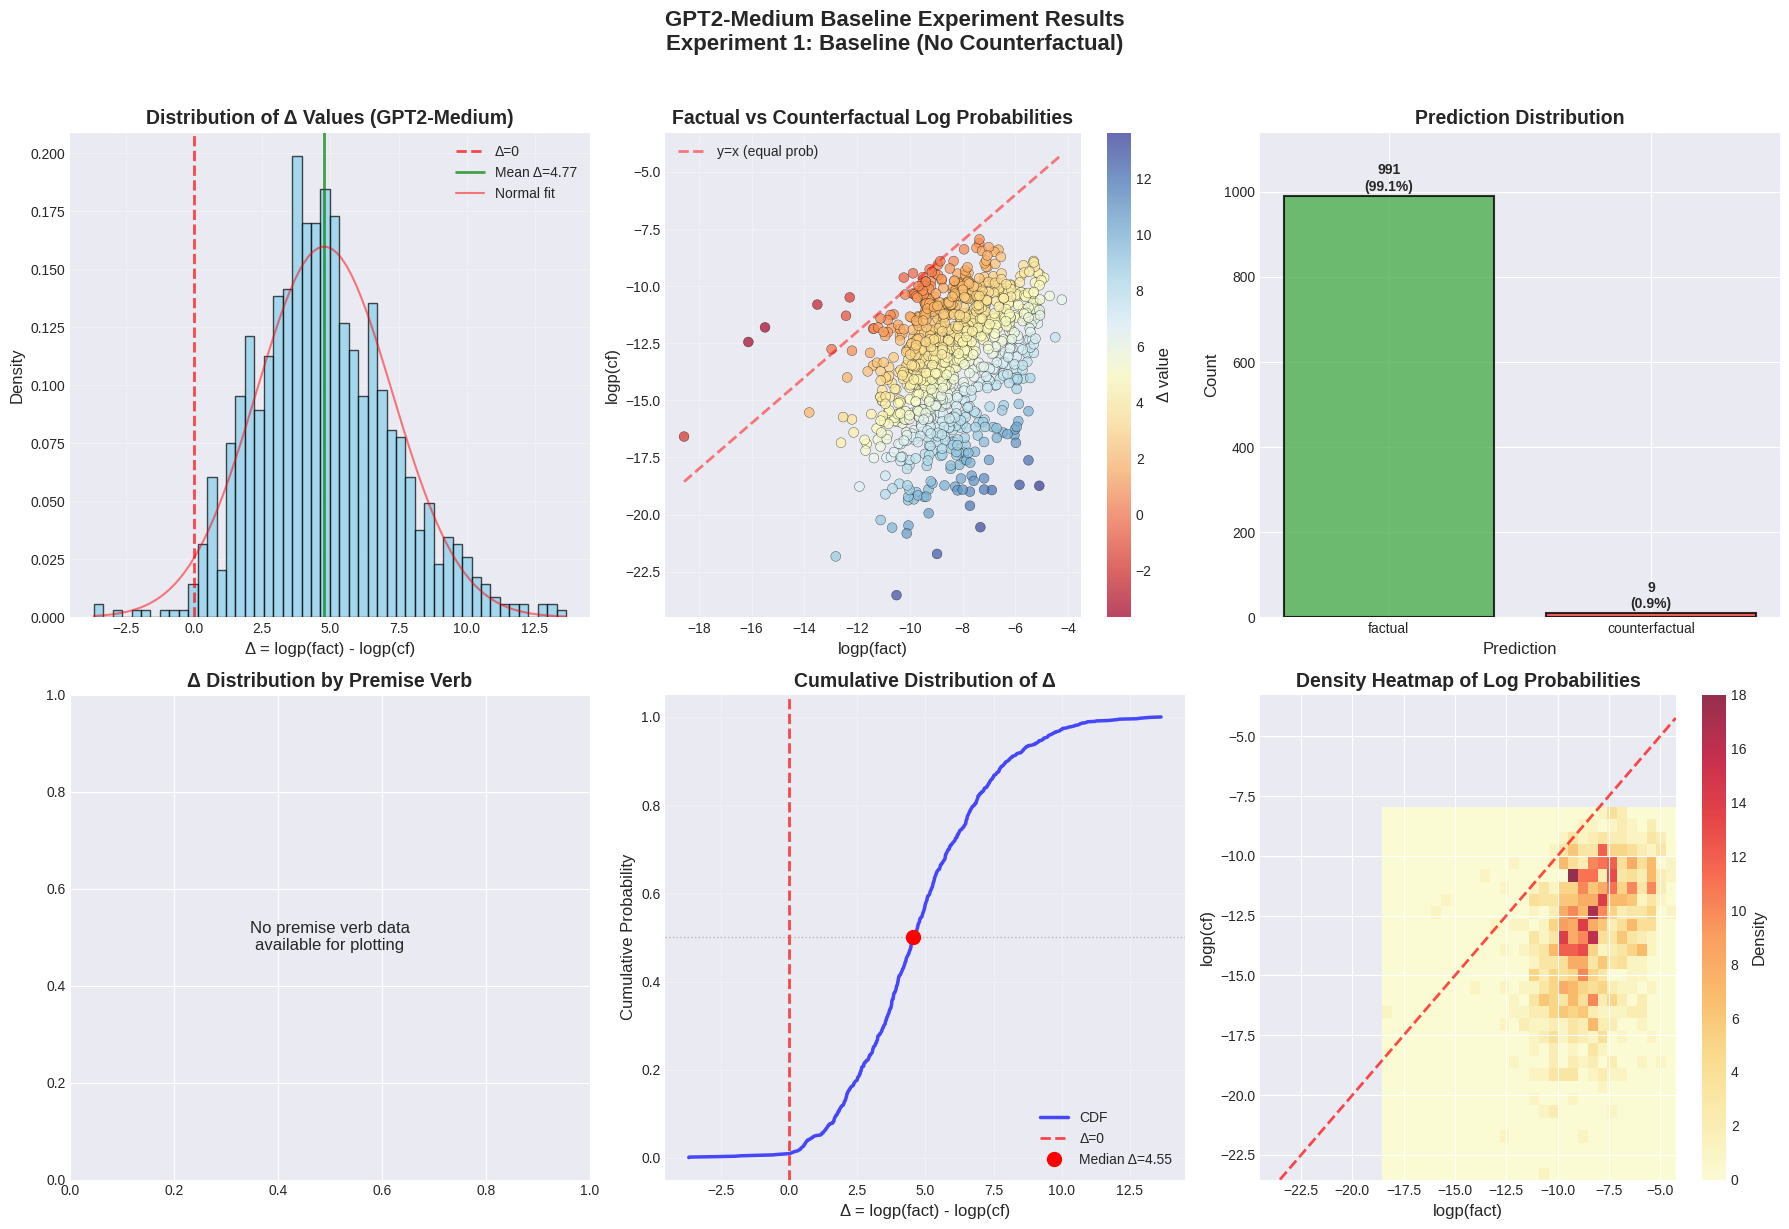

✓ Summary plot saved as gpt2_medium_baseline_summary_20260205_070732.png


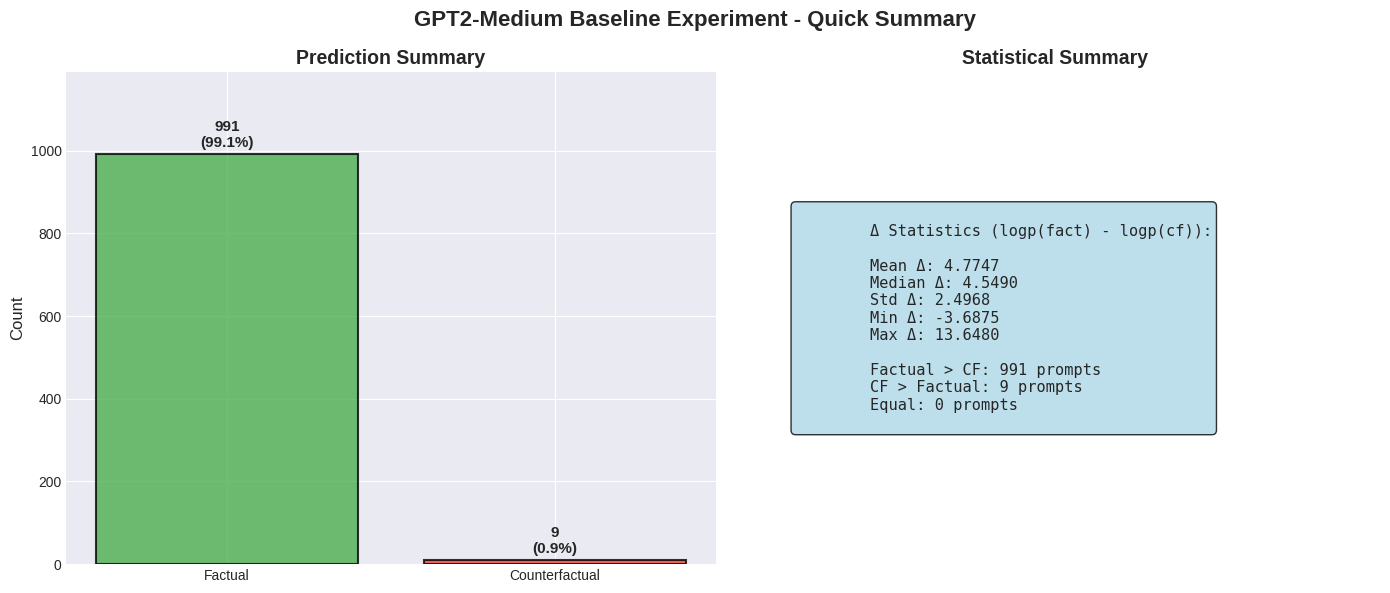

✓ Results saved to gpt2_medium_baseline_results_20260205_070732.json
✓ CSV results saved to gpt2_medium_baseline_results_20260205_070732.csv

📋 Example Results (first 5 prompts):

Example 1:
  Subject: Airbus A380
  Question: Who created the Airbus A380?
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: factual
  logp(fact): -11.1082
  logp(cf): -20.2422
  Δ: 9.1340
----------------------------------------

Example 2:
  Subject: Honda Super Cub
  Question: What company produces the Honda Super Cub?
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prediction: factual
  logp(fact): -7.7935
  logp(cf): -11.1498
  Δ: 3.3563
----------------------------------------

Example 3:
  Subject: Airbus A320 family
  Question: What company produces the Airbus A320 family?
  Factual answer: ' Airbus'
  Counterfactual answer: ' Boeing'
  Prediction: factual
  logp(fact): -9.6637
  logp(cf): -11.3143
  Δ: 1.6506
----------------------------------------

Examp

In [ ]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class BaselineResult:
    """Stores results for a single prompt"""
    subject: str
    question: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"

class BaselineExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
    def setup_model(self):
        """Initialize GPT2-Medium model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # Load with appropriate settings for GPT2-Medium
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                n_devices=1
            )
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Print model info
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Hidden size: {self.model.cfg.d_model}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset for baseline experiment"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt (if available)
                if 'premise_verb' in item:
                    premise_verb = item['premise_verb']
                elif 'prompt' in item and ':' in item['prompt']:
                    premise_verb = item['prompt'].split(':')[0].strip()
                else:
                    premise_verb = 'Unknown'
                    
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
                elif premise_verb != 'Unknown':
                    # Add new verb to list if not already present
                    self.premise_verbs.append(premise_verb)
                    self.verb_groups[premise_verb] = [item]
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_grouped = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups.get(verb, []))
                if count > 0:
                    print(f"  {verb:15}: {count:4d} prompts")
                    total_grouped += count
            
            if total_grouped < len(self.dataset):
                print(f"  {'Uncategorized':15}: {len(self.dataset) - total_grouped:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def create_baseline_prompt(self, question: str) -> str:
        """Create baseline prompt: Q Answer: """
        # Clean the question and add proper formatting
        question = question.strip()
        if not question.endswith('?'):
            question = question + '?'
        return f"{question} Answer:"
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        # Clean the answer and tokenize
        answer = answer.strip()
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        if not target_tokens:
            return -float('inf')
        
        try:
            # Tokenize prompt
            prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
            
            # Combine prompt and target tokens
            all_tokens = prompt_tokens + target_tokens
            
            # Convert to tensor
            tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
            
            with torch.no_grad():
                # Get logits for all positions
                logits = self.model(tokens_tensor)
                
                # Compute log probabilities using log_softmax
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Extract log probabilities for target tokens
                total_logp = 0.0
                
                for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                    # i-1 because logits are shifted by 1 (predicting next token)
                    if i-1 >= 0 and i-1 < log_probs.shape[1]:
                        token_logp = log_probs[0, i-1, token_id].item()
                        total_logp += token_logp
                    else:
                        # If position is out of bounds, skip
                        continue
            
            return total_logp
            
        except Exception as e:
            print(f"Error computing log probabilities: {e}")
            return -float('inf')
    
    def process_item(self, item: Dict) -> Optional[BaselineResult]:
        """Process a single dataset item"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item.get('subject', 'Unknown')
            
            # Create baseline prompt
            prompt = self.create_baseline_prompt(question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = BaselineResult(
                subject=subject,
                question=question,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            print(f"Item: {item}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, 
                      batch_size: int = 32):
        """Run the baseline experiment with batching for efficiency"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 1: BASELINE (NO COUNTERFACTUAL) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            if verb in self.verb_groups:
                all_items.extend(self.verb_groups[verb])
        
        # Also add items not in verb groups
        for item in self.dataset:
            if item not in all_items:
                all_items.append(item)
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process items in batches for efficiency
        self.results = []
        for i in tqdm(range(0, len(all_items), batch_size), desc="Processing batches"):
            batch_items = all_items[i:i+batch_size]
            batch_results = []
            
            for item in batch_items:
                result = self.process_item(item)
                if result:
                    batch_results.append(result)
            
            self.results.extend(batch_results)
            
            # Clear memory periodically
            if i % (batch_size * 10) == 0 and i > 0:
                self.clear_memory()
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = (counterfactual_count / total) * 100 if total > 0 else 0
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results]) if self.results else 0
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        
        # Calculate standard deviations
        std_factual_logp = np.std([r.factual_logp for r in self.results]) if self.results else 0
        std_counterfactual_logp = np.std([r.counterfactual_logp for r in self.results]) if self.results else 0
        std_delta = np.std([r.delta for r in self.results]) if self.results else 0
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 1 RESULTS - BASELINE")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities (mean ± std):")
        print(f"  logp(fact): {avg_factual_logp:.4f} ± {std_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f} ± {std_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} ± {std_delta:.4f} (logp(fact) - logp(cf))")
        
        # Analyze by premise verb - FIXED THE ERROR HERE
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Std Δ':<10}")
        print("-" * 80)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            # FIXED: Removed the incorrect any() usage
            verb_results = []
            for r in self.results:
                # Check if verb appears in any of the text fields
                if (verb in str(r.subject) or 
                    verb in str(r.question) or 
                    verb in str(r.factual_answer) or 
                    verb in str(r.counterfactual_answer)):
                    verb_results.append(r)
            
            # Alternative: Check if verb appears in question or subject
            if not verb_results:
                verb_results = [r for r in self.results 
                              if verb in r.question or verb in r.subject]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_delta_std = np.std([r.delta for r in verb_results]) if verb_results else 0
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'std_delta': verb_delta_std
                }
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta_avg:<10.4f} {verb_delta_std:<10.4f}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[0, 0].axvline(x=np.mean(deltas), color='green', linestyle='-', alpha=0.7, linewidth=2, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Add normal distribution overlay
        try:
            from scipy.stats import norm
            mu, sigma = np.mean(deltas), np.std(deltas)
            x = np.linspace(min(deltas), max(deltas), 100)
            axes[0, 0].plot(x, norm.pdf(x, mu, sigma), 'r-', alpha=0.5, label='Normal fit')
        except ImportError:
            pass
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[0, 0].set_ylabel('Density', fontsize=12)
        axes[0, 0].set_title(f'Distribution of Δ Values (GPT2-Medium)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf)
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=deltas, cmap='RdYlBu', alpha=0.7, 
                                     edgecolors='black', linewidth=0.3, s=50)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, linewidth=2, label='y=x (equal prob)')
        axes[0, 1].set_xlabel('logp(fact)', fontsize=12)
        axes[0, 1].set_ylabel('logp(cf)', fontsize=12)
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities', fontsize=14, fontweight='bold')
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[0, 1])
        cbar.set_label('Δ value', fontsize=12)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['#4CAF50' if p == 'factual' else '#F44336' for p in prediction_counts.index]
        
        bars = axes[0, 2].bar(prediction_counts.index, prediction_counts.values, 
                             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('Prediction', fontsize=12)
        axes[0, 2].set_ylabel('Count', fontsize=12)
        axes[0, 2].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
        
        # Add percentage labels and value labels
        total = len(self.results)
        for i, (bar, (pred, count)) in enumerate(zip(bars, prediction_counts.items())):
            percentage = (count / total) * 100
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + total*0.005,
                           f'{count}\n({percentage:.1f}%)', 
                           ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        axes[0, 2].set_ylim(0, max(prediction_counts.values) * 1.15)
        
        # Plot 4: Δ distribution by premise verb (if available)
        premise_deltas = {}
        for verb in self.premise_verbs:
            verb_deltas = [r.delta for r in self.results 
                         if verb in r.question or verb in r.subject]
            if verb_deltas:
                premise_deltas[verb] = verb_deltas
        
        if premise_deltas:
            # Create boxplot
            positions = range(1, len(premise_deltas) + 1)
            box_data = [premise_deltas[verb] for verb in premise_deltas.keys()]
            
            bp = axes[1, 0].boxplot(box_data, positions=positions, 
                                    labels=premise_deltas.keys(), patch_artist=True,
                                    medianprops=dict(color='black', linewidth=2),
                                    whiskerprops=dict(color='gray', linewidth=1.5),
                                    capprops=dict(color='gray', linewidth=1.5))
            
            # Color boxes based on median Δ
            for i, (patch, verb) in enumerate(zip(bp['boxes'], premise_deltas.keys())):
                median_val = np.median(premise_deltas[verb])
                patch.set_facecolor('#90EE90' if median_val > 0 else '#FFB6C1')
                patch.set_alpha(0.7)
            
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
            axes[1, 0].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 0].set_ylabel('Δ', fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3, axis='y')
            
            # Add sample size annotations
            for i, verb in enumerate(premise_deltas.keys()):
                count = len(premise_deltas[verb])
                axes[1, 0].text(i+1, axes[1, 0].get_ylim()[0] * 0.95, 
                               f'n={count}', ha='center', va='top', fontsize=9)
        else:
            axes[1, 0].text(0.5, 0.5, 'No premise verb data\navailable for plotting', 
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
        
        # Plot 5: Cumulative distribution of Δ
        sorted_deltas = np.sort(deltas)
        cumulative = np.arange(1, len(sorted_deltas) + 1) / len(sorted_deltas)
        
        axes[1, 1].plot(sorted_deltas, cumulative, 'b-', linewidth=2.5, alpha=0.7, label='CDF')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        # Find and mark median
        median_delta = np.median(deltas)
        median_idx = np.searchsorted(sorted_deltas, median_delta)
        axes[1, 1].plot(median_delta, cumulative[median_idx], 'ro', markersize=10, 
                       label=f'Median Δ={median_delta:.2f}')
        
        axes[1, 1].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
        axes[1, 1].set_title('Cumulative Distribution of Δ', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=10, loc='lower right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Heatmap of logp correlation
        if len(factual_logps) > 0 and len(counterfactual_logps) > 0:
            # Create 2D histogram
            heatmap, xedges, yedges = np.histogram2d(factual_logps, counterfactual_logps, bins=30)
            
            # Plot heatmap
            im = axes[1, 2].imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                                  origin='lower', aspect='auto', cmap='YlOrRd', alpha=0.8)
            
            # Add diagonal line
            min_val = min(min(factual_logps), min(counterfactual_logps))
            max_val = max(max(factual_logps), max(counterfactual_logps))
            axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
            
            axes[1, 2].set_xlabel('logp(fact)', fontsize=12)
            axes[1, 2].set_ylabel('logp(cf)', fontsize=12)
            axes[1, 2].set_title('Density Heatmap of Log Probabilities', fontsize=14, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=axes[1, 2])
            cbar.set_label('Density', fontsize=12)
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor heatmap', 
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Density Heatmap of Log Probabilities', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Baseline Experiment Results\nExperiment 1: Baseline (No Counterfactual)', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_baseline_experiment_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Plot saved as {filename}")
        plt.show()
        
        # Also create a summary figure
        self.create_summary_figure(deltas, factual_logps, counterfactual_logps, predictions)
    
    def create_summary_figure(self, deltas, factual_logps, counterfactual_logps, predictions):
        """Create a simplified summary figure"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Summary bar chart
        factual_count = predictions.count('factual')
        cf_count = len(predictions) - factual_count
        
        bars = axes[0].bar(['Factual', 'Counterfactual'], [factual_count, cf_count], 
                          color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Prediction Summary', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        total = len(predictions)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{height}\n({percentage:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        axes[0].set_ylim(0, max(factual_count, cf_count) * 1.2)
        
        # Δ statistics box
        stats_text = f"""
        Δ Statistics (logp(fact) - logp(cf)):
        
        Mean Δ: {np.mean(deltas):.4f}
        Median Δ: {np.median(deltas):.4f}
        Std Δ: {np.std(deltas):.4f}
        Min Δ: {np.min(deltas):.4f}
        Max Δ: {np.max(deltas):.4f}
        
        Factual > CF: {sum(1 for d in deltas if d > 0)} prompts
        CF > Factual: {sum(1 for d in deltas if d < 0)} prompts
        Equal: {sum(1 for d in deltas if d == 0)} prompts
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center', transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1].axis('off')
        axes[1].set_title('Statistical Summary', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Baseline Experiment - Quick Summary', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_baseline_summary_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Summary plot saved as {filename}")
        plt.show()
    
    def save_results(self, output_path: str = None):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Create default output path if not provided
        if output_path is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_path = f'gpt2_medium_baseline_results_{timestamp}.json'
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction
            })
        
        # Calculate summary statistics
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        total = len(self.results)
        
        # Save to file
        output_data = {
            'experiment': 'Experiment 1: Baseline (No Counterfactual)',
            'model': self.model_name,
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_prompts': total,
            'summary': {
                'factual_count': factual_count,
                'counterfactual_count': total - factual_count,
                'factual_percent': (factual_count / total) * 100 if total > 0 else 0,
                'counterfactual_percent': ((total - factual_count) / total) * 100 if total > 0 else 0,
                'avg_factual_logp': float(np.mean([r.factual_logp for r in self.results]) if self.results else 0),
                'avg_counterfactual_logp': float(np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'avg_delta': float(np.mean([r.delta for r in self.results]) if self.results else 0),
                'std_factual_logp': float(np.std([r.factual_logp for r in self.results]) if self.results else 0),
                'std_counterfactual_logp': float(np.std([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'std_delta': float(np.std([r.delta for r in self.results]) if self.results else 0),
            },
            'results': serializable_results
        }
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
        
        # Also save a CSV version for easier analysis
        csv_path = output_path.replace('.json', '.csv')
        df_data = []
        for r in self.results:
            df_data.append({
                'subject': r.subject,
                'question': r.question,
                'factual_answer': r.factual_answer,
                'counterfactual_answer': r.counterfactual_answer,
                'factual_logp': r.factual_logp,
                'counterfactual_logp': r.counterfactual_logp,
                'delta': r.delta,
                'prediction': r.prediction
            })
        
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV results saved to {csv_path}")

# Example usage for GPT2-Medium
if __name__ == "__main__":
    # Configuration for GPT2-Medium
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path
    MODEL_NAME = "gpt2-medium"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    BATCH_SIZE = 16  # Adjust based on available GPU memory
    
    print(f"Running Experiment 1: Baseline with {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Run experiment
    experiment = BaselineExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Print example results
    if results:
        print("\n📋 Example Results (first 5 prompts):")
        print("=" * 80)
        for i, result in enumerate(experiment.results[:5]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Question: {result.question}")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            print("-" * 40)
    
    print("\n✅ Experiment completed successfully!")

/home/animesh-lohar-2711/anaconda3/envs/comp_mech_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running Experiment 2: Context-Only (ICL Dominant) with gpt2-medium
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000
Batch size: 16

EXPERIMENT 2: CONTEXT-ONLY PROMPTS (ICL DOMINANT) - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Parameters: 406,236,241
  Layers: 24
  Hidden size: 1024
  Heads: 16
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine       : 4329 prompts
  Assess         : 4924 prompts
  Fact Check     : 4916 prompts
  Review         : 4942 prompts
  Validate       : 4915 prompts
  Verify         : 4927 prompts

Processing 1000 prompts...


Processing batches: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


✓ Processed 1000 prompts successfully

EXPERIMENT 2 RESULTS - CONTEXT-ONLY (ICL DOMINANT)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 827 (82.7%)
  Counterfactual predictions: 173 (17.3%)

Average Log Probabilities (mean ± std):
  logp(fact): -10.0713 ± 1.4548
  logp(cf):   -11.6026 ± 1.9144
  Δ:          1.5313 ± 1.9297 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Context-Only condition (ICL Dominant), we expect:
  - Lower factual percentage than baseline
  - Higher counterfactual percentage than baseline
  - Negative Δ values (logp(cf) > logp(fact)) for ICL compliance

Pattern Compliance:
  Prompts with negative Δ (following ICL): 172/1000 (17.2%)
  Prompts with positive Δ (resisting ICL): 827/1000 (82.8%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Std Δ      ICL %     
------------------------------------------------------------------------------------------
✓ Plot saved as gpt2_medium_context_only

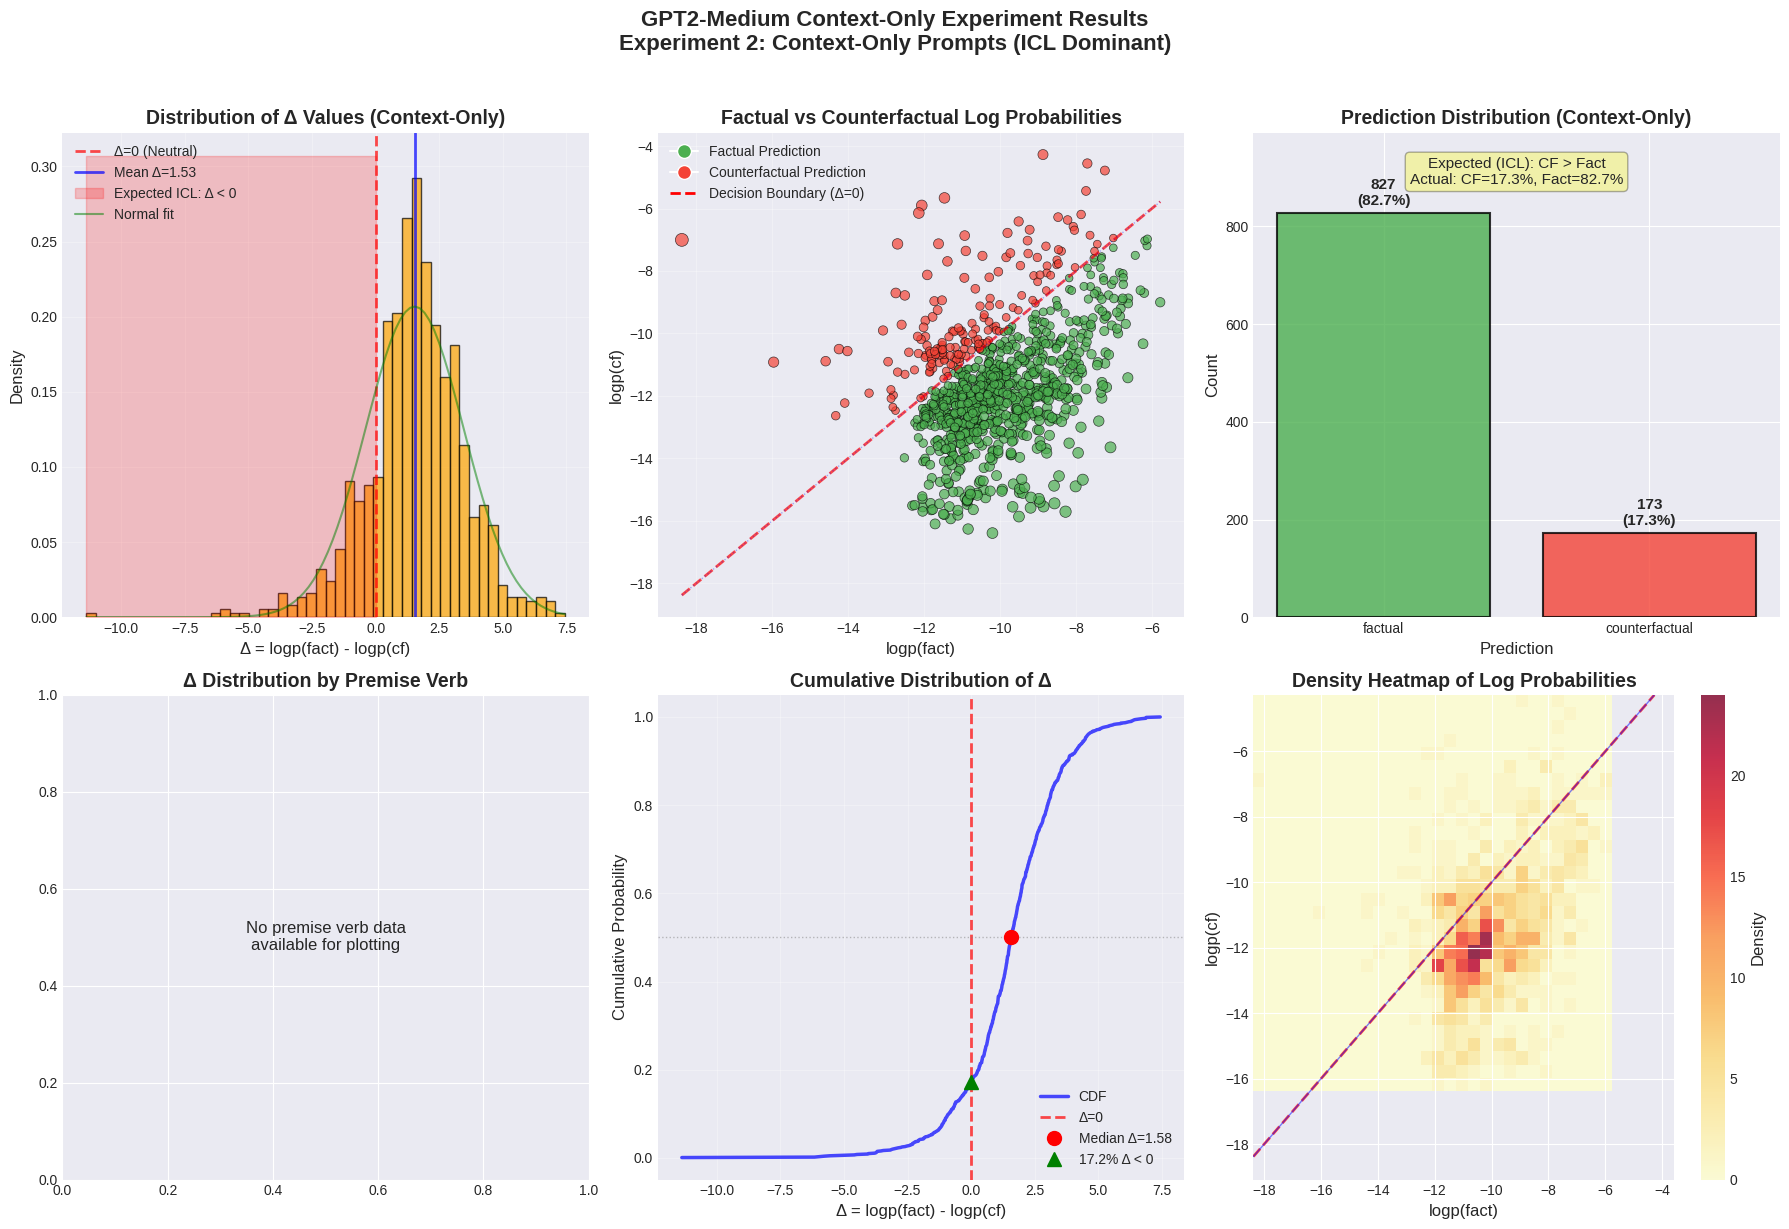

✓ Summary plot saved as gpt2_medium_context_only_summary_20260205_093640.png


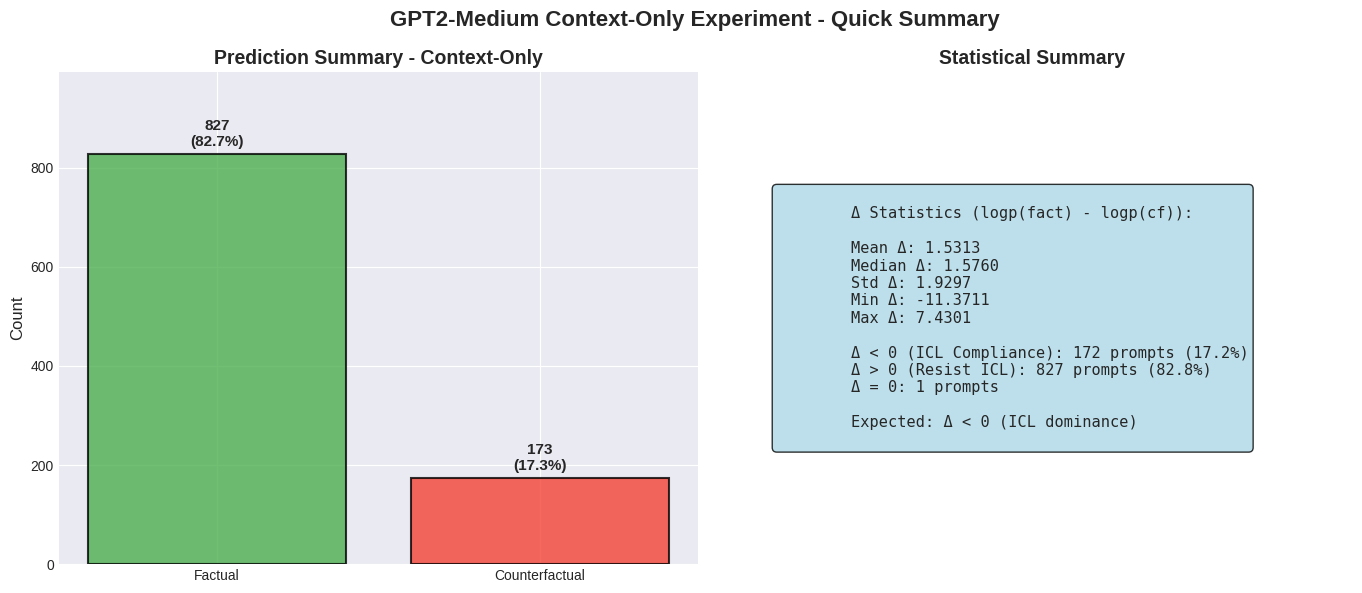

✓ Results saved to gpt2_medium_context_only_results_20260205_093641.json
✓ CSV results saved to gpt2_medium_context_only_results_20260205_093641.csv
✗ No baseline results found. Run Experiment 1 first.

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: factual
  logp(fact): -11.0402
  logp(cf): -11.3587
  Δ: 0.3184
  Prompt preview: IMPORTANT: You MUST answer using ONLY the information provided below. Do NOT use your own knowledge. Do NOT correct the text even if it contradicts re...
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrol

In [1]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class ContextOnlyResult:
    """Stores results for a single prompt in Context-Only condition"""
    subject: str
    question: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class ContextOnlyExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Context-Only prompt template (Strong Instruction) - Experiment 2
        self.context_only_template = (
            "IMPORTANT: You MUST answer using ONLY the information provided below. "
            "Do NOT use your own knowledge. Do NOT correct the text even if it contradicts reality. "
            "Treat the text as fully true.\n\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize GPT2-Medium model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # Load with appropriate settings for GPT2-Medium
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                n_devices=1
            )
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Print model info
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Hidden size: {self.model.cfg.d_model}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt (if available)
                if 'premise_verb' in item:
                    premise_verb = item['premise_verb']
                elif 'prompt' in item and ':' in item['prompt']:
                    premise_verb = item['prompt'].split(':')[0].strip()
                else:
                    premise_verb = 'Unknown'
                    
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
                elif premise_verb != 'Unknown':
                    # Add new verb to list if not already present
                    self.premise_verbs.append(premise_verb)
                    self.verb_groups[premise_verb] = [item]
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_grouped = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups.get(verb, []))
                if count > 0:
                    print(f"  {verb:15}: {count:4d} prompts")
                    total_grouped += count
            
            if total_grouped < len(self.dataset):
                print(f"  {'Uncategorized':15}: {len(self.dataset) - total_grouped:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs like "Redefine", the prompt format is "Redefine: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Check if it's a "created by" type statement
        if "created" in prompt.lower() or "made" in prompt.lower():
            return f"{subject} was created by {target_new}"
        elif "invented" in prompt.lower():
            return f"{subject} was invented by {target_new}"
        elif "developed" in prompt.lower():
            return f"{subject} was developed by {target_new}"
        elif "written" in prompt.lower() or "author" in prompt.lower():
            return f"{subject} was written by {target_new}"
        elif "composed" in prompt.lower():
            return f"{subject} was composed by {target_new}"
        elif "painted" in prompt.lower():
            return f"{subject} was painted by {target_new}"
        elif "directed" in prompt.lower():
            return f"{subject} was directed by {target_new}"
        elif "designed" in prompt.lower():
            return f"{subject} was designed by {target_new}"
        elif "founded" in prompt.lower():
            return f"{subject} was founded by {target_new}"
        elif "discovered" in prompt.lower():
            return f"{subject} was discovered by {target_new}"
        else:
            # Generic construction
            return f"{subject} is associated with {target_new}"
    
    def create_context_only_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create context-only prompt with strong instructions"""
        return self.context_only_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        # Clean the answer and tokenize
        answer = answer.strip()
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        if not target_tokens:
            return -float('inf')
        
        try:
            # Tokenize prompt
            prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
            
            # Combine prompt and target tokens
            all_tokens = prompt_tokens + target_tokens
            
            # Convert to tensor
            tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
            
            with torch.no_grad():
                # Get logits for all positions
                logits = self.model(tokens_tensor)
                
                # Compute log probabilities using log_softmax
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Extract log probabilities for target tokens
                total_logp = 0.0
                
                for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                    # i-1 because logits are shifted by 1 (predicting next token)
                    if i-1 >= 0 and i-1 < log_probs.shape[1]:
                        token_logp = log_probs[0, i-1, token_id].item()
                        total_logp += token_logp
                    else:
                        # If position is out of bounds, skip
                        continue
            
            return total_logp
            
        except Exception as e:
            print(f"Error computing log probabilities: {e}")
            return -float('inf')
    
    def process_item(self, item: Dict) -> Optional[ContextOnlyResult]:
        """Process a single dataset item for Context-Only condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item.get('subject', 'Unknown')
            original_prompt = item.get('prompt', '')
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create context-only prompt
            prompt = self.create_context_only_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = ContextOnlyResult(
                subject=subject,
                question=question,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            print(f"Item: {item}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, 
                      batch_size: int = 16):
        """Run the Context-Only experiment with batching for efficiency"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 2: CONTEXT-ONLY PROMPTS (ICL DOMINANT) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            if verb in self.verb_groups:
                all_items.extend(self.verb_groups[verb])
        
        # Also add items not in verb groups
        for item in self.dataset:
            if item not in all_items:
                all_items.append(item)
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process items in batches for efficiency
        self.results = []
        for i in tqdm(range(0, len(all_items), batch_size), desc="Processing batches"):
            batch_items = all_items[i:i+batch_size]
            batch_results = []
            
            for item in batch_items:
                result = self.process_item(item)
                if result:
                    batch_results.append(result)
            
            self.results.extend(batch_results)
            
            # Clear memory periodically
            if i % (batch_size * 10) == 0 and i > 0:
                self.clear_memory()
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Context-Only condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = (counterfactual_count / total) * 100 if total > 0 else 0
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results]) if self.results else 0
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        
        # Calculate standard deviations
        std_factual_logp = np.std([r.factual_logp for r in self.results]) if self.results else 0
        std_counterfactual_logp = np.std([r.counterfactual_logp for r in self.results]) if self.results else 0
        std_delta = np.std([r.delta for r in self.results]) if self.results else 0
        
        # Count how many follow expected pattern (negative delta)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        negative_delta_percent = (negative_delta_count / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 2 RESULTS - CONTEXT-ONLY (ICL DOMINANT)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities (mean ± std):")
        print(f"  logp(fact): {avg_factual_logp:.4f} ± {std_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f} ± {std_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} ± {std_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Context-Only condition (ICL Dominant), we expect:")
        print("  - Lower factual percentage than baseline")
        print("  - Higher counterfactual percentage than baseline")
        print("  - Negative Δ values (logp(cf) > logp(fact)) for ICL compliance")
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with negative Δ (following ICL): {negative_delta_count}/{total} ({negative_delta_percent:.1f}%)")
        print(f"  Prompts with positive Δ (resisting ICL): {sum(1 for r in self.results if r.delta > 0)}/{total} ({100-negative_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Std Δ':<10} {'ICL %':<10}")
        print("-" * 90)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            # Check if verb appears in any of the text fields
            verb_results = []
            for r in self.results:
                if (verb in str(r.subject) or 
                    verb in str(r.question) or 
                    verb in str(r.counterfactual_statement) or
                    verb in str(r.prompt)):
                    verb_results.append(r)
            
            # Alternative: Check if verb appears in question or subject
            if not verb_results:
                verb_results = [r for r in self.results 
                              if verb in r.question or verb in r.subject]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_delta_std = np.std([r.delta for r in verb_results]) if verb_results else 0
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100 if verb_total > 0 else 0
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'std_delta': verb_delta_std,
                    'follows_icl_pct': verb_follows_icl
                }
                
                follows_icl_symbol = "✓" if verb_delta_avg < 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta_avg:<10.4f} "
                      f"{verb_delta_std:<10.4f} {verb_follows_icl:>9.1f}% {follows_icl_symbol}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Context-Only experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='orange', edgecolor='black', density=True)
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, linewidth=2,
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (negative delta for ICL)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='red',
                               label='Expected ICL: Δ < 0')
        
        # Add normal distribution overlay
        try:
            from scipy.stats import norm
            mu, sigma = np.mean(deltas), np.std(deltas)
            x = np.linspace(min(deltas), max(deltas), 100)
            axes[0, 0].plot(x, norm.pdf(x, mu, sigma), 'g-', alpha=0.5, linewidth=1.5, label='Normal fit')
        except ImportError:
            pass
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[0, 0].set_ylabel('Density', fontsize=12)
        axes[0, 0].set_title('Distribution of Δ Values (Context-Only)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['#4CAF50' if r.prediction == 'factual' else '#F44336' for r in self.results]
        sizes = [30 + abs(r.delta) * 5 for r in self.results]  # Size based on |Δ|
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps,
                                     c=colors, s=sizes, alpha=0.7,
                                     edgecolors='black', linewidth=0.5)
        
        # Add diagonal line (decision boundary)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'r--', alpha=0.7, linewidth=2, label='Decision Boundary (Δ=0)')
        
        # Add perfect prediction line (y=x)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'b:', alpha=0.3, linewidth=1, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)', fontsize=12)
        axes[0, 1].set_ylabel('logp(cf)', fontsize=12)
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities', fontsize=14, fontweight='bold')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50',
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#F44336',
                  markersize=10, label='Counterfactual Prediction'),
            Line2D([0], [0], color='r', linestyle='--', linewidth=2, label='Decision Boundary (Δ=0)')
        ]
        axes[0, 1].legend(handles=legend_elements, fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['#4CAF50' if p == 'factual' else '#F44336' for p in prediction_counts.index]
        
        bars = axes[0, 2].bar(prediction_counts.index, prediction_counts.values,
                             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('Prediction', fontsize=12)
        axes[0, 2].set_ylabel('Count', fontsize=12)
        axes[0, 2].set_title('Prediction Distribution (Context-Only)', fontsize=14, fontweight='bold')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (bar, (pred, count)) in enumerate(zip(bars, prediction_counts.items())):
            percentage = (count / total) * 100
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                           f'{count}\n({percentage:.1f}%)',
                           ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add expected direction annotation
        expected_text = f"Expected (ICL): CF > Fact\nActual: CF={cf_pct:.1f}%, Fact={factual_pct:.1f}%"
        axes[0, 2].text(0.5, 0.95, expected_text, transform=axes[0, 2].transAxes,
                       ha='center', va='top', fontsize=11,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        axes[0, 2].set_ylim(0, max(prediction_counts.values) * 1.2)
        
        # Plot 4: Δ distribution by premise verb (if available)
        premise_deltas = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_deltas = [r.delta for r in self.results
                         if verb in r.question or verb in r.subject or verb in str(r.counterfactual_statement)]
            if verb_deltas:
                premise_deltas[verb] = verb_deltas
                
                # Calculate compliance percentage
                negative_delta_count = sum(1 for d in verb_deltas if d < 0)
                premise_compliance[verb] = (negative_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create boxplot
            positions = range(1, len(premise_deltas) + 1)
            box_data = [premise_deltas[verb] for verb in premise_deltas.keys()]
            
            bp = axes[1, 0].boxplot(box_data, positions=positions,
                                    labels=premise_deltas.keys(), patch_artist=True,
                                    medianprops=dict(color='black', linewidth=2),
                                    whiskerprops=dict(color='gray', linewidth=1.5),
                                    capprops=dict(color='gray', linewidth=1.5))
            
            # Color boxes based on median Δ
            for i, (patch, verb) in enumerate(zip(bp['boxes'], premise_deltas.keys())):
                median_val = np.median(premise_deltas[verb])
                # Green if median < 0 (following ICL), red if median > 0 (not following ICL)
                patch.set_facecolor('#90EE90' if median_val < 0 else '#FFB6C1')
                patch.set_alpha(0.7)
            
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
            axes[1, 0].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 0].set_ylabel('Δ', fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3, axis='y')
            axes[1, 0].legend(fontsize=10)
            
            # Add sample size and compliance percentage annotations
            for i, verb in enumerate(premise_deltas.keys()):
                count = len(premise_deltas[verb])
                compliance = premise_compliance.get(verb, 0)
                axes[1, 0].text(i+1, axes[1, 0].get_ylim()[0] * 0.95,
                               f'n={count}\n{compliance:.0f}% ICL',
                               ha='center', va='top', fontsize=9)
        else:
            axes[1, 0].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
        
        # Plot 5: Cumulative distribution of Δ
        sorted_deltas = np.sort(deltas)
        cumulative = np.arange(1, len(sorted_deltas) + 1) / len(sorted_deltas)
        
        axes[1, 1].plot(sorted_deltas, cumulative, 'b-', linewidth=2.5, alpha=0.7, label='CDF')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        # Find and mark median
        median_delta = np.median(deltas)
        median_idx = np.searchsorted(sorted_deltas, median_delta)
        axes[1, 1].plot(median_delta, cumulative[median_idx], 'ro', markersize=10,
                       label=f'Median Δ={median_delta:.2f}')
        
        # Mark the percentage of negative deltas
        negative_delta_pct = sum(1 for d in deltas if d < 0) / len(deltas) * 100
        if any(d < 0 for d in deltas):
            max_negative_delta = max(d for d in deltas if d < 0)
            negative_idx = np.searchsorted(sorted_deltas, max_negative_delta)
            negative_pct = cumulative[negative_idx]
            axes[1, 1].plot(max_negative_delta, negative_pct, 'g^', markersize=10,
                           label=f'{negative_delta_pct:.1f}% Δ < 0')
        
        axes[1, 1].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
        axes[1, 1].set_title('Cumulative Distribution of Δ', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=10, loc='lower right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Heatmap of logp correlation
        if len(factual_logps) > 0 and len(counterfactual_logps) > 0:
            # Create 2D histogram
            heatmap, xedges, yedges = np.histogram2d(factual_logps, counterfactual_logps, bins=30)
            
            # Plot heatmap
            im = axes[1, 2].imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                                  origin='lower', aspect='auto', cmap='YlOrRd', alpha=0.8)
            
            # Add diagonal line
            min_val = min(min(factual_logps), min(counterfactual_logps))
            max_val = max(max(factual_logps), max(counterfactual_logps))
            axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)
            
            # Add decision boundary line (Δ=0)
            axes[1, 2].plot([min_val, max_val], [min_val, max_val], 'b-', alpha=0.5, linewidth=1)
            
            axes[1, 2].set_xlabel('logp(fact)', fontsize=12)
            axes[1, 2].set_ylabel('logp(cf)', fontsize=12)
            axes[1, 2].set_title('Density Heatmap of Log Probabilities', fontsize=14, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=axes[1, 2])
            cbar.set_label('Density', fontsize=12)
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor heatmap',
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Density Heatmap of Log Probabilities', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Context-Only Experiment Results\nExperiment 2: Context-Only Prompts (ICL Dominant)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_context_only_experiment_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Plot saved as {filename}")
        plt.show()
        
        # Also create a summary figure
        self.create_summary_figure(deltas, factual_logps, counterfactual_logps, predictions)
    
    def create_summary_figure(self, deltas, factual_logps, counterfactual_logps, predictions):
        """Create a simplified summary figure"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Summary bar chart
        factual_count = predictions.count('factual')
        cf_count = len(predictions) - factual_count
        
        bars = axes[0].bar(['Factual', 'Counterfactual'], [factual_count, cf_count],
                          color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Prediction Summary - Context-Only', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        total = len(predictions)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{height}\n({percentage:.1f}%)',
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        axes[0].set_ylim(0, max(factual_count, cf_count) * 1.2)
        
        # Δ statistics box
        negative_delta_count = sum(1 for d in deltas if d < 0)
        negative_delta_pct = (negative_delta_count / len(deltas)) * 100 if deltas else 0
        
        stats_text = f"""
        Δ Statistics (logp(fact) - logp(cf)):
        
        Mean Δ: {np.mean(deltas):.4f}
        Median Δ: {np.median(deltas):.4f}
        Std Δ: {np.std(deltas):.4f}
        Min Δ: {np.min(deltas):.4f}
        Max Δ: {np.max(deltas):.4f}
        
        Δ < 0 (ICL Compliance): {negative_delta_count} prompts ({negative_delta_pct:.1f}%)
        Δ > 0 (Resist ICL): {sum(1 for d in deltas if d > 0)} prompts ({100-negative_delta_pct:.1f}%)
        Δ = 0: {sum(1 for d in deltas if d == 0)} prompts
        
        Expected: Δ < 0 (ICL dominance)
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center', transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1].axis('off')
        axes[1].set_title('Statistical Summary', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Context-Only Experiment - Quick Summary',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_context_only_summary_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Summary plot saved as {filename}")
        plt.show()
    
    def compare_with_baseline(self, baseline_results_path: str = None):
        """Compare Context-Only results with Baseline results"""
        if baseline_results_path is None:
            # Try to find the most recent baseline results
            import glob, os
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_results_path = baseline_files[0]
            else:
                print("✗ No baseline results found. Run Experiment 1 first.")
                return
        
        try:
            with open(baseline_results_path, 'r') as f:
                baseline_data = json.load(f)
            
            baseline_summary = baseline_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100 if total > 0 else 0
            counterfactual_percent = 100 - factual_percent
            avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
            
            print(f"\n{'='*70}")
            print("COMPARISON WITH BASELINE EXPERIMENT (GPT2-Medium)")
            print(f"{'='*70}")
            print(f"\n{'Metric':<30} {'Baseline':<15} {'Context-Only':<15} {'Difference':<15}")
            print("-" * 75)
            
            print(f"{'% Factual':<30} "
                  f"{baseline_summary.get('factual_percent', 0):<15.1f} "
                  f"{factual_percent:<15.1f} "
                  f"{factual_percent - baseline_summary.get('factual_percent', 0):>+15.1f}")
            
            print(f"{'% Counterfactual':<30} "
                  f"{baseline_summary.get('counterfactual_percent', 0):<15.1f} "
                  f"{counterfactual_percent:<15.1f} "
                  f"{counterfactual_percent - baseline_summary.get('counterfactual_percent', 0):>+15.1f}")
            
            print(f"{'Avg Δ (logp(fact) - logp(cf))':<30} "
                  f"{baseline_summary.get('avg_delta', 0):<15.4f} "
                  f"{avg_delta:<15.4f} "
                  f"{avg_delta - baseline_summary.get('avg_delta', 0):>+15.4f}")
            
            print(f"\nInterpretation (Context-Only vs Baseline):")
            print(f"- Expected: Context-Only should have LOWER factual % than Baseline")
            print(f"- Expected: Context-Only should have HIGHER counterfactual % than Baseline")
            print(f"- Expected: Context-Only should have LOWER Δ than Baseline (more negative)")
            
            # Check if expectations are met
            factual_diff = factual_percent - baseline_summary.get('factual_percent', 0)
            delta_diff = avg_delta - baseline_summary.get('avg_delta', 0)
            
            print(f"\nExpectations met?")
            print(f"  Lower factual %: {'✓' if factual_diff < 0 else '✗'} ({factual_diff:+.1f}%)")
            print(f"  Lower Δ: {'✓' if delta_diff < 0 else '✗'} ({delta_diff:+.4f})")
            
            # Calculate effect size
            if total > 0 and 'total_prompts' in baseline_data and baseline_data['total_prompts'] > 0:
                baseline_total = baseline_data['total_prompts']
                baseline_factual = baseline_summary.get('factual_percent', 0) * baseline_total / 100
                context_factual = factual_percent * total / 100
                
                # Cohen's h for proportions
                import math
                phi1 = 2 * math.asin(math.sqrt(baseline_factual / baseline_total))
                phi2 = 2 * math.asin(math.sqrt(context_factual / total))
                cohens_h = abs(phi1 - phi2)
                
                print(f"\nEffect Size (Cohen's h): {cohens_h:.3f}")
                print(f"  Small effect: h < 0.2")
                print(f"  Medium effect: 0.2 ≤ h < 0.5")
                print(f"  Large effect: h ≥ 0.5")
            
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_results_path}")
            print("  Run Experiment 1 (Baseline) first to enable comparison")
        except Exception as e:
            print(f"✗ Error comparing with baseline: {e}")
    
    def save_results(self, output_path: str = None):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Create default output path if not provided
        if output_path is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_path = f'gpt2_medium_context_only_results_{timestamp}.json'
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        total = len(self.results)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        
        # Save to file
        output_data = {
            'experiment': 'Experiment 2: Context-Only Prompts (ICL Dominant)',
            'model': self.model_name,
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_prompts': total,
            'condition': 'Context-Only (ICL Dominant)',
            'prompt_template': self.context_only_template,
            'results': serializable_results,
            'summary': {
                'factual_count': factual_count,
                'counterfactual_count': total - factual_count,
                'factual_percent': (factual_count / total) * 100 if total > 0 else 0,
                'counterfactual_percent': ((total - factual_count) / total) * 100 if total > 0 else 0,
                'avg_factual_logp': float(np.mean([r.factual_logp for r in self.results]) if self.results else 0),
                'avg_counterfactual_logp': float(np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'avg_delta': float(np.mean([r.delta for r in self.results]) if self.results else 0),
                'std_factual_logp': float(np.std([r.factual_logp for r in self.results]) if self.results else 0),
                'std_counterfactual_logp': float(np.std([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'std_delta': float(np.std([r.delta for r in self.results]) if self.results else 0),
                'negative_delta_count': negative_delta_count,
                'negative_delta_percent': (negative_delta_count / total) * 100 if total > 0 else 0,
            }
        }
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
        
        # Also save a CSV version for easier analysis
        csv_path = output_path.replace('.json', '.csv')
        df_data = []
        for r in self.results:
            df_data.append({
                'subject': r.subject,
                'question': r.question,
                'counterfactual_statement': r.counterfactual_statement,
                'factual_answer': r.factual_answer,
                'counterfactual_answer': r.counterfactual_answer,
                'factual_logp': r.factual_logp,
                'counterfactual_logp': r.counterfactual_logp,
                'delta': r.delta,
                'prediction': r.prediction
            })
        
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV results saved to {csv_path}")

# Example usage for GPT2-Medium
if __name__ == "__main__":
    # Configuration for GPT2-Medium
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path
    MODEL_NAME = "gpt2-medium"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    BATCH_SIZE = 16  # Adjust based on available GPU memory
    
    print(f"Running Experiment 2: Context-Only (ICL Dominant) with {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Run experiment
    experiment = ContextOnlyExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with baseline if available
    experiment.compare_with_baseline()
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            
            # Show first 150 chars of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"  Prompt preview: {prompt_preview}")
            print("-" * 90)
    
    print("\n✅ Experiment 2 (Context-Only) completed successfully!")

Running Experiment 3: Context-Only with Premise Verb with gpt2-medium
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000
Batch size: 16

EXPERIMENT 3: CONTEXT-ONLY WITH PREMISE VERB - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Parameters: 406,236,241
  Layers: 24
  Hidden size: 1024
  Heads: 16
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine       : 4329 prompts
  Assess         : 4924 prompts
  Fact Check     : 4916 prompts
  Review         : 4942 prompts
  Validate       : 4915 prompts
  Verify         : 4927 prompts

Processing 1000 prompts...


Processing batches: 100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


✓ Processed 1000 prompts successfully

EXPERIMENT 3 RESULTS - CONTEXT-ONLY WITH PREMISE VERB

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 830 (83.0%)
  Counterfactual predictions: 170 (17.0%)

Average Log Probabilities (mean ± std):
  logp(fact): -10.3215 ± 1.4036
  logp(cf):   -11.7776 ± 1.8262
  Δ:          1.4561 ± 1.8468 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Context-Only with PV condition, we expect:
  - Similar or stronger ICL dominance than Experiment 2
  - PV may strengthen the instruction to use only provided context
  - Negative Δ values (logp(cf) > logp(fact)) expected

Pattern Compliance:
  Prompts with negative Δ (following ICL): 170/1000 (17.0%)
  Prompts with positive Δ (resisting ICL): 830/1000 (83.0%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Std Δ      ICL %     
------------------------------------------------------------------------------------------
Redefine        1000     

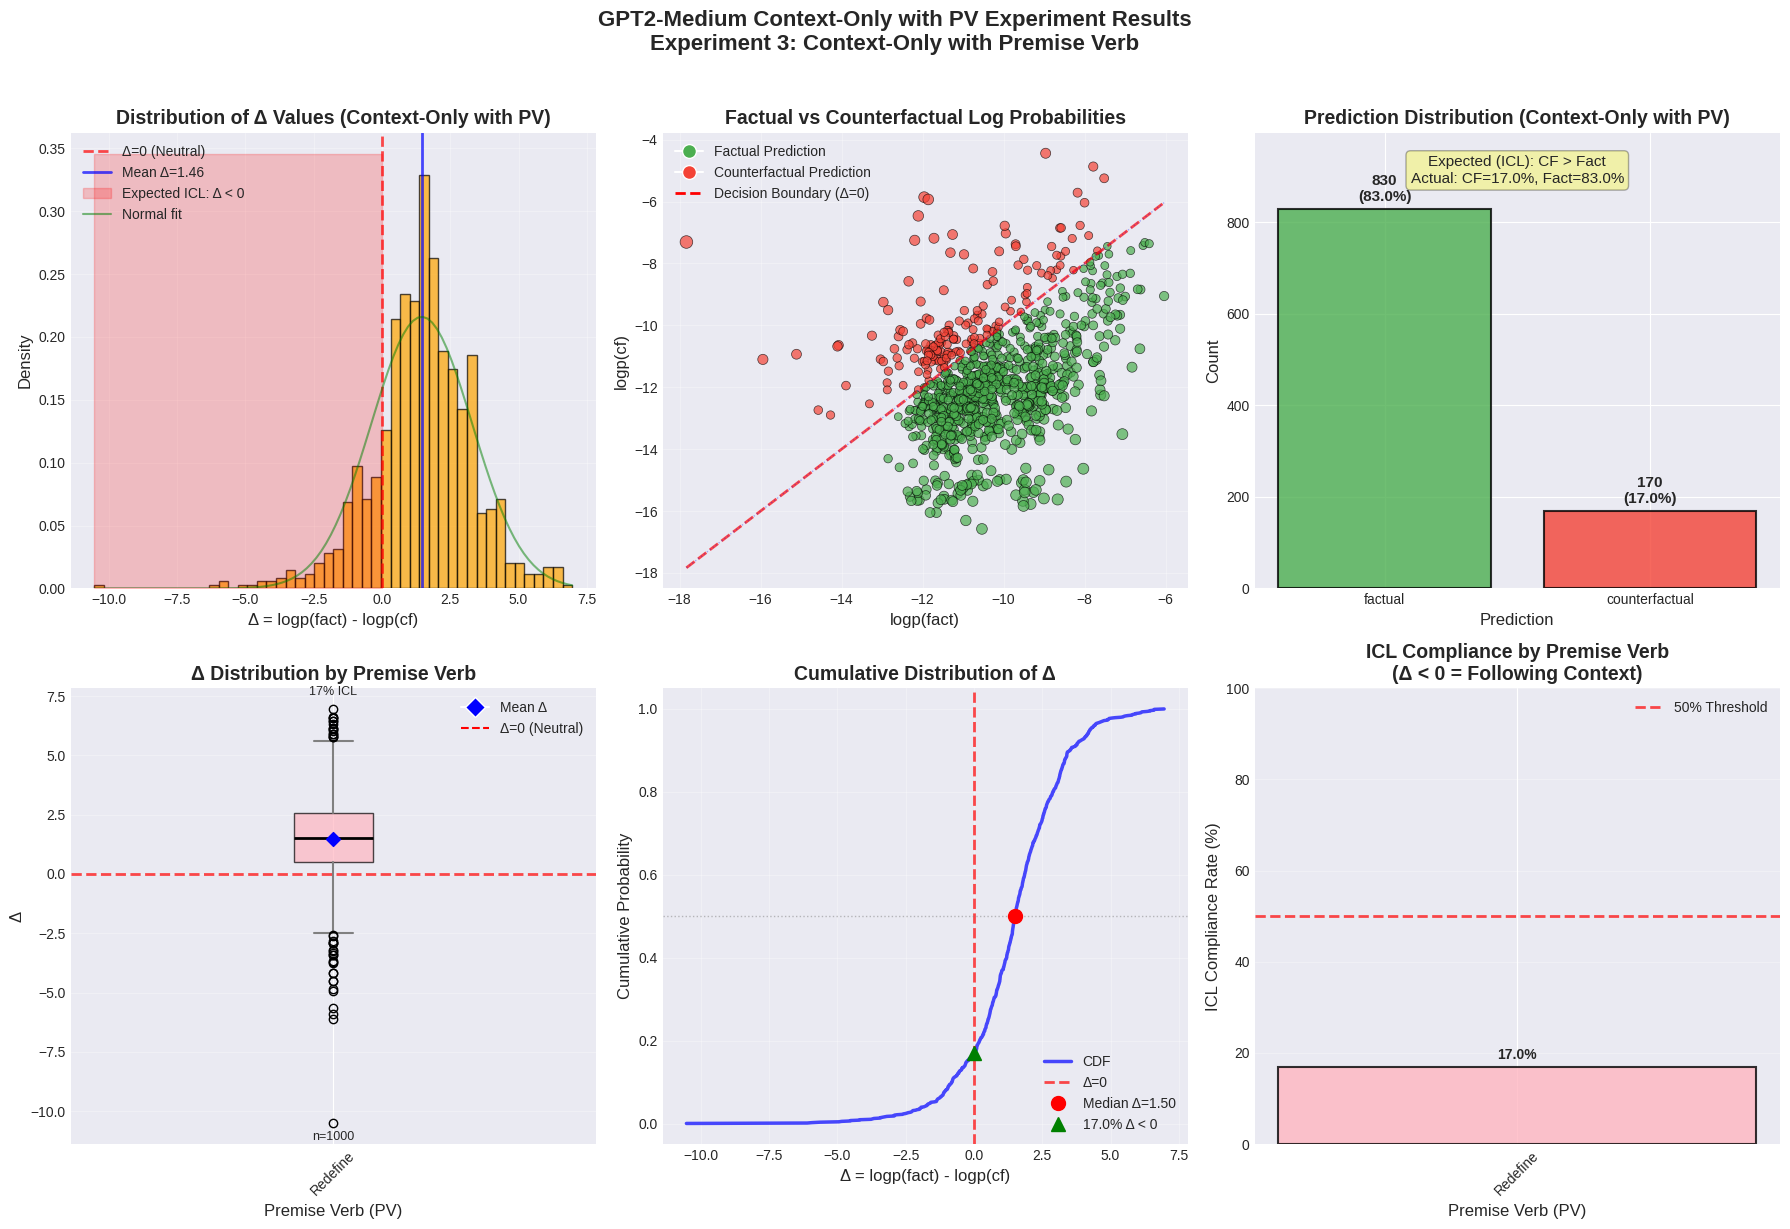

✓ Summary plot saved as gpt2_medium_context_only_pv_summary_20260205_093939.png


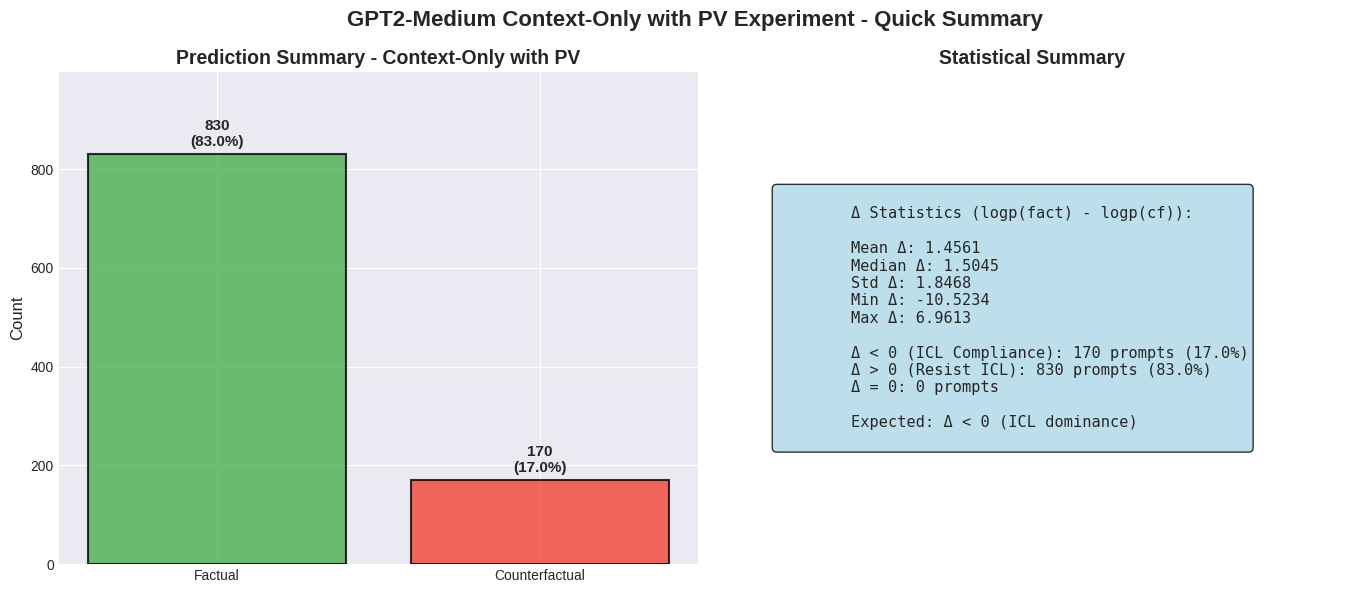

✓ Results saved to gpt2_medium_context_only_pv_results_20260205_093939.json
✓ CSV results saved to gpt2_medium_context_only_pv_results_20260205_093939.csv
⚠ Baseline results file not found
⚠ Context-Only results file not found
No comparison data available

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: factual
  logp(fact): -11.3622
  logp(cf): -11.5457
  Δ: 0.1835
  Prompt preview: IMPORTANT: You MUST answer using ONLY the information provided below. Do NOT use your own knowledge. Do NOT correct the text even if it contradicts re...
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question:

In [2]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class ContextOnlyPVResult:
    """Stores results for a single prompt in Context-Only with PV condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class ContextOnlyPVExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Context-Only with PV prompt template (Experiment 3)
        self.context_only_pv_template = (
            "IMPORTANT: You MUST answer using ONLY the information provided below. "
            "Do NOT use your own knowledge. Do NOT correct the text even if it contradicts reality. "
            "Treat the text as fully true.\n\n"
            "Instruction: {PV}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize GPT2-Medium model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # Load with appropriate settings for GPT2-Medium
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                n_devices=1
            )
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Print model info
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Hidden size: {self.model.cfg.d_model}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt (if available)
                if 'premise_verb' in item:
                    premise_verb = item['premise_verb']
                elif 'prompt' in item and ':' in item['prompt']:
                    premise_verb = item['prompt'].split(':')[0].strip()
                else:
                    premise_verb = 'Unknown'
                    
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
                elif premise_verb != 'Unknown':
                    # Add new verb to list if not already present
                    self.premise_verbs.append(premise_verb)
                    self.verb_groups[premise_verb] = [item]
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_grouped = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups.get(verb, []))
                if count > 0:
                    print(f"  {verb:15}: {count:4d} prompts")
                    total_grouped += count
            
            if total_grouped < len(self.dataset):
                print(f"  {'Uncategorized':15}: {len(self.dataset) - total_grouped:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            verb = prompt.split(':')[0].strip()
            # Check if it's one of our premise verbs
            if verb in self.premise_verbs:
                return verb
            else:
                # Try to normalize
                verb_lower = verb.lower()
                for pv in self.premise_verbs:
                    if pv.lower() in verb_lower:
                        return pv
                return verb  # Return original verb if no match
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb and context
        if "created" in prompt.lower() or "made" in prompt.lower():
            return f"{subject} was created by {target_new}"
        elif "invented" in prompt.lower():
            return f"{subject} was invented by {target_new}"
        elif "developed" in prompt.lower():
            return f"{subject} was developed by {target_new}"
        elif "written" in prompt.lower() or "author" in prompt.lower():
            return f"{subject} was written by {target_new}"
        elif "composed" in prompt.lower():
            return f"{subject} was composed by {target_new}"
        elif "painted" in prompt.lower():
            return f"{subject} was painted by {target_new}"
        elif "directed" in prompt.lower():
            return f"{subject} was directed by {target_new}"
        elif "designed" in prompt.lower():
            return f"{subject} was designed by {target_new}"
        elif "founded" in prompt.lower():
            return f"{subject} was founded by {target_new}"
        elif "discovered" in prompt.lower():
            return f"{subject} was discovered by {target_new}"
        else:
            # Generic construction based on premise verb
            if premise_verb == 'Redefine':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Assess':
                return f"{subject} is created by {target_new}"
            elif premise_verb == 'Fact Check':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Review':
                return f"{subject} is a product of {target_new}"
            elif premise_verb == 'Validate':
                return f"{subject} was made by {target_new}"
            elif premise_verb == 'Verify':
                return f"{subject} is made by {target_new}"
            else:
                return f"{subject} was created by {target_new}"
    
    def create_context_only_pv_prompt(self, premise_verb: str, counterfactual_statement: str, question: str) -> str:
        """Create context-only prompt with PV instruction"""
        return self.context_only_pv_template.format(
            PV=premise_verb,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        # Clean the answer and tokenize
        answer = answer.strip()
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        if not target_tokens:
            return -float('inf')
        
        try:
            # Tokenize prompt
            prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
            
            # Combine prompt and target tokens
            all_tokens = prompt_tokens + target_tokens
            
            # Convert to tensor
            tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
            
            with torch.no_grad():
                # Get logits for all positions
                logits = self.model(tokens_tensor)
                
                # Compute log probabilities using log_softmax
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Extract log probabilities for target tokens
                total_logp = 0.0
                
                for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                    # i-1 because logits are shifted by 1 (predicting next token)
                    if i-1 >= 0 and i-1 < log_probs.shape[1]:
                        token_logp = log_probs[0, i-1, token_id].item()
                        total_logp += token_logp
                    else:
                        # If position is out of bounds, skip
                        continue
            
            return total_logp
            
        except Exception as e:
            print(f"Error computing log probabilities: {e}")
            return -float('inf')
    
    def process_item(self, item: Dict) -> Optional[ContextOnlyPVResult]:
        """Process a single dataset item for Context-Only with PV condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item.get('subject', 'Unknown')
            original_prompt = item.get('prompt', '')
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create context-only with PV prompt
            prompt = self.create_context_only_pv_prompt(premise_verb, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = ContextOnlyPVResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            print(f"Item: {item}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, 
                      batch_size: int = 16):
        """Run the Context-Only with PV experiment with batching for efficiency"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 3: CONTEXT-ONLY WITH PREMISE VERB - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            if verb in self.verb_groups:
                all_items.extend(self.verb_groups[verb])
        
        # Also add items not in verb groups
        for item in self.dataset:
            if item not in all_items:
                all_items.append(item)
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process items in batches for efficiency
        self.results = []
        for i in tqdm(range(0, len(all_items), batch_size), desc="Processing batches"):
            batch_items = all_items[i:i+batch_size]
            batch_results = []
            
            for item in batch_items:
                result = self.process_item(item)
                if result:
                    batch_results.append(result)
            
            self.results.extend(batch_results)
            
            # Clear memory periodically
            if i % (batch_size * 10) == 0 and i > 0:
                self.clear_memory()
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Context-Only with PV condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = (counterfactual_count / total) * 100 if total > 0 else 0
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results]) if self.results else 0
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        
        # Calculate standard deviations
        std_factual_logp = np.std([r.factual_logp for r in self.results]) if self.results else 0
        std_counterfactual_logp = np.std([r.counterfactual_logp for r in self.results]) if self.results else 0
        std_delta = np.std([r.delta for r in self.results]) if self.results else 0
        
        # Count how many follow expected pattern (negative delta)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        negative_delta_percent = (negative_delta_count / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 3 RESULTS - CONTEXT-ONLY WITH PREMISE VERB")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities (mean ± std):")
        print(f"  logp(fact): {avg_factual_logp:.4f} ± {std_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f} ± {std_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} ± {std_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Context-Only with PV condition, we expect:")
        print("  - Similar or stronger ICL dominance than Experiment 2")
        print("  - PV may strengthen the instruction to use only provided context")
        print("  - Negative Δ values (logp(cf) > logp(fact)) expected")
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with negative Δ (following ICL): {negative_delta_count}/{total} ({negative_delta_percent:.1f}%)")
        print(f"  Prompts with positive Δ (resisting ICL): {sum(1 for r in self.results if r.delta > 0)}/{total} ({100-negative_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Std Δ':<10} {'ICL %':<10}")
        print("-" * 90)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_delta_std = np.std([r.delta for r in verb_results]) if verb_results else 0
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100 if verb_total > 0 else 0
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'std_delta': verb_delta_std,
                    'follows_icl_pct': verb_follows_icl
                }
                
                follows_icl_symbol = "✓" if verb_delta_avg < 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta_avg:<10.4f} "
                      f"{verb_delta_std:<10.4f} {verb_follows_icl:>9.1f}% {follows_icl_symbol}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Context-Only with PV experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='orange', edgecolor='black', density=True)
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, linewidth=2,
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (negative delta for ICL)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='red',
                               label='Expected ICL: Δ < 0')
        
        # Add normal distribution overlay
        try:
            from scipy.stats import norm
            mu, sigma = np.mean(deltas), np.std(deltas)
            x = np.linspace(min(deltas), max(deltas), 100)
            axes[0, 0].plot(x, norm.pdf(x, mu, sigma), 'g-', alpha=0.5, linewidth=1.5, label='Normal fit')
        except ImportError:
            pass
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[0, 0].set_ylabel('Density', fontsize=12)
        axes[0, 0].set_title('Distribution of Δ Values (Context-Only with PV)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['#4CAF50' if r.prediction == 'factual' else '#F44336' for r in self.results]
        sizes = [30 + abs(r.delta) * 5 for r in self.results]  # Size based on |Δ|
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps,
                                     c=colors, s=sizes, alpha=0.7,
                                     edgecolors='black', linewidth=0.5)
        
        # Add diagonal line (decision boundary)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'r--', alpha=0.7, linewidth=2, label='Decision Boundary (Δ=0)')
        
        # Add perfect prediction line (y=x)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'b:', alpha=0.3, linewidth=1, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)', fontsize=12)
        axes[0, 1].set_ylabel('logp(cf)', fontsize=12)
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities', fontsize=14, fontweight='bold')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50',
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#F44336',
                  markersize=10, label='Counterfactual Prediction'),
            Line2D([0], [0], color='r', linestyle='--', linewidth=2, label='Decision Boundary (Δ=0)')
        ]
        axes[0, 1].legend(handles=legend_elements, fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['#4CAF50' if p == 'factual' else '#F44336' for p in prediction_counts.index]
        
        bars = axes[0, 2].bar(prediction_counts.index, prediction_counts.values,
                             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('Prediction', fontsize=12)
        axes[0, 2].set_ylabel('Count', fontsize=12)
        axes[0, 2].set_title('Prediction Distribution (Context-Only with PV)', fontsize=14, fontweight='bold')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (bar, (pred, count)) in enumerate(zip(bars, prediction_counts.items())):
            percentage = (count / total) * 100
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                           f'{count}\n({percentage:.1f}%)',
                           ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add expected direction annotation
        expected_text = f"Expected (ICL): CF > Fact\nActual: CF={cf_pct:.1f}%, Fact={factual_pct:.1f}%"
        axes[0, 2].text(0.5, 0.95, expected_text, transform=axes[0, 2].transAxes,
                       ha='center', va='top', fontsize=11,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        axes[0, 2].set_ylim(0, max(prediction_counts.values) * 1.2)
        
        # Plot 4: Δ distribution by premise verb (if available)
        premise_deltas = {}
        premise_means = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                premise_means[verb] = np.mean(verb_deltas)
                
                # Calculate compliance percentage
                negative_delta_count = sum(1 for d in verb_deltas if d < 0)
                premise_compliance[verb] = (negative_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create boxplot
            positions = range(1, len(premise_deltas) + 1)
            box_data = [premise_deltas[verb] for verb in premise_deltas.keys()]
            
            bp = axes[1, 0].boxplot(box_data, positions=positions,
                                    labels=premise_deltas.keys(), patch_artist=True,
                                    medianprops=dict(color='black', linewidth=2),
                                    whiskerprops=dict(color='gray', linewidth=1.5),
                                    capprops=dict(color='gray', linewidth=1.5))
            
            # Color boxes based on median Δ
            for i, (patch, verb) in enumerate(zip(bp['boxes'], premise_deltas.keys())):
                median_val = np.median(premise_deltas[verb])
                # Green if median < 0 (following ICL), red if median > 0 (not following ICL)
                patch.set_facecolor('#90EE90' if median_val < 0 else '#FFB6C1')
                patch.set_alpha(0.7)
                
                # Add mean as a point
                mean_val = premise_means[verb]
                axes[1, 0].scatter(positions[i], mean_val, color='blue', s=50, zorder=3, marker='D')
                
                # Add compliance percentage
                compliance = premise_compliance.get(verb, 0)
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[1] * 0.95,
                               f'{compliance:.0f}% ICL',
                               ha='center', va='bottom', fontsize=9)
            
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
            axes[1, 0].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 0].set_ylabel('Δ', fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3, axis='y')
            
            # Add legend for mean marker
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='D', color='w', markerfacecolor='blue',
                      markersize=10, label='Mean Δ'),
                Line2D([0], [0], color='red', linestyle='--', label='Δ=0 (Neutral)')
            ]
            axes[1, 0].legend(handles=legend_elements, fontsize=10, loc='upper right')
            
            # Add sample size annotations
            for i, verb in enumerate(premise_deltas.keys()):
                count = len(premise_deltas[verb])
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[0] * 0.95,
                               f'n={count}', ha='center', va='top', fontsize=9)
        else:
            axes[1, 0].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
        
        # Plot 5: Cumulative distribution of Δ
        sorted_deltas = np.sort(deltas)
        cumulative = np.arange(1, len(sorted_deltas) + 1) / len(sorted_deltas)
        
        axes[1, 1].plot(sorted_deltas, cumulative, 'b-', linewidth=2.5, alpha=0.7, label='CDF')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        # Find and mark median
        median_delta = np.median(deltas)
        median_idx = np.searchsorted(sorted_deltas, median_delta)
        axes[1, 1].plot(median_delta, cumulative[median_idx], 'ro', markersize=10,
                       label=f'Median Δ={median_delta:.2f}')
        
        # Mark the percentage of negative deltas
        negative_delta_pct = sum(1 for d in deltas if d < 0) / len(deltas) * 100
        if any(d < 0 for d in deltas):
            max_negative_delta = max(d for d in deltas if d < 0)
            negative_idx = np.searchsorted(sorted_deltas, max_negative_delta)
            negative_pct = cumulative[negative_idx]
            axes[1, 1].plot(max_negative_delta, negative_pct, 'g^', markersize=10,
                           label=f'{negative_delta_pct:.1f}% Δ < 0')
        
        axes[1, 1].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
        axes[1, 1].set_title('Cumulative Distribution of Δ', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=10, loc='lower right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Bar chart of ICL compliance by premise verb
        if premise_compliance:
            verbs = list(premise_compliance.keys())
            compliance_rates = [premise_compliance[verb] for verb in verbs]
            
            # Sort by compliance rate
            sorted_indices = np.argsort(compliance_rates)
            verbs_sorted = [verbs[i] for i in sorted_indices]
            compliance_sorted = [compliance_rates[i] for i in sorted_indices]
            
            bars = axes[1, 2].bar(range(len(verbs_sorted)), compliance_sorted, 
                                 color=['#90EE90' if rate > 50 else '#FFB6C1' for rate in compliance_sorted],
                                 alpha=0.8, edgecolor='black', linewidth=1.5)
            
            axes[1, 2].axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% Threshold')
            axes[1, 2].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 2].set_ylabel('ICL Compliance Rate (%)', fontsize=12)
            axes[1, 2].set_title('ICL Compliance by Premise Verb\n(Δ < 0 = Following Context)', fontsize=14, fontweight='bold')
            axes[1, 2].set_xticks(range(len(verbs_sorted)))
            axes[1, 2].set_xticklabels(verbs_sorted, rotation=45)
            axes[1, 2].set_ylim(0, 100)
            axes[1, 2].legend(fontsize=10)
            axes[1, 2].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        else:
            axes[1, 2].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('ICL Compliance by Premise Verb', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Context-Only with PV Experiment Results\nExperiment 3: Context-Only with Premise Verb',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_context_only_pv_experiment_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Plot saved as {filename}")
        plt.show()
        
        # Also create a summary figure
        self.create_summary_figure(deltas, factual_logps, counterfactual_logps, predictions)
    
    def create_summary_figure(self, deltas, factual_logps, counterfactual_logps, predictions):
        """Create a simplified summary figure"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Summary bar chart
        factual_count = predictions.count('factual')
        cf_count = len(predictions) - factual_count
        
        bars = axes[0].bar(['Factual', 'Counterfactual'], [factual_count, cf_count],
                          color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Prediction Summary - Context-Only with PV', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        total = len(predictions)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{height}\n({percentage:.1f}%)',
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        axes[0].set_ylim(0, max(factual_count, cf_count) * 1.2)
        
        # Δ statistics box
        negative_delta_count = sum(1 for d in deltas if d < 0)
        negative_delta_pct = (negative_delta_count / len(deltas)) * 100 if deltas else 0
        
        stats_text = f"""
        Δ Statistics (logp(fact) - logp(cf)):
        
        Mean Δ: {np.mean(deltas):.4f}
        Median Δ: {np.median(deltas):.4f}
        Std Δ: {np.std(deltas):.4f}
        Min Δ: {np.min(deltas):.4f}
        Max Δ: {np.max(deltas):.4f}
        
        Δ < 0 (ICL Compliance): {negative_delta_count} prompts ({negative_delta_pct:.1f}%)
        Δ > 0 (Resist ICL): {sum(1 for d in deltas if d > 0)} prompts ({100-negative_delta_pct:.1f}%)
        Δ = 0: {sum(1 for d in deltas if d == 0)} prompts
        
        Expected: Δ < 0 (ICL dominance)
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center', transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1].axis('off')
        axes[1].set_title('Statistical Summary', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Context-Only with PV Experiment - Quick Summary',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_context_only_pv_summary_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Summary plot saved as {filename}")
        plt.show()
    
    def compare_with_other_experiments(self, baseline_path: str = None, 
                                      context_only_path: str = None):
        """Compare Context-Only PV results with other experiments"""
        import glob, os
        
        # Try to find the most recent baseline results
        if baseline_path is None:
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_path = baseline_files[0]
        
        # Try to find the most recent context-only results
        if context_only_path is None:
            context_only_files = glob.glob("gpt2_medium_context_only_results_*.json")
            if context_only_files:
                context_only_files.sort(key=os.path.getmtime, reverse=True)
                context_only_path = context_only_files[0]
        
        comparisons = []
        
        try:
            # Load baseline results
            if baseline_path and os.path.exists(baseline_path):
                with open(baseline_path, 'r') as f:
                    baseline_data = json.load(f)
                baseline_summary = baseline_data['summary']
                comparisons.append(('Baseline', baseline_summary))
            else:
                print(f"⚠ Baseline results file not found")
        except Exception as e:
            print(f"✗ Error loading baseline results: {e}")
        
        try:
            # Load context-only results
            if context_only_path and os.path.exists(context_only_path):
                with open(context_only_path, 'r') as f:
                    context_only_data = json.load(f)
                context_only_summary = context_only_data['summary']
                comparisons.append(('Context-Only', context_only_summary))
            else:
                print(f"⚠ Context-Only results file not found")
        except Exception as e:
            print(f"✗ Error loading context-only results: {e}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        negative_delta_percent = (sum(1 for r in self.results if r.delta < 0) / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*70}")
        print("COMPARISON WITH OTHER EXPERIMENTS (GPT2-Medium)")
        print(f"{'='*70}")
        print(f"\n{'Metric':<30} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<15}", end="")
        print(f"{'Context-Only+PV':<15}")
        print("-" * (30 + 15 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<15.1f}", end="")
        print(f"{factual_percent:<15.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<15.1f}", end="")
        print(f"{counterfactual_percent:<15.1f}")
        
        # Average Δ
        print(f"{'Avg Δ (logp(fact) - logp(cf))':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<15.4f}", end="")
        print(f"{avg_delta:<15.4f}")
        
        # % Following ICL (negative delta)
        print(f"{'% Following ICL (Δ < 0)':<30} ", end="")
        for exp_name, summary in comparisons:
            ict_percent = summary.get('negative_delta_percent', 0)
            if ict_percent == 0 and exp_name == 'Baseline':
                # For baseline, calculate from Δ > 0
                if 'avg_delta' in summary:
                    ict_percent = 100 if summary['avg_delta'] < 0 else 0
            print(f"{ict_percent:<15.1f}", end="")
        print(f"{negative_delta_percent:<15.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Expected progression: Baseline → Context-Only → Context-Only+PV")
        print(f"  (Increasing ICL dominance, decreasing factual %, decreasing Δ)")
        
        # Check if PV improves ICL compliance compared to Context-Only
        if 'Context-Only' in [name for name, _ in comparisons]:
            context_only_idx = [name for name, _ in comparisons].index('Context-Only')
            context_only_negative = comparisons[context_only_idx][1].get('negative_delta_percent', 0)
            
            improvement = negative_delta_percent - context_only_negative
            print(f"\nEffect of adding PV (vs Context-Only):")
            print(f"  Change in ICL compliance: {improvement:+.1f}%")
            print(f"  PV {'strengthens' if improvement > 0 else 'weakens'} ICL instructions")
            
            # Calculate effect size
            if total > 0 and 'total_prompts' in comparisons[context_only_idx][1]:
                context_only_summary = comparisons[context_only_idx][1]
                context_total = context_only_summary.get('total_prompts', total)
                context_factual = context_only_summary.get('factual_percent', 0) * context_total / 100
                pv_factual = factual_percent * total / 100
                
                # Cohen's h for proportions
                import math
                phi1 = 2 * math.asin(math.sqrt(context_factual / context_total))
                phi2 = 2 * math.asin(math.sqrt(pv_factual / total))
                cohens_h = abs(phi1 - phi2)
                
                print(f"\nEffect Size (Cohen's h): {cohens_h:.3f}")
                print(f"  Small effect: h < 0.2")
                print(f"  Medium effect: 0.2 ≤ h < 0.5")
                print(f"  Large effect: h ≥ 0.5")
    
    def save_results(self, output_path: str = None):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Create default output path if not provided
        if output_path is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_path = f'gpt2_medium_context_only_pv_results_{timestamp}.json'
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_negative_delta = sum(1 for r in verb_results if r.delta < 0)
                verb_follows_icl = (verb_negative_delta / verb_total) * 100 if verb_total > 0 else 0
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'follows_icl_percent': verb_follows_icl
                }
        
        # Calculate overall summary statistics
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        total = len(self.results)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        
        # Save to file
        output_data = {
            'experiment': 'Experiment 3: Context-Only with Premise Verb',
            'model': self.model_name,
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_prompts': total,
            'condition': 'Context-Only with Premise Verb',
            'prompt_template': self.context_only_pv_template,
            'results': serializable_results,
            'summary': {
                'factual_count': factual_count,
                'counterfactual_count': total - factual_count,
                'factual_percent': (factual_count / total) * 100 if total > 0 else 0,
                'counterfactual_percent': ((total - factual_count) / total) * 100 if total > 0 else 0,
                'avg_factual_logp': float(np.mean([r.factual_logp for r in self.results]) if self.results else 0),
                'avg_counterfactual_logp': float(np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'avg_delta': float(np.mean([r.delta for r in self.results]) if self.results else 0),
                'std_factual_logp': float(np.std([r.factual_logp for r in self.results]) if self.results else 0),
                'std_counterfactual_logp': float(np.std([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'std_delta': float(np.std([r.delta for r in self.results]) if self.results else 0),
                'negative_delta_count': negative_delta_count,
                'negative_delta_percent': (negative_delta_count / total) * 100 if total > 0 else 0,
            },
            'premise_verb_summary': verb_summary
        }
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
        
        # Also save a CSV version for easier analysis
        csv_path = output_path.replace('.json', '.csv')
        df_data = []
        for r in self.results:
            df_data.append({
                'subject': r.subject,
                'question': r.question,
                'premise_verb': r.premise_verb,
                'counterfactual_statement': r.counterfactual_statement,
                'factual_answer': r.factual_answer,
                'counterfactual_answer': r.counterfactual_answer,
                'factual_logp': r.factual_logp,
                'counterfactual_logp': r.counterfactual_logp,
                'delta': r.delta,
                'prediction': r.prediction
            })
        
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV results saved to {csv_path}")

# Example usage for GPT2-Medium
if __name__ == "__main__":
    # Configuration for GPT2-Medium
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path
    MODEL_NAME = "gpt2-medium"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    BATCH_SIZE = 16  # Adjust based on available GPU memory
    
    print(f"Running Experiment 3: Context-Only with Premise Verb with {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Run experiment
    experiment = ContextOnlyPVExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with other experiments
    experiment.compare_with_other_experiments()
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            
            # Show first 150 chars of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"  Prompt preview: {prompt_preview}")
            print("-" * 90)
    
    print("\n✅ Experiment 3 (Context-Only with PV) completed successfully!")

/home/animesh-lohar-2711/anaconda3/envs/comp_mech_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running Experiment 4: Memory-Only (Parametric Memory Dominant) with gpt2-medium
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000
Batch size: 16

EXPERIMENT 4: MEMORY-ONLY PROMPTS (PARAMETRIC MEMORY DOMINANT) - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Parameters: 406,236,241
  Layers: 24
  Hidden size: 1024
  Heads: 16
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine       : 4329 prompts
  Assess         : 4924 prompts
  Fact Check     : 4916 prompts
  Review         : 4942 prompts
  Validate       : 4915 prompts
  Verify         : 4927 prompts

Processing 1000 prompts...


Processing batches: 100%|██████████| 63/63 [01:02<00:00,  1.01it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 4 RESULTS - MEMORY-ONLY (PARAMETRIC MEMORY DOMINANT)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 817 (81.7%)
  Counterfactual predictions: 183 (18.3%)

Average Log Probabilities (mean ± std):
  logp(fact): -10.3199 ± 1.4580
  logp(cf):   -11.6970 ± 1.8544
  Δ:          1.3771 ± 1.8875 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only condition (Parametric Memory Dominant), we expect:
  - Higher factual percentage than baseline
  - Higher factual percentage than Context-Only conditions
  - Positive Δ values (logp(fact) > logp(cf))
  - Strong reliance on parametric memory

Pattern Compliance:
  Prompts with positive Δ (following memory): 817/1000 (81.7%)
  Prompts with negative Δ (following context): 183/1000 (18.3%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Std Δ      Memory %  
-------------------------------------------------------------------

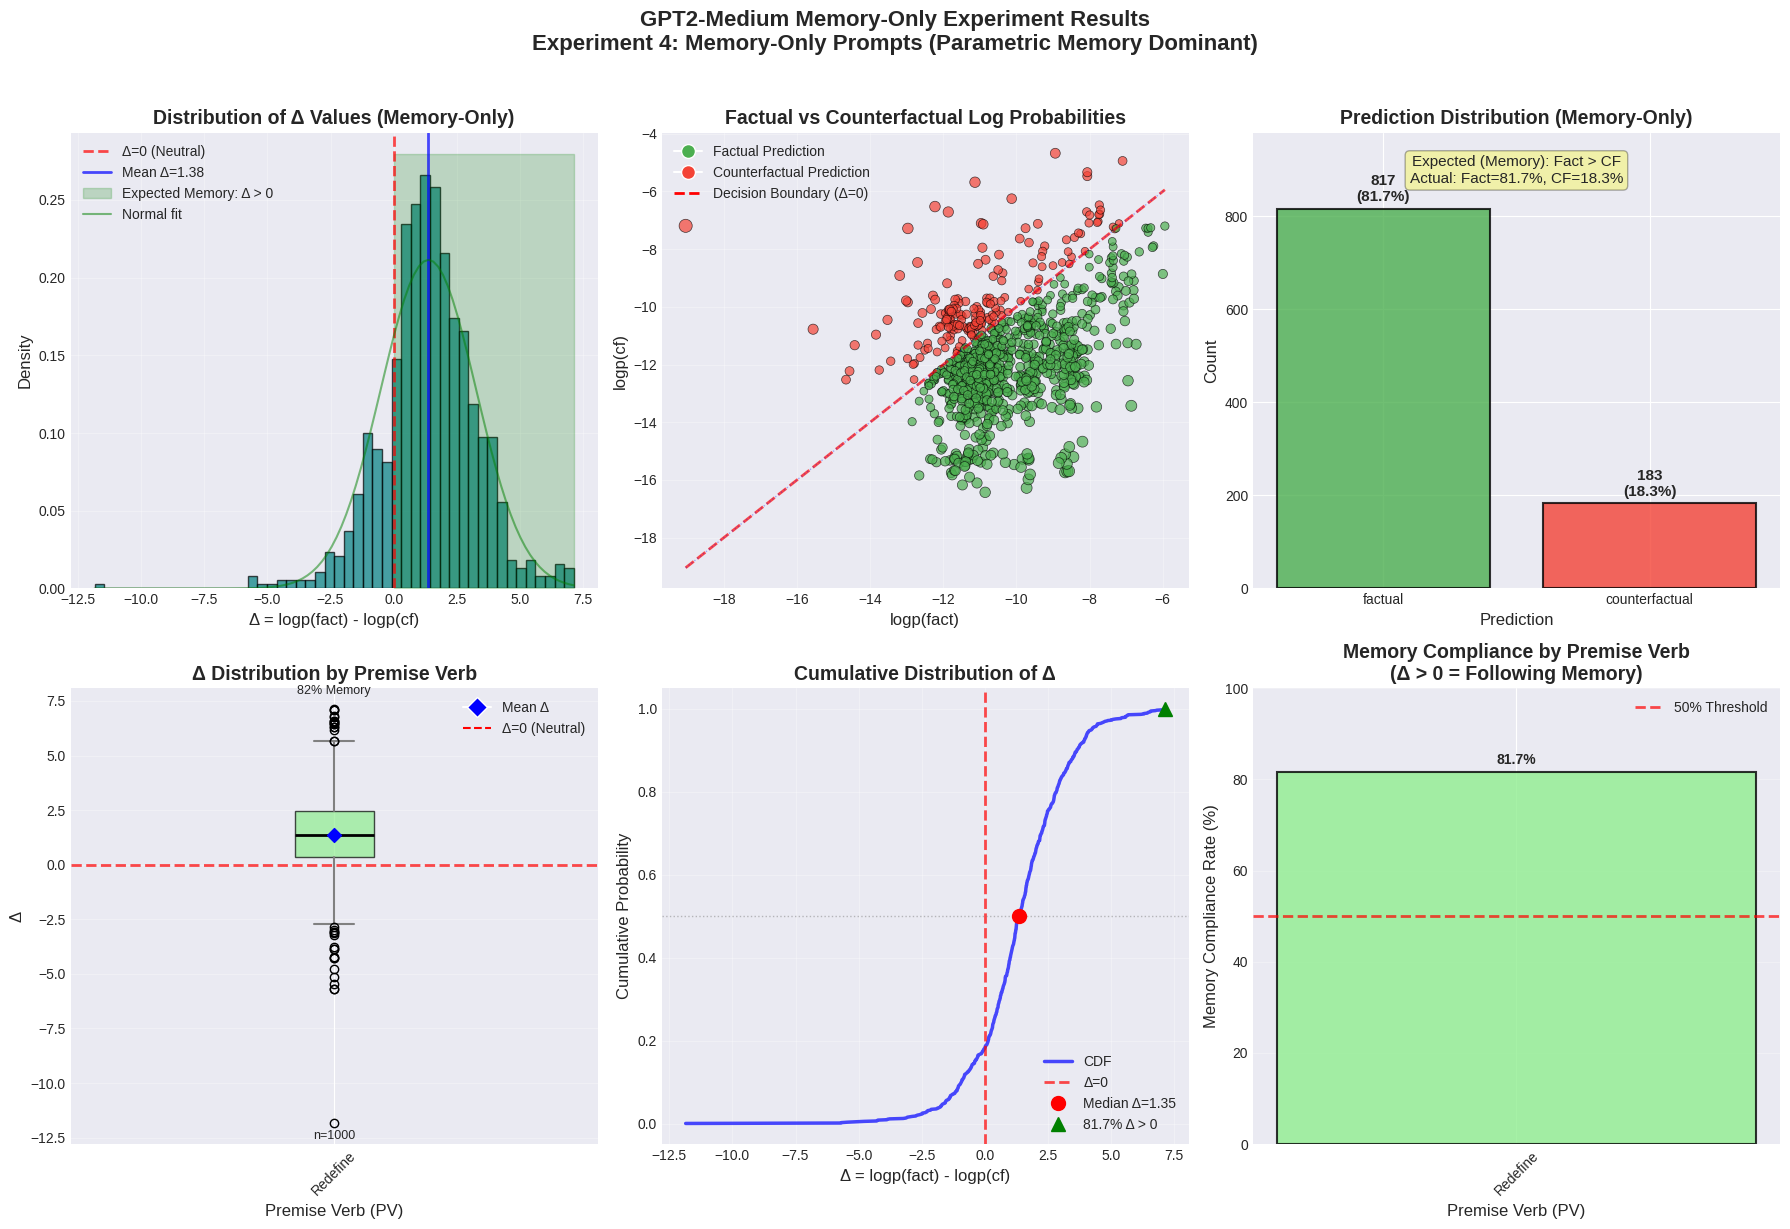

✓ Summary plot saved as gpt2_medium_memory_only_summary_20260205_094347.png


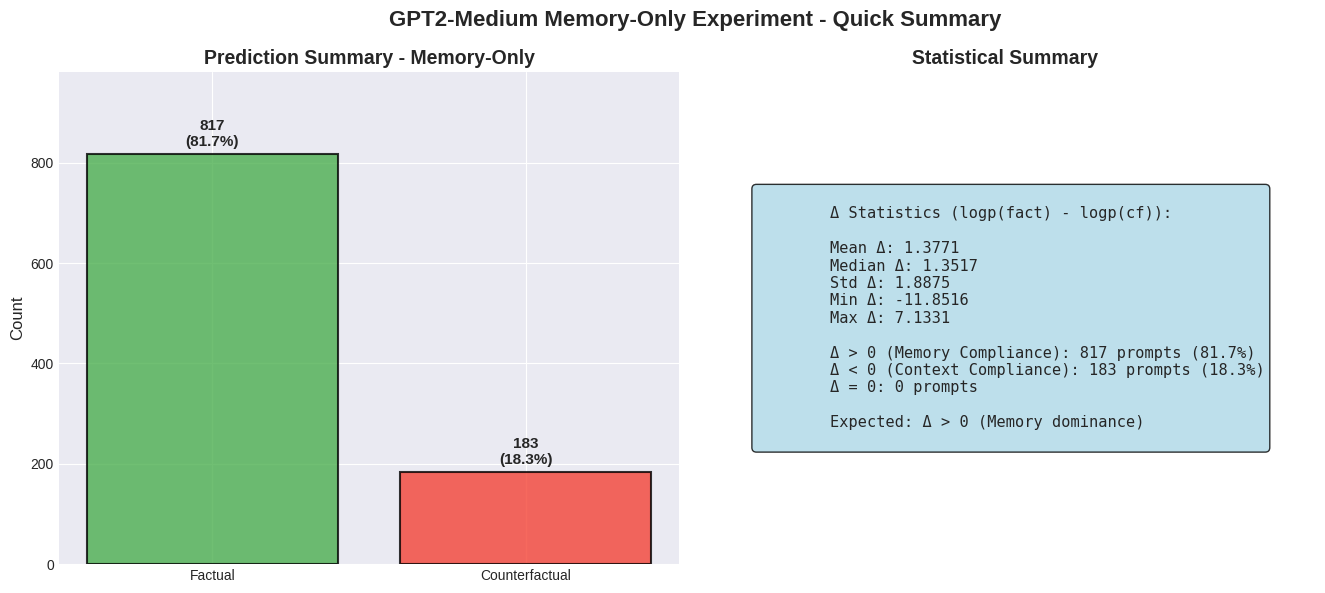

✓ Results saved to gpt2_medium_memory_only_results_20260205_094348.json
✓ CSV results saved to gpt2_medium_memory_only_results_20260205_094348.csv
⚠ Baseline results file not found
⚠ Context-Only results file not found
⚠ Context-Only+PV results file not found
No comparison data available
✓ Summary visualization saved as gpt2_medium_experiment_summary_comparison_20260205_094348.png


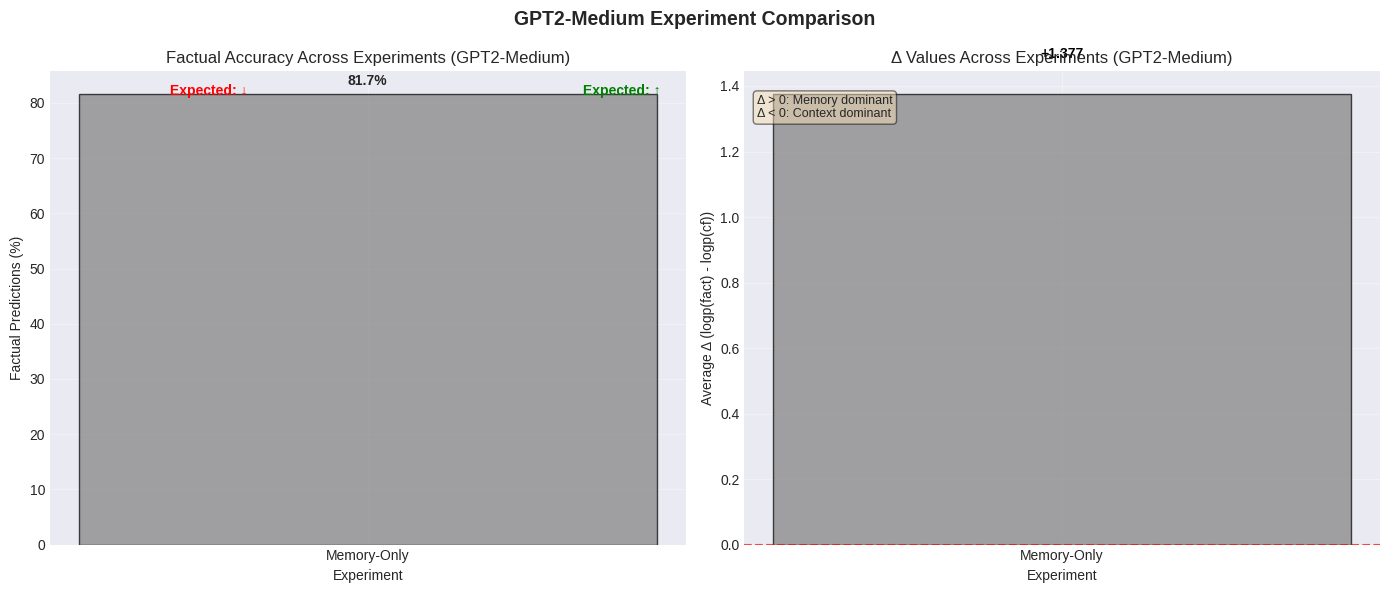


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: counterfactual
  logp(fact): -11.4840
  logp(cf): -11.1643
  Δ: -0.3197
  Prompt preview: IMPORTANT: Answer using ONLY your own factual world knowledge. Ignore any incorrect or fictional statements below. The following statement is FALSE an...
------------------------------------------------------------------------------------------

Example 2:
  Subject: Honda Super Cub
  Premise Verb (PV): Redefine
  Question: What company produces the Honda Super Cub?
  Counterfactual Statement (CF): 'Honda Super Cub, produced by Chevrolet. What company produces the Honda Super Cub? Answer:'
  Factual answer: ' Honda'
  Counterfactual answer: ' Chevrolet'
  Prediction:

In [1]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
import glob
import os
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyResult:
    """Stores results for a single prompt in Memory-Only condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only prompt template (Strong Instruction) - Experiment 4
        self.memory_only_template = (
            "IMPORTANT: Answer using ONLY your own factual world knowledge. "
            "Ignore any incorrect or fictional statements below. "
            "The following statement is FALSE and must NOT be used: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize GPT2-Medium model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # Load with appropriate settings for GPT2-Medium
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                n_devices=1
            )
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Print model info
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Hidden size: {self.model.cfg.d_model}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt (if available)
                if 'premise_verb' in item:
                    premise_verb = item['premise_verb']
                elif 'prompt' in item and ':' in item['prompt']:
                    premise_verb = item['prompt'].split(':')[0].strip()
                else:
                    premise_verb = 'Unknown'
                    
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
                elif premise_verb != 'Unknown':
                    # Add new verb to list if not already present
                    self.premise_verbs.append(premise_verb)
                    self.verb_groups[premise_verb] = [item]
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_grouped = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups.get(verb, []))
                if count > 0:
                    print(f"  {verb:15}: {count:4d} prompts")
                    total_grouped += count
            
            if total_grouped < len(self.dataset):
                print(f"  {'Uncategorized':15}: {len(self.dataset) - total_grouped:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            verb = prompt.split(':')[0].strip()
            # Check if it's one of our premise verbs
            if verb in self.premise_verbs:
                return verb
            else:
                # Try to normalize
                verb_lower = verb.lower()
                for pv in self.premise_verbs:
                    if pv.lower() in verb_lower:
                        return pv
                return verb  # Return original verb if no match
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb and context
        if "created" in prompt.lower() or "made" in prompt.lower():
            return f"{subject} was created by {target_new}"
        elif "invented" in prompt.lower():
            return f"{subject} was invented by {target_new}"
        elif "developed" in prompt.lower():
            return f"{subject} was developed by {target_new}"
        elif "written" in prompt.lower() or "author" in prompt.lower():
            return f"{subject} was written by {target_new}"
        elif "composed" in prompt.lower():
            return f"{subject} was composed by {target_new}"
        elif "painted" in prompt.lower():
            return f"{subject} was painted by {target_new}"
        elif "directed" in prompt.lower():
            return f"{subject} was directed by {target_new}"
        elif "designed" in prompt.lower():
            return f"{subject} was designed by {target_new}"
        elif "founded" in prompt.lower():
            return f"{subject} was founded by {target_new}"
        elif "discovered" in prompt.lower():
            return f"{subject} was discovered by {target_new}"
        else:
            # Generic construction based on premise verb
            if premise_verb == 'Redefine':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Assess':
                return f"{subject} is created by {target_new}"
            elif premise_verb == 'Fact Check':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Review':
                return f"{subject} is a product of {target_new}"
            elif premise_verb == 'Validate':
                return f"{subject} was made by {target_new}"
            elif premise_verb == 'Verify':
                return f"{subject} is made by {target_new}"
            else:
                return f"{subject} was created by {target_new}"
    
    def create_memory_only_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create memory-only prompt with strong instructions"""
        return self.memory_only_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        # Clean the answer and tokenize
        answer = answer.strip()
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        if not target_tokens:
            return -float('inf')
        
        try:
            # Tokenize prompt
            prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
            
            # Combine prompt and target tokens
            all_tokens = prompt_tokens + target_tokens
            
            # Convert to tensor
            tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
            
            with torch.no_grad():
                # Get logits for all positions
                logits = self.model(tokens_tensor)
                
                # Compute log probabilities using log_softmax
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Extract log probabilities for target tokens
                total_logp = 0.0
                
                for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                    # i-1 because logits are shifted by 1 (predicting next token)
                    if i-1 >= 0 and i-1 < log_probs.shape[1]:
                        token_logp = log_probs[0, i-1, token_id].item()
                        total_logp += token_logp
                    else:
                        # If position is out of bounds, skip
                        continue
            
            return total_logp
            
        except Exception as e:
            print(f"Error computing log probabilities: {e}")
            return -float('inf')
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyResult]:
        """Process a single dataset item for Memory-Only condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item.get('subject', 'Unknown')
            original_prompt = item.get('prompt', '')
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only prompt
            prompt = self.create_memory_only_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            print(f"Item: {item}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, 
                      batch_size: int = 16):
        """Run the Memory-Only experiment with batching for efficiency"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 4: MEMORY-ONLY PROMPTS (PARAMETRIC MEMORY DOMINANT) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            if verb in self.verb_groups:
                all_items.extend(self.verb_groups[verb])
        
        # Also add items not in verb groups
        for item in self.dataset:
            if item not in all_items:
                all_items.append(item)
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process items in batches for efficiency
        self.results = []
        for i in tqdm(range(0, len(all_items), batch_size), desc="Processing batches"):
            batch_items = all_items[i:i+batch_size]
            batch_results = []
            
            for item in batch_items:
                result = self.process_item(item)
                if result:
                    batch_results.append(result)
            
            self.results.extend(batch_results)
            
            # Clear memory periodically
            if i % (batch_size * 10) == 0 and i > 0:
                self.clear_memory()
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = (counterfactual_count / total) * 100 if total > 0 else 0
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results]) if self.results else 0
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        
        # Calculate standard deviations
        std_factual_logp = np.std([r.factual_logp for r in self.results]) if self.results else 0
        std_counterfactual_logp = np.std([r.counterfactual_logp for r in self.results]) if self.results else 0
        std_delta = np.std([r.delta for r in self.results]) if self.results else 0
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 4 RESULTS - MEMORY-ONLY (PARAMETRIC MEMORY DOMINANT)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities (mean ± std):")
        print(f"  logp(fact): {avg_factual_logp:.4f} ± {std_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f} ± {std_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} ± {std_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only condition (Parametric Memory Dominant), we expect:")
        print("  - Higher factual percentage than baseline")
        print("  - Higher factual percentage than Context-Only conditions")
        print("  - Positive Δ values (logp(fact) > logp(cf))")
        print("  - Strong reliance on parametric memory")
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with positive Δ (following memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        print(f"  Prompts with negative Δ (following context): {sum(1 for r in self.results if r.delta < 0)}/{total} ({100-positive_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Std Δ':<10} {'Memory %':<10}")
        print("-" * 90)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_delta_std = np.std([r.delta for r in verb_results]) if verb_results else 0
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100 if verb_total > 0 else 0
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'std_delta': verb_delta_std,
                    'follows_memory_pct': verb_follows_memory
                }
                
                follows_memory_symbol = "✓" if verb_delta_avg > 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta_avg:<10.4f} "
                      f"{verb_delta_std:<10.4f} {verb_follows_memory:>9.1f}% {follows_memory_symbol}")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='teal', edgecolor='black', density=True)
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, linewidth=2,
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (positive delta for memory)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green',
                               label='Expected Memory: Δ > 0')
        
        # Add normal distribution overlay
        try:
            from scipy.stats import norm
            mu, sigma = np.mean(deltas), np.std(deltas)
            x = np.linspace(min(deltas), max(deltas), 100)
            axes[0, 0].plot(x, norm.pdf(x, mu, sigma), 'g-', alpha=0.5, linewidth=1.5, label='Normal fit')
        except ImportError:
            pass
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[0, 0].set_ylabel('Density', fontsize=12)
        axes[0, 0].set_title('Distribution of Δ Values (Memory-Only)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) with decision boundary
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by prediction
        colors = ['#4CAF50' if r.prediction == 'factual' else '#F44336' for r in self.results]
        sizes = [30 + abs(r.delta) * 5 for r in self.results]  # Size based on |Δ|
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps,
                                     c=colors, s=sizes, alpha=0.7,
                                     edgecolors='black', linewidth=0.5)
        
        # Add diagonal line (decision boundary)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'r--', alpha=0.7, linewidth=2, label='Decision Boundary (Δ=0)')
        
        # Add perfect prediction line (y=x)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'b:', alpha=0.3, linewidth=1, label='y=x')
        
        axes[0, 1].set_xlabel('logp(fact)', fontsize=12)
        axes[0, 1].set_ylabel('logp(cf)', fontsize=12)
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities', fontsize=14, fontweight='bold')
        
        # Create custom legend for scatter colors
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50',
                  markersize=10, label='Factual Prediction'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#F44336',
                  markersize=10, label='Counterfactual Prediction'),
            Line2D([0], [0], color='r', linestyle='--', linewidth=2, label='Decision Boundary (Δ=0)')
        ]
        axes[0, 1].legend(handles=legend_elements, fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['#4CAF50' if p == 'factual' else '#F44336' for p in prediction_counts.index]
        
        bars = axes[0, 2].bar(prediction_counts.index, prediction_counts.values,
                             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('Prediction', fontsize=12)
        axes[0, 2].set_ylabel('Count', fontsize=12)
        axes[0, 2].set_title('Prediction Distribution (Memory-Only)', fontsize=14, fontweight='bold')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (bar, (pred, count)) in enumerate(zip(bars, prediction_counts.items())):
            percentage = (count / total) * 100
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                           f'{count}\n({percentage:.1f}%)',
                           ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add expected direction annotation
        expected_text = f"Expected (Memory): Fact > CF\nActual: Fact={factual_pct:.1f}%, CF={cf_pct:.1f}%"
        axes[0, 2].text(0.5, 0.95, expected_text, transform=axes[0, 2].transAxes,
                       ha='center', va='top', fontsize=11,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        axes[0, 2].set_ylim(0, max(prediction_counts.values) * 1.2)
        
        # Plot 4: Δ distribution by premise verb (if available)
        premise_deltas = {}
        premise_means = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                premise_means[verb] = np.mean(verb_deltas)
                
                # Calculate compliance percentage
                positive_delta_count = sum(1 for d in verb_deltas if d > 0)
                premise_compliance[verb] = (positive_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create boxplot
            positions = range(1, len(premise_deltas) + 1)
            box_data = [premise_deltas[verb] for verb in premise_deltas.keys()]
            
            bp = axes[1, 0].boxplot(box_data, positions=positions,
                                    labels=premise_deltas.keys(), patch_artist=True,
                                    medianprops=dict(color='black', linewidth=2),
                                    whiskerprops=dict(color='gray', linewidth=1.5),
                                    capprops=dict(color='gray', linewidth=1.5))
            
            # Color boxes based on median Δ
            for i, (patch, verb) in enumerate(zip(bp['boxes'], premise_deltas.keys())):
                median_val = np.median(premise_deltas[verb])
                # Green if median > 0 (following memory), red if median < 0 (not following)
                patch.set_facecolor('#90EE90' if median_val > 0 else '#FFB6C1')
                patch.set_alpha(0.7)
                
                # Add mean as a point
                mean_val = premise_means[verb]
                axes[1, 0].scatter(positions[i], mean_val, color='blue', s=50, zorder=3, marker='D')
                
                # Add compliance percentage
                compliance = premise_compliance.get(verb, 0)
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[1] * 0.95,
                               f'{compliance:.0f}% Memory',
                               ha='center', va='bottom', fontsize=9)
            
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
            axes[1, 0].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 0].set_ylabel('Δ', fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3, axis='y')
            
            # Add legend for mean marker
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='D', color='w', markerfacecolor='blue',
                      markersize=10, label='Mean Δ'),
                Line2D([0], [0], color='red', linestyle='--', label='Δ=0 (Neutral)')
            ]
            axes[1, 0].legend(handles=legend_elements, fontsize=10, loc='upper right')
            
            # Add sample size annotations
            for i, verb in enumerate(premise_deltas.keys()):
                count = len(premise_deltas[verb])
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[0] * 0.95,
                               f'n={count}', ha='center', va='top', fontsize=9)
        else:
            axes[1, 0].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
        
        # Plot 5: Cumulative distribution of Δ
        sorted_deltas = np.sort(deltas)
        cumulative = np.arange(1, len(sorted_deltas) + 1) / len(sorted_deltas)
        
        axes[1, 1].plot(sorted_deltas, cumulative, 'b-', linewidth=2.5, alpha=0.7, label='CDF')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        # Find and mark median
        median_delta = np.median(deltas)
        median_idx = np.searchsorted(sorted_deltas, median_delta)
        axes[1, 1].plot(median_delta, cumulative[median_idx], 'ro', markersize=10,
                       label=f'Median Δ={median_delta:.2f}')
        
        # Mark the percentage of positive deltas
        positive_delta_pct = sum(1 for d in deltas if d > 0) / len(deltas) * 100
        if any(d > 0 for d in deltas):
            max_positive_delta = max(d for d in deltas if d > 0)
            positive_idx = np.searchsorted(sorted_deltas, max_positive_delta)
            positive_pct = cumulative[positive_idx]
            axes[1, 1].plot(max_positive_delta, positive_pct, 'g^', markersize=10,
                           label=f'{positive_delta_pct:.1f}% Δ > 0')
        
        axes[1, 1].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
        axes[1, 1].set_title('Cumulative Distribution of Δ', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=10, loc='lower right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Bar chart of memory compliance by premise verb
        if premise_compliance:
            verbs = list(premise_compliance.keys())
            compliance_rates = [premise_compliance[verb] for verb in verbs]
            
            # Sort by compliance rate
            sorted_indices = np.argsort(compliance_rates)
            verbs_sorted = [verbs[i] for i in sorted_indices]
            compliance_sorted = [compliance_rates[i] for i in sorted_indices]
            
            bars = axes[1, 2].bar(range(len(verbs_sorted)), compliance_sorted, 
                                 color=['#90EE90' if rate > 50 else '#FFB6C1' for rate in compliance_sorted],
                                 alpha=0.8, edgecolor='black', linewidth=1.5)
            
            axes[1, 2].axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% Threshold')
            axes[1, 2].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 2].set_ylabel('Memory Compliance Rate (%)', fontsize=12)
            axes[1, 2].set_title('Memory Compliance by Premise Verb\n(Δ > 0 = Following Memory)', fontsize=14, fontweight='bold')
            axes[1, 2].set_xticks(range(len(verbs_sorted)))
            axes[1, 2].set_xticklabels(verbs_sorted, rotation=45)
            axes[1, 2].set_ylim(0, 100)
            axes[1, 2].legend(fontsize=10)
            axes[1, 2].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        else:
            axes[1, 2].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Memory Compliance by Premise Verb', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Memory-Only Experiment Results\nExperiment 4: Memory-Only Prompts (Parametric Memory Dominant)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_memory_only_experiment_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Plot saved as {filename}")
        plt.show()
        
        # Also create a summary figure
        self.create_summary_figure(deltas, factual_logps, counterfactual_logps, predictions)
    
    def create_summary_figure(self, deltas, factual_logps, counterfactual_logps, predictions):
        """Create a simplified summary figure"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Summary bar chart
        factual_count = predictions.count('factual')
        cf_count = len(predictions) - factual_count
        
        bars = axes[0].bar(['Factual', 'Counterfactual'], [factual_count, cf_count],
                          color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Prediction Summary - Memory-Only', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        total = len(predictions)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{height}\n({percentage:.1f}%)',
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        axes[0].set_ylim(0, max(factual_count, cf_count) * 1.2)
        
        # Δ statistics box
        positive_delta_count = sum(1 for d in deltas if d > 0)
        positive_delta_pct = (positive_delta_count / len(deltas)) * 100 if deltas else 0
        
        stats_text = f"""
        Δ Statistics (logp(fact) - logp(cf)):
        
        Mean Δ: {np.mean(deltas):.4f}
        Median Δ: {np.median(deltas):.4f}
        Std Δ: {np.std(deltas):.4f}
        Min Δ: {np.min(deltas):.4f}
        Max Δ: {np.max(deltas):.4f}
        
        Δ > 0 (Memory Compliance): {positive_delta_count} prompts ({positive_delta_pct:.1f}%)
        Δ < 0 (Context Compliance): {sum(1 for d in deltas if d < 0)} prompts ({100-positive_delta_pct:.1f}%)
        Δ = 0: {sum(1 for d in deltas if d == 0)} prompts
        
        Expected: Δ > 0 (Memory dominance)
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center', transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1].axis('off')
        axes[1].set_title('Statistical Summary', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Memory-Only Experiment - Quick Summary',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_memory_only_summary_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Summary plot saved as {filename}")
        plt.show()
    
    def compare_with_all_experiments(self, baseline_path: str = None, 
                                    context_only_path: str = None,
                                    context_only_pv_path: str = None):
        """Compare Memory-Only results with all other experiments"""
        # Try to find the most recent results files
        if baseline_path is None:
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_path = baseline_files[0]
        
        if context_only_path is None:
            context_only_files = glob.glob("gpt2_medium_context_only_results_*.json")
            if context_only_files:
                context_only_files.sort(key=os.path.getmtime, reverse=True)
                context_only_path = context_only_files[0]
        
        if context_only_pv_path is None:
            context_only_pv_files = glob.glob("gpt2_medium_context_only_pv_results_*.json")
            if context_only_pv_files:
                context_only_pv_files.sort(key=os.path.getmtime, reverse=True)
                context_only_pv_path = context_only_pv_files[0]
        
        comparisons = []
        
        try:
            # Load baseline results
            if baseline_path and os.path.exists(baseline_path):
                with open(baseline_path, 'r') as f:
                    baseline_data = json.load(f)
                baseline_summary = baseline_data['summary']
                comparisons.append(('Baseline', baseline_summary))
            else:
                print(f"⚠ Baseline results file not found")
        except Exception as e:
            print(f"✗ Error loading baseline results: {e}")
        
        try:
            # Load context-only results
            if context_only_path and os.path.exists(context_only_path):
                with open(context_only_path, 'r') as f:
                    context_only_data = json.load(f)
                context_only_summary = context_only_data['summary']
                comparisons.append(('Context-Only', context_only_summary))
            else:
                print(f"⚠ Context-Only results file not found")
        except Exception as e:
            print(f"✗ Error loading context-only results: {e}")
        
        try:
            # Load context-only PV results
            if context_only_pv_path and os.path.exists(context_only_pv_path):
                with open(context_only_pv_path, 'r') as f:
                    context_only_pv_data = json.load(f)
                context_only_pv_summary = context_only_pv_data['summary']
                comparisons.append(('Context-Only+PV', context_only_pv_summary))
            else:
                print(f"⚠ Context-Only+PV results file not found")
        except Exception as e:
            print(f"✗ Error loading context-only PV results: {e}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*80}")
        print("COMPARISON ACROSS ALL EXPERIMENTS (GPT2-Medium)")
        print(f"{'='*80}")
        print(f"\n{'Metric':<30} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<15}", end="")
        print(f"{'Memory-Only':<15}")
        print("-" * (30 + 15 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<15.1f}", end="")
        print(f"{factual_percent:<15.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<15.1f}", end="")
        print(f"{counterfactual_percent:<15.1f}")
        
        # Average Δ
        print(f"{'Avg Δ (logp(fact) - logp(cf))':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<15.4f}", end="")
        print(f"{avg_delta:<15.4f}")
        
        # % Following instructions
        print(f"\n{'Instruction Following':<30} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Baseline':
                print(f"{'N/A':<15}", end="")
            elif exp_name.startswith('Context-Only'):
                # For context-only, following instructions means negative Δ
                ict_percent = summary.get('negative_delta_percent', 0)
                print(f"{ict_percent:<15.1f}", end="")
            else:
                print(f"{'N/A':<15}", end="")
        # For Memory-Only, following instructions means positive Δ
        print(f"{positive_delta_percent:<15.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Expected progression: Baseline → Context-Only (negative Δ) → Memory-Only (positive Δ)")
        print(f"  Context-Only should have lower factual % than Baseline")
        print(f"  Memory-Only should have higher factual % than Baseline")
        
        # Calculate instruction following effectiveness
        print(f"\n{'='*60}")
        print("INSTRUCTION FOLLOWING EFFECTIVENESS")
        print(f"{'='*60}")
        
        if 'Baseline' in [name for name, _ in comparisons]:
            baseline_idx = [name for name, _ in comparisons].index('Baseline')
            baseline_factual = comparisons[baseline_idx][1].get('factual_percent', 0)
            baseline_delta = comparisons[baseline_idx][1].get('avg_delta', 0)
            
            # Context-Only effectiveness
            if 'Context-Only' in [name for name, _ in comparisons]:
                context_idx = [name for name, _ in comparisons].index('Context-Only')
                context_factual = comparisons[context_idx][1].get('factual_percent', 0)
                context_delta = comparisons[context_idx][1].get('avg_delta', 0)
                
                context_factual_change = context_factual - baseline_factual
                context_delta_change = context_delta - baseline_delta
                
                print(f"\nContext-Only Instruction Following:")
                print(f"  Factual % change: {context_factual_change:+.1f}% (expected negative)")
                print(f"  Δ change: {context_delta_change:+.4f} (expected negative)")
                print(f"  Effective: {'✓' if context_factual_change < 0 else '✗'}")
            
            # Memory-Only effectiveness
            memory_factual_change = factual_percent - baseline_factual
            memory_delta_change = avg_delta - baseline_delta
            
            print(f"\nMemory-Only Instruction Following:")
            print(f"  Factual % change: {memory_factual_change:+.1f}% (expected positive)")
            print(f"  Δ change: {memory_delta_change:+.4f} (expected positive)")
            print(f"  Effective: {'✓' if memory_factual_change > 0 else '✗'}")
            
            # Calculate effect sizes
            import math
            print(f"\nEffect Sizes (Cohen's h):")
            
            # Memory-Only vs Baseline
            if total > 0 and 'total_prompts' in comparisons[baseline_idx][1]:
                baseline_summary = comparisons[baseline_idx][1]
                baseline_total = baseline_summary.get('total_prompts', total)
                baseline_factual_count = baseline_summary.get('factual_percent', 0) * baseline_total / 100
                memory_factual_count = factual_percent * total / 100
                
                phi1 = 2 * math.asin(math.sqrt(baseline_factual_count / baseline_total))
                phi2 = 2 * math.asin(math.sqrt(memory_factual_count / total))
                cohens_h_memory = abs(phi1 - phi2)
                
                print(f"  Memory-Only vs Baseline: {cohens_h_memory:.3f}")
            
            # Memory-Only vs Context-Only
            if 'Context-Only' in [name for name, _ in comparisons]:
                context_idx = [name for name, _ in comparisons].index('Context-Only')
                context_summary = comparisons[context_idx][1]
                context_total = context_summary.get('total_prompts', total)
                context_factual_count = context_summary.get('factual_percent', 0) * context_total / 100
                memory_factual_count = factual_percent * total / 100
                
                phi1 = 2 * math.asin(math.sqrt(context_factual_count / context_total))
                phi2 = 2 * math.asin(math.sqrt(memory_factual_count / total))
                cohens_h_context = abs(phi1 - phi2)
                
                print(f"  Memory-Only vs Context-Only: {cohens_h_context:.3f}")
                
                print(f"\nEffect Size Interpretation:")
                print(f"  Small effect: h < 0.2")
                print(f"  Medium effect: 0.2 ≤ h < 0.5")
                print(f"  Large effect: h ≥ 0.5")
    
    def save_results(self, output_path: str = None):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Create default output path if not provided
        if output_path is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_path = f'gpt2_medium_memory_only_results_{timestamp}.json'
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100 if verb_total > 0 else 0
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'follows_memory_percent': verb_follows_memory
                }
        
        # Calculate overall summary statistics
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        total = len(self.results)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        
        # Save to file
        output_data = {
            'experiment': 'Experiment 4: Memory-Only Prompts (Parametric Memory Dominant)',
            'model': self.model_name,
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_prompts': total,
            'condition': 'Memory-Only (Parametric Memory Dominant)',
            'prompt_template': self.memory_only_template,
            'results': serializable_results,
            'summary': {
                'factual_count': factual_count,
                'counterfactual_count': total - factual_count,
                'factual_percent': (factual_count / total) * 100 if total > 0 else 0,
                'counterfactual_percent': ((total - factual_count) / total) * 100 if total > 0 else 0,
                'avg_factual_logp': float(np.mean([r.factual_logp for r in self.results]) if self.results else 0),
                'avg_counterfactual_logp': float(np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'avg_delta': float(np.mean([r.delta for r in self.results]) if self.results else 0),
                'std_factual_logp': float(np.std([r.factual_logp for r in self.results]) if self.results else 0),
                'std_counterfactual_logp': float(np.std([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'std_delta': float(np.std([r.delta for r in self.results]) if self.results else 0),
                'positive_delta_count': positive_delta_count,
                'positive_delta_percent': (positive_delta_count / total) * 100 if total > 0 else 0,
            },
            'premise_verb_summary': verb_summary
        }
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
        
        # Also save a CSV version for easier analysis
        csv_path = output_path.replace('.json', '.csv')
        df_data = []
        for r in self.results:
            df_data.append({
                'subject': r.subject,
                'question': r.question,
                'premise_verb': r.premise_verb,
                'counterfactual_statement': r.counterfactual_statement,
                'factual_answer': r.factual_answer,
                'counterfactual_answer': r.counterfactual_answer,
                'factual_logp': r.factual_logp,
                'counterfactual_logp': r.counterfactual_logp,
                'delta': r.delta,
                'prediction': r.prediction
            })
        
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV results saved to {csv_path}")
    
    def create_summary_visualization(self, baseline_path: str = None,
                                    context_only_path: str = None,
                                    context_only_pv_path: str = None):
        """Create a comprehensive visualization comparing all experiments"""
        # Try to find the most recent results files
        if baseline_path is None:
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_path = baseline_files[0]
        
        if context_only_path is None:
            context_only_files = glob.glob("gpt2_medium_context_only_results_*.json")
            if context_only_files:
                context_only_files.sort(key=os.path.getmtime, reverse=True)
                context_only_path = context_only_files[0]
        
        if context_only_pv_path is None:
            context_only_pv_files = glob.glob("gpt2_medium_context_only_pv_results_*.json")
            if context_only_pv_files:
                context_only_pv_files.sort(key=os.path.getmtime, reverse=True)
                context_only_pv_path = context_only_pv_files[0]
        
        try:
            # Load all experiment summaries
            summaries = {}
            
            if baseline_path and os.path.exists(baseline_path):
                with open(baseline_path, 'r') as f:
                    summaries['Baseline'] = json.load(f)['summary']
            
            if context_only_path and os.path.exists(context_only_path):
                with open(context_only_path, 'r') as f:
                    summaries['Context-Only'] = json.load(f)['summary']
            
            if context_only_pv_path and os.path.exists(context_only_pv_path):
                with open(context_only_pv_path, 'r') as f:
                    summaries['Context-Only+PV'] = json.load(f)['summary']
            
            # Current experiment summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100 if total > 0 else 0
            avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
            
            summaries['Memory-Only'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta
            }
            
            # Create visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot 1: Factual Percentage Comparison
            experiments = list(summaries.keys())
            factual_percentages = [summaries[exp]['factual_percent'] for exp in experiments]
            colors = ['gray', 'orange', 'purple', 'teal']
            
            bars = ax1.bar(experiments, factual_percentages, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Experiment')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Factual Accuracy Across Experiments (GPT2-Medium)')
            ax1.grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, percentage in zip(bars, factual_percentages):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.1f}%', 
                        ha='center', va='bottom', fontweight='bold')
            
            # Add expected direction arrows
            ax1.annotate('Expected: ↓', xy=(0.25, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, color='red', weight='bold')
            ax1.annotate('Expected: ↑', xy=(0.9, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, color='green', weight='bold')
            
            # Plot 2: Δ Comparison
            deltas = [summaries[exp]['avg_delta'] for exp in experiments]
            
            bars2 = ax2.bar(experiments, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Experiment')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Δ Values Across Experiments (GPT2-Medium)')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            ax2.grid(True, alpha=0.3)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.15), 
                        f'{delta:+.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                        fontweight='bold', color='black')
            
            # Add interpretation annotations
            ax2.text(0.02, 0.95, 'Δ > 0: Memory dominant\nΔ < 0: Context dominant', 
                    transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.suptitle('GPT2-Medium Experiment Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout()
            
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            filename = f'gpt2_medium_experiment_summary_comparison_{timestamp}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✓ Summary visualization saved as {filename}")
            plt.show()
            
        except FileNotFoundError as e:
            print(f"✗ Could not create summary visualization: {e}")
            print("  Run all experiments first to create comparison")
        except Exception as e:
            print(f"✗ Error creating summary visualization: {e}")

# Example usage for GPT2-Medium
if __name__ == "__main__":
    # Configuration for GPT2-Medium
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path
    MODEL_NAME = "gpt2-medium"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    BATCH_SIZE = 16  # Adjust based on available GPU memory
    
    print(f"Running Experiment 4: Memory-Only (Parametric Memory Dominant) with {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Run experiment
    experiment = MemoryOnlyExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with all other experiments
    experiment.compare_with_all_experiments()
    
    # Create comprehensive summary visualization
    experiment.create_summary_visualization()
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            
            # Show first 150 chars of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"  Prompt preview: {prompt_preview}")
            print("-" * 90)
    
    print("\n✅ Experiment 4 (Memory-Only) completed successfully!")

Running Experiment 5: Memory-Only with Premise Verb with gpt2-medium
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000
Batch size: 16

EXPERIMENT 5: MEMORY-ONLY WITH PREMISE VERB - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Parameters: 406,236,241
  Layers: 24
  Hidden size: 1024
  Heads: 16
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine       : 4329 prompts
  Assess         : 4924 prompts
  Fact Check     : 4916 prompts
  Review         : 4942 prompts
  Validate       : 4915 prompts
  Verify         : 4927 prompts

Processing 1000 prompts...


Processing batches: 100%|██████████| 63/63 [00:59<00:00,  1.05it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 5 RESULTS - MEMORY-ONLY WITH PREMISE VERB

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 803 (80.3%)
  Counterfactual predictions: 197 (19.7%)

Average Log Probabilities (mean ± std):
  logp(fact): -11.0651 ± 1.3773
  logp(cf):   -12.3590 ± 1.8043
  Δ:          1.2939 ± 1.8463 (logp(fact) - logp(cf))

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only with PV condition, we expect:
  - Similar or stronger parametric memory dominance than Experiment 4
  - PV may bias the model toward factual recall (especially verbs like 'Fact Check', 'Verify')
  - Positive Δ values (logp(fact) > logp(cf)) expected
  - Some PVs may be more effective at eliciting factual responses

Pattern Compliance:
  Prompts with positive Δ (following memory): 803/1000 (80.3%)
  Prompts with negative Δ (following context): 196/1000 (19.7%)

ANALYSIS BY PREMISE VERB (PV)

Premise Verb    Count    %Factual   %CF        Avg Δ      Std Δ      Memory %   PV 

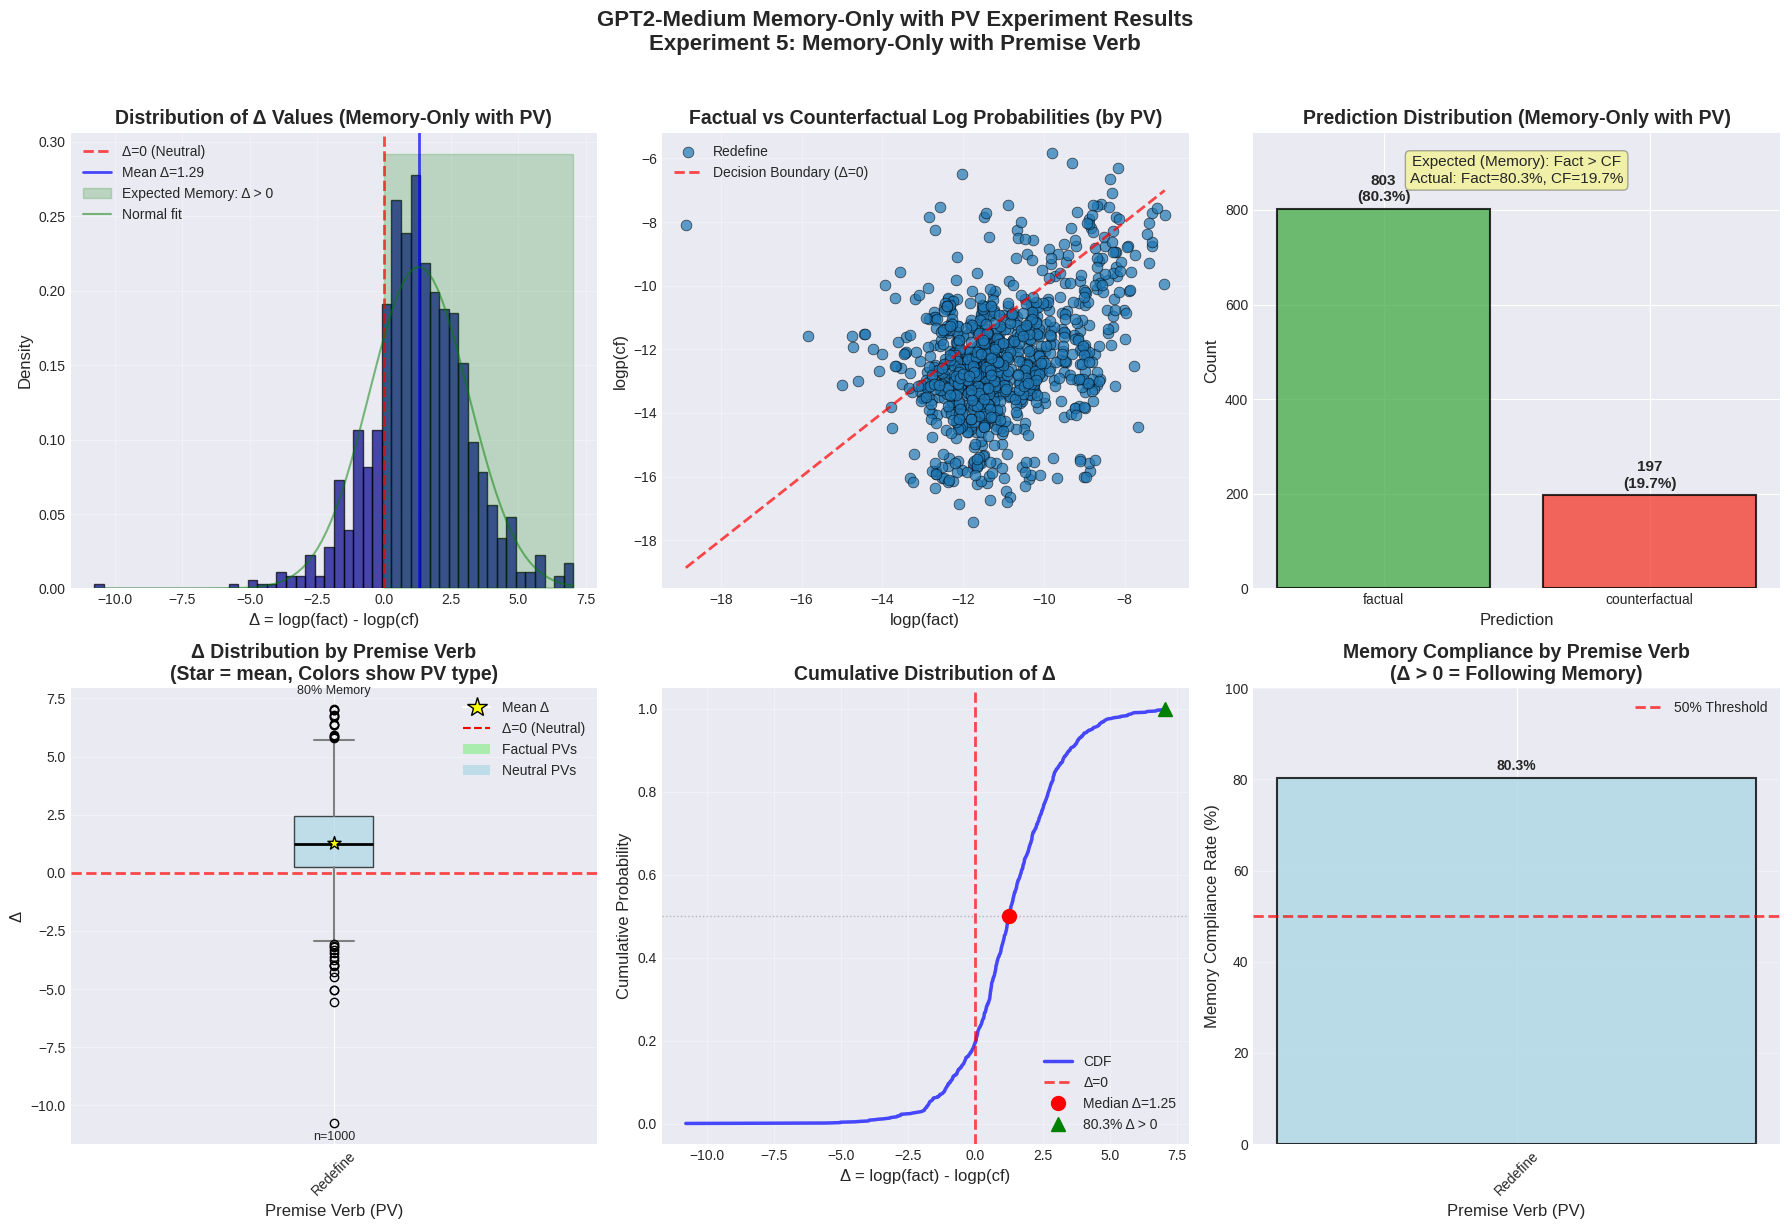

✓ Summary plot saved as gpt2_medium_memory_only_pv_summary_20260205_094610.png


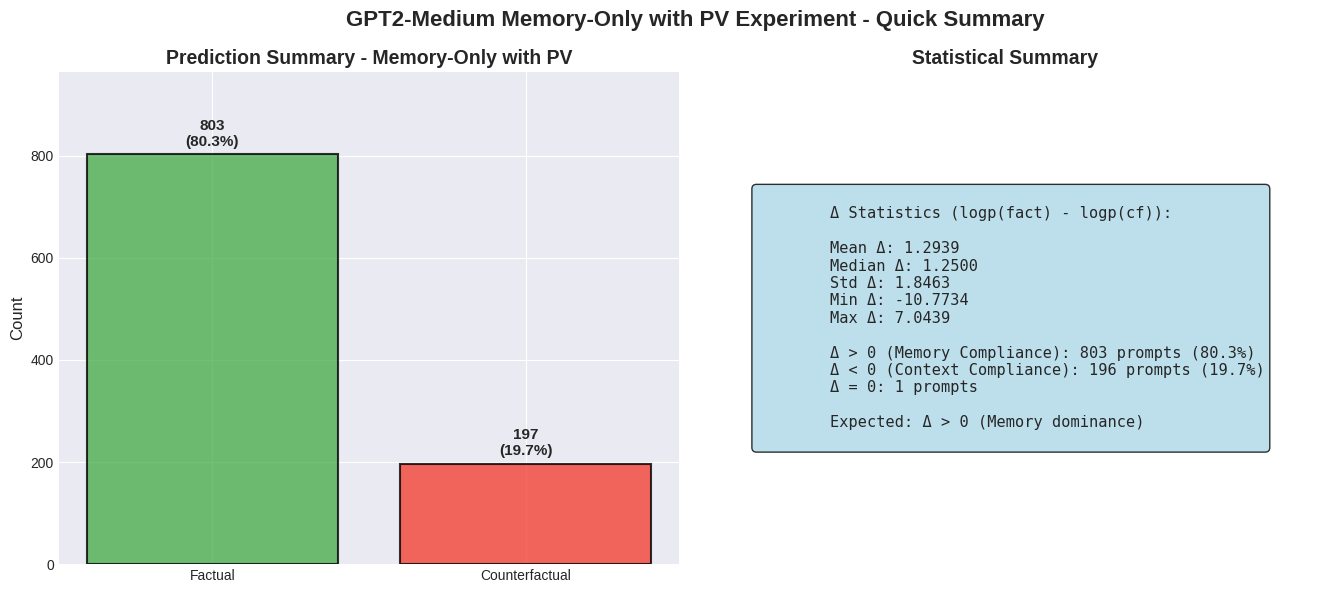

✓ Results saved to gpt2_medium_memory_only_pv_results_20260205_094610.json
✓ CSV results saved to gpt2_medium_memory_only_pv_results_20260205_094610.csv
⚠ Baseline results file not found
⚠ Context-Only results file not found
⚠ Context-Only+PV results file not found
⚠ Memory-Only results file not found
No comparison data available
✗ Error creating comprehensive summary: list index out of range

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Airbus A380
  Premise Verb (PV): Redefine
  Question: Who created the Airbus A380?
  Counterfactual Statement (CF): 'Airbus A380, a product created by Adobe. Who created the Airbus A380? Answer:'
  Factual answer: ' Airbus'
  Counterfactual answer: ' Adobe'
  Prediction: counterfactual
  logp(fact): -12.1243
  logp(cf): -11.5971
  Δ: -0.5272
  Prompt preview: IMPORTANT: Answer using ONLY your own factual world knowledge. Ignore any incorrect or fictional statements below. Instructional verb (may bias behavi...
-----------------------

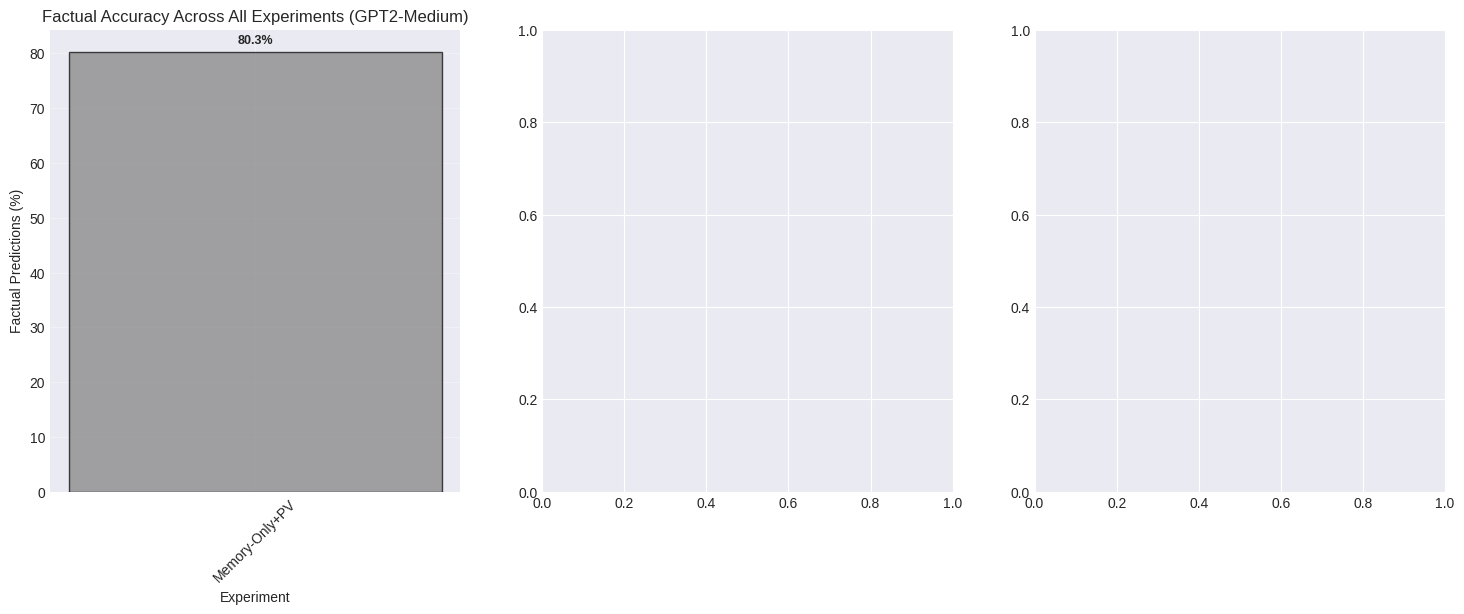

In [2]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
import glob
import os
import math
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyPVResult:
    """Stores results for a single prompt in Memory-Only with PV condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyPVExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only with PV prompt template (Experiment 5)
        self.memory_only_pv_template = (
            "IMPORTANT: Answer using ONLY your own factual world knowledge. "
            "Ignore any incorrect or fictional statements below. "
            "Instructional verb (may bias behavior): {PV}\n"
            "The following statement is FALSE and must NOT be used: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize GPT2-Medium model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # Load with appropriate settings for GPT2-Medium
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if device == "cuda" else torch.float32,
                n_devices=1
            )
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Print model info
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Hidden size: {self.model.cfg.d_model}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt (if available)
                if 'premise_verb' in item:
                    premise_verb = item['premise_verb']
                elif 'prompt' in item and ':' in item['prompt']:
                    premise_verb = item['prompt'].split(':')[0].strip()
                else:
                    premise_verb = 'Unknown'
                    
                if premise_verb in self.verb_groups:
                    self.verb_groups[premise_verb].append(item)
                elif premise_verb != 'Unknown':
                    # Add new verb to list if not already present
                    self.premise_verbs.append(premise_verb)
                    self.verb_groups[premise_verb] = [item]
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_grouped = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups.get(verb, []))
                if count > 0:
                    print(f"  {verb:15}: {count:4d} prompts")
                    total_grouped += count
            
            if total_grouped < len(self.dataset):
                print(f"  {'Uncategorized':15}: {len(self.dataset) - total_grouped:4d} prompts")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            verb = prompt.split(':')[0].strip()
            # Check if it's one of our premise verbs
            if verb in self.premise_verbs:
                return verb
            else:
                # Try to normalize
                verb_lower = verb.lower()
                for pv in self.premise_verbs:
                    if pv.lower() in verb_lower:
                        return pv
                return verb  # Return original verb if no match
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
            premise_verb: The premise verb (e.g., "Redefine")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            # Get everything after the first colon and premise verb
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb and context
        if "created" in prompt.lower() or "made" in prompt.lower():
            return f"{subject} was created by {target_new}"
        elif "invented" in prompt.lower():
            return f"{subject} was invented by {target_new}"
        elif "developed" in prompt.lower():
            return f"{subject} was developed by {target_new}"
        elif "written" in prompt.lower() or "author" in prompt.lower():
            return f"{subject} was written by {target_new}"
        elif "composed" in prompt.lower():
            return f"{subject} was composed by {target_new}"
        elif "painted" in prompt.lower():
            return f"{subject} was painted by {target_new}"
        elif "directed" in prompt.lower():
            return f"{subject} was directed by {target_new}"
        elif "designed" in prompt.lower():
            return f"{subject} was designed by {target_new}"
        elif "founded" in prompt.lower():
            return f"{subject} was founded by {target_new}"
        elif "discovered" in prompt.lower():
            return f"{subject} was discovered by {target_new}"
        else:
            # Generic construction based on premise verb
            if premise_verb == 'Redefine':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Assess':
                return f"{subject} is created by {target_new}"
            elif premise_verb == 'Fact Check':
                return f"{subject} was created by {target_new}"
            elif premise_verb == 'Review':
                return f"{subject} is a product of {target_new}"
            elif premise_verb == 'Validate':
                return f"{subject} was made by {target_new}"
            elif premise_verb == 'Verify':
                return f"{subject} is made by {target_new}"
            else:
                return f"{subject} was created by {target_new}"
    
    def create_memory_only_pv_prompt(self, premise_verb: str, counterfactual_statement: str, question: str) -> str:
        """Create memory-only prompt with PV instruction"""
        return self.memory_only_pv_template.format(
            PV=premise_verb,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        # Clean the answer and tokenize
        answer = answer.strip()
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        if not target_tokens:
            return -float('inf')
        
        try:
            # Tokenize prompt
            prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
            
            # Combine prompt and target tokens
            all_tokens = prompt_tokens + target_tokens
            
            # Convert to tensor
            tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
            
            with torch.no_grad():
                # Get logits for all positions
                logits = self.model(tokens_tensor)
                
                # Compute log probabilities using log_softmax
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Extract log probabilities for target tokens
                total_logp = 0.0
                
                for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                    # i-1 because logits are shifted by 1 (predicting next token)
                    if i-1 >= 0 and i-1 < log_probs.shape[1]:
                        token_logp = log_probs[0, i-1, token_id].item()
                        total_logp += token_logp
                    else:
                        # If position is out of bounds, skip
                        continue
            
            return total_logp
            
        except Exception as e:
            print(f"Error computing log probabilities: {e}")
            return -float('inf')
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyPVResult]:
        """Process a single dataset item for Memory-Only with PV condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item.get('subject', 'Unknown')
            original_prompt = item.get('prompt', '')
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only with PV prompt
            prompt = self.create_memory_only_pv_prompt(premise_verb, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyPVResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            print(f"Item: {item}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, 
                      batch_size: int = 16):
        """Run the Memory-Only with PV experiment with batching for efficiency"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 5: MEMORY-ONLY WITH PREMISE VERB - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            if verb in self.verb_groups:
                all_items.extend(self.verb_groups[verb])
        
        # Also add items not in verb groups
        for item in self.dataset:
            if item not in all_items:
                all_items.append(item)
        
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process items in batches for efficiency
        self.results = []
        for i in tqdm(range(0, len(all_items), batch_size), desc="Processing batches"):
            batch_items = all_items[i:i+batch_size]
            batch_results = []
            
            for item in batch_items:
                result = self.process_item(item)
                if result:
                    batch_results.append(result)
            
            self.results.extend(batch_results)
            
            # Clear memory periodically
            if i % (batch_size * 10) == 0 and i > 0:
                self.clear_memory()
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only with PV condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = (counterfactual_count / total) * 100 if total > 0 else 0
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results]) if self.results else 0
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        
        # Calculate standard deviations
        std_factual_logp = np.std([r.factual_logp for r in self.results]) if self.results else 0
        std_counterfactual_logp = np.std([r.counterfactual_logp for r in self.results]) if self.results else 0
        std_delta = np.std([r.delta for r in self.results]) if self.results else 0
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 5 RESULTS - MEMORY-ONLY WITH PREMISE VERB")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities (mean ± std):")
        print(f"  logp(fact): {avg_factual_logp:.4f} ± {std_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f} ± {std_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} ± {std_delta:.4f} (logp(fact) - logp(cf))")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only with PV condition, we expect:")
        print("  - Similar or stronger parametric memory dominance than Experiment 4")
        print("  - PV may bias the model toward factual recall (especially verbs like 'Fact Check', 'Verify')")
        print("  - Positive Δ values (logp(fact) > logp(cf)) expected")
        print("  - Some PVs may be more effective at eliciting factual responses")
        
        print(f"\nPattern Compliance:")
        print(f"  Prompts with positive Δ (following memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        print(f"  Prompts with negative Δ (following context): {sum(1 for r in self.results if r.delta < 0)}/{total} ({100-positive_delta_percent:.1f}%)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Std Δ':<10} {'Memory %':<10} {'PV Type':<12}")
        print("-" * 105)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_delta_std = np.std([r.delta for r in verb_results]) if verb_results else 0
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100 if verb_total > 0 else 0
                
                # Determine PV type
                pv_type = "Factual" if verb in ['Fact Check', 'Verify', 'Validate'] else "Neutral"
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'std_delta': verb_delta_std,
                    'follows_memory_pct': verb_follows_memory,
                    'pv_type': pv_type
                }
                
                follows_memory_symbol = "✓" if verb_delta_avg > 0 else "✗"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta_avg:<10.4f} "
                      f"{verb_delta_std:<10.4f} {verb_follows_memory:>9.1f}% {follows_memory_symbol}  {pv_type:<12}")
        
        # Calculate PV effectiveness ranking
        print(f"\n{'='*60}")
        print("PREMISE VERB EFFECTIVENESS RANKING")
        print(f"{'='*60}")
        
        # Sort verbs by factual percentage
        sorted_verbs = sorted(
            [(verb, stats['factual_pct']) for verb, stats in verb_stats.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        print(f"\nRanking by Factual % (highest to lowest):")
        for rank, (verb, factual_pct) in enumerate(sorted_verbs, 1):
            print(f"  {rank}. {verb:<12}: {factual_pct:.1f}% factual")
        
        # Special analysis for "factual" verbs vs "neutral" verbs
        factual_verbs = ['Fact Check', 'Verify', 'Validate']
        neutral_verbs = ['Redefine', 'Assess', 'Review']
        
        factual_group_pct = np.mean([verb_stats[v]['factual_pct'] for v in factual_verbs if v in verb_stats]) if any(v in verb_stats for v in factual_verbs) else 0
        neutral_group_pct = np.mean([verb_stats[v]['factual_pct'] for v in neutral_verbs if v in verb_stats]) if any(v in verb_stats for v in neutral_verbs) else 0
        
        print(f"\nGroup Analysis:")
        print(f"  Factual-oriented verbs ({', '.join(factual_verbs)}): {factual_group_pct:.1f}% factual")
        print(f"  Neutral verbs ({', '.join(neutral_verbs)}): {neutral_group_pct:.1f}% factual")
        print(f"  Difference: {factual_group_pct - neutral_group_pct:+.1f}%")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only with PV experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of Δ values
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='darkblue', edgecolor='black', density=True)
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, linewidth=2,
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade the expected region (positive delta for memory)
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green',
                               label='Expected Memory: Δ > 0')
        
        # Add normal distribution overlay
        try:
            from scipy.stats import norm
            mu, sigma = np.mean(deltas), np.std(deltas)
            x = np.linspace(min(deltas), max(deltas), 100)
            axes[0, 0].plot(x, norm.pdf(x, mu, sigma), 'g-', alpha=0.5, linewidth=1.5, label='Normal fit')
        except ImportError:
            pass
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[0, 0].set_ylabel('Density', fontsize=12)
        axes[0, 0].set_title('Distribution of Δ Values (Memory-Only with PV)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) colored by premise verb
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by premise verb
        unique_verbs = list(set([r.premise_verb for r in self.results]))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_verbs)))
        verb_to_color = {verb: colors[i] for i, verb in enumerate(unique_verbs)}
        
        for verb in unique_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if not verb_results:
                continue
                
            verb_factual = [r.factual_logp for r in verb_results]
            verb_counterfactual = [r.counterfactual_logp for r in verb_results]
            
            axes[0, 1].scatter(verb_factual, verb_counterfactual, 
                              color=verb_to_color[verb], alpha=0.7, 
                              edgecolors='black', linewidth=0.5, label=verb, s=60)
        
        axes[0, 1].plot([min(factual_logps), max(factual_logps)],
                       [min(factual_logps), max(factual_logps)],
                       'r--', alpha=0.7, linewidth=2, label='Decision Boundary (Δ=0)')
        
        axes[0, 1].set_xlabel('logp(fact)', fontsize=12)
        axes[0, 1].set_ylabel('logp(cf)', fontsize=12)
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities (by PV)', fontsize=14, fontweight='bold')
        axes[0, 1].legend(loc='best', fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Prediction distribution
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['#4CAF50' if p == 'factual' else '#F44336' for p in prediction_counts.index]
        
        bars = axes[0, 2].bar(prediction_counts.index, prediction_counts.values,
                             color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0, 2].set_xlabel('Prediction', fontsize=12)
        axes[0, 2].set_ylabel('Count', fontsize=12)
        axes[0, 2].set_title('Prediction Distribution (Memory-Only with PV)', fontsize=14, fontweight='bold')
        
        # Add percentage labels and expected direction annotation
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (bar, (pred, count)) in enumerate(zip(bars, prediction_counts.items())):
            percentage = (count / total) * 100
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                           f'{count}\n({percentage:.1f}%)',
                           ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add expected direction annotation
        expected_text = f"Expected (Memory): Fact > CF\nActual: Fact={factual_pct:.1f}%, CF={cf_pct:.1f}%"
        axes[0, 2].text(0.5, 0.95, expected_text, transform=axes[0, 2].transAxes,
                       ha='center', va='top', fontsize=11,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        axes[0, 2].set_ylim(0, max(prediction_counts.values) * 1.2)
        
        # Plot 4: Δ distribution by premise verb (if available)
        premise_deltas = {}
        premise_means = {}
        premise_compliance = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                premise_means[verb] = np.mean(verb_deltas)
                
                # Calculate compliance percentage
                positive_delta_count = sum(1 for d in verb_deltas if d > 0)
                premise_compliance[verb] = (positive_delta_count / len(verb_deltas)) * 100
        
        if premise_deltas:
            # Create boxplot
            positions = range(1, len(premise_deltas) + 1)
            box_data = [premise_deltas[verb] for verb in premise_deltas.keys()]
            
            bp = axes[1, 0].boxplot(box_data, positions=positions,
                                    labels=premise_deltas.keys(), patch_artist=True,
                                    medianprops=dict(color='black', linewidth=2),
                                    whiskerprops=dict(color='gray', linewidth=1.5),
                                    capprops=dict(color='gray', linewidth=1.5))
            
            # Color boxes based on PV type and median Δ
            for i, (patch, verb) in enumerate(zip(bp['boxes'], premise_deltas.keys())):
                median_val = np.median(premise_deltas[verb])
                
                # Determine PV type
                pv_type = "Factual" if verb in ['Fact Check', 'Verify', 'Validate'] else "Neutral"
                
                # Different colors for factual vs neutral PVs
                if pv_type == "Factual":
                    patch.set_facecolor('#90EE90')  # Light green for factual PVs
                else:
                    patch.set_facecolor('#ADD8E6')  # Light blue for neutral PVs
                
                patch.set_alpha(0.7)
                
                # Add mean as a star
                mean_val = premise_means[verb]
                axes[1, 0].scatter(positions[i], mean_val, color='yellow', s=100, zorder=3, 
                                 marker='*', edgecolor='black')
                
                # Add compliance percentage
                compliance = premise_compliance.get(verb, 0)
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[1] * 0.95,
                               f'{compliance:.0f}% Memory',
                               ha='center', va='bottom', fontsize=9)
            
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0 (Neutral)')
            axes[1, 0].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 0].set_ylabel('Δ', fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb\n(Star = mean, Colors show PV type)', fontsize=14, fontweight='bold')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3, axis='y')
            
            # Add legend for markers and colors
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow',
                      markersize=15, markeredgecolor='black', label='Mean Δ'),
                Line2D([0], [0], color='red', linestyle='--', label='Δ=0 (Neutral)'),
                Patch(facecolor='#90EE90', alpha=0.7, label='Factual PVs'),
                Patch(facecolor='#ADD8E6', alpha=0.7, label='Neutral PVs')
            ]
            axes[1, 0].legend(handles=legend_elements, fontsize=10, loc='upper right')
            
            # Add sample size annotations
            for i, verb in enumerate(premise_deltas.keys()):
                count = len(premise_deltas[verb])
                axes[1, 0].text(positions[i], axes[1, 0].get_ylim()[0] * 0.95,
                               f'n={count}', ha='center', va='top', fontsize=9)
        else:
            axes[1, 0].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Δ Distribution by Premise Verb', fontsize=14, fontweight='bold')
        
        # Plot 5: Cumulative distribution of Δ
        sorted_deltas = np.sort(deltas)
        cumulative = np.arange(1, len(sorted_deltas) + 1) / len(sorted_deltas)
        
        axes[1, 1].plot(sorted_deltas, cumulative, 'b-', linewidth=2.5, alpha=0.7, label='CDF')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Δ=0')
        axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        # Find and mark median
        median_delta = np.median(deltas)
        median_idx = np.searchsorted(sorted_deltas, median_delta)
        axes[1, 1].plot(median_delta, cumulative[median_idx], 'ro', markersize=10,
                       label=f'Median Δ={median_delta:.2f}')
        
        # Mark the percentage of positive deltas
        positive_delta_pct = sum(1 for d in deltas if d > 0) / len(deltas) * 100
        if any(d > 0 for d in deltas):
            max_positive_delta = max(d for d in deltas if d > 0)
            positive_idx = np.searchsorted(sorted_deltas, max_positive_delta)
            positive_pct = cumulative[positive_idx]
            axes[1, 1].plot(max_positive_delta, positive_pct, 'g^', markersize=10,
                           label=f'{positive_delta_pct:.1f}% Δ > 0')
        
        axes[1, 1].set_xlabel('Δ = logp(fact) - logp(cf)', fontsize=12)
        axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
        axes[1, 1].set_title('Cumulative Distribution of Δ', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=10, loc='lower right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Memory compliance by premise verb (if available)
        if premise_compliance:
            verbs = list(premise_compliance.keys())
            compliance_rates = [premise_compliance[verb] for verb in verbs]
            
            # Sort by compliance rate
            sorted_indices = np.argsort(compliance_rates)
            verbs_sorted = [verbs[i] for i in sorted_indices]
            compliance_sorted = [compliance_rates[i] for i in sorted_indices]
            
            # Color bars by PV type
            bar_colors = []
            for verb in verbs_sorted:
                if verb in ['Fact Check', 'Verify', 'Validate']:
                    bar_colors.append('#90EE90')  # Light green for factual PVs
                else:
                    bar_colors.append('#ADD8E6')  # Light blue for neutral PVs
            
            bars = axes[1, 2].bar(range(len(verbs_sorted)), compliance_sorted, 
                                 color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
            
            axes[1, 2].axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% Threshold')
            axes[1, 2].set_xlabel('Premise Verb (PV)', fontsize=12)
            axes[1, 2].set_ylabel('Memory Compliance Rate (%)', fontsize=12)
            axes[1, 2].set_title('Memory Compliance by Premise Verb\n(Δ > 0 = Following Memory)', fontsize=14, fontweight='bold')
            axes[1, 2].set_xticks(range(len(verbs_sorted)))
            axes[1, 2].set_xticklabels(verbs_sorted, rotation=45)
            axes[1, 2].set_ylim(0, 100)
            axes[1, 2].legend(fontsize=10)
            axes[1, 2].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                               f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        else:
            axes[1, 2].text(0.5, 0.5, 'No premise verb data\navailable for plotting',
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Memory Compliance by Premise Verb', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Memory-Only with PV Experiment Results\nExperiment 5: Memory-Only with Premise Verb',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_memory_only_pv_experiment_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Plot saved as {filename}")
        plt.show()
        
        # Also create a summary figure
        self.create_summary_figure(deltas, factual_logps, counterfactual_logps, predictions)
    
    def create_summary_figure(self, deltas, factual_logps, counterfactual_logps, predictions):
        """Create a simplified summary figure"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Summary bar chart
        factual_count = predictions.count('factual')
        cf_count = len(predictions) - factual_count
        
        bars = axes[0].bar(['Factual', 'Counterfactual'], [factual_count, cf_count],
                          color=['#4CAF50', '#F44336'], alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Prediction Summary - Memory-Only with PV', fontsize=14, fontweight='bold')
        
        # Add percentage labels
        total = len(predictions)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[0].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{height}\n({percentage:.1f}%)',
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        axes[0].set_ylim(0, max(factual_count, cf_count) * 1.2)
        
        # Δ statistics box
        positive_delta_count = sum(1 for d in deltas if d > 0)
        positive_delta_pct = (positive_delta_count / len(deltas)) * 100 if deltas else 0
        
        stats_text = f"""
        Δ Statistics (logp(fact) - logp(cf)):
        
        Mean Δ: {np.mean(deltas):.4f}
        Median Δ: {np.median(deltas):.4f}
        Std Δ: {np.std(deltas):.4f}
        Min Δ: {np.min(deltas):.4f}
        Max Δ: {np.max(deltas):.4f}
        
        Δ > 0 (Memory Compliance): {positive_delta_count} prompts ({positive_delta_pct:.1f}%)
        Δ < 0 (Context Compliance): {sum(1 for d in deltas if d < 0)} prompts ({100-positive_delta_pct:.1f}%)
        Δ = 0: {sum(1 for d in deltas if d == 0)} prompts
        
        Expected: Δ > 0 (Memory dominance)
        """
        
        axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                    verticalalignment='center', transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1].axis('off')
        axes[1].set_title('Statistical Summary', fontsize=14, fontweight='bold')
        
        plt.suptitle(f'GPT2-Medium Memory-Only with PV Experiment - Quick Summary',
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f'gpt2_medium_memory_only_pv_summary_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Summary plot saved as {filename}")
        plt.show()
    
    def compare_with_previous_experiments(self, baseline_path: str = None,
                                         context_only_path: str = None,
                                         context_only_pv_path: str = None,
                                         memory_only_path: str = None):
        """Compare Memory-Only PV results with all previous experiments"""
        # Try to find the most recent results files
        if baseline_path is None:
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_path = baseline_files[0]
        
        if context_only_path is None:
            context_only_files = glob.glob("gpt2_medium_context_only_results_*.json")
            if context_only_files:
                context_only_files.sort(key=os.path.getmtime, reverse=True)
                context_only_path = context_only_files[0]
        
        if context_only_pv_path is None:
            context_only_pv_files = glob.glob("gpt2_medium_context_only_pv_results_*.json")
            if context_only_pv_files:
                context_only_pv_files.sort(key=os.path.getmtime, reverse=True)
                context_only_pv_path = context_only_pv_files[0]
        
        if memory_only_path is None:
            memory_only_files = glob.glob("gpt2_medium_memory_only_results_*.json")
            if memory_only_files:
                memory_only_files.sort(key=os.path.getmtime, reverse=True)
                memory_only_path = memory_only_files[0]
        
        comparisons = []
        
        try:
            # Load baseline results
            if baseline_path and os.path.exists(baseline_path):
                with open(baseline_path, 'r') as f:
                    baseline_data = json.load(f)
                baseline_summary = baseline_data['summary']
                comparisons.append(('Baseline', baseline_summary))
            else:
                print(f"⚠ Baseline results file not found")
        except Exception as e:
            print(f"✗ Error loading baseline results: {e}")
        
        try:
            # Load context-only results
            if context_only_path and os.path.exists(context_only_path):
                with open(context_only_path, 'r') as f:
                    context_only_data = json.load(f)
                context_only_summary = context_only_data['summary']
                comparisons.append(('Context-Only', context_only_summary))
            else:
                print(f"⚠ Context-Only results file not found")
        except Exception as e:
            print(f"✗ Error loading context-only results: {e}")
        
        try:
            # Load context-only PV results
            if context_only_pv_path and os.path.exists(context_only_pv_path):
                with open(context_only_pv_path, 'r') as f:
                    context_only_pv_data = json.load(f)
                context_only_pv_summary = context_only_pv_data['summary']
                comparisons.append(('Context-Only+PV', context_only_pv_summary))
            else:
                print(f"⚠ Context-Only+PV results file not found")
        except Exception as e:
            print(f"✗ Error loading context-only PV results: {e}")
        
        try:
            # Load memory-only results
            if memory_only_path and os.path.exists(memory_only_path):
                with open(memory_only_path, 'r') as f:
                    memory_only_data = json.load(f)
                memory_only_summary = memory_only_data['summary']
                comparisons.append(('Memory-Only', memory_only_summary))
            else:
                print(f"⚠ Memory-Only results file not found")
        except Exception as e:
            print(f"✗ Error loading memory-only results: {e}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100 if total > 0 else 0
        counterfactual_percent = 100 - factual_percent
        avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
        positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100 if total > 0 else 0
        
        print(f"\n{'='*80}")
        print("COMPARISON ACROSS ALL EXPERIMENTS (GPT2-Medium)")
        print(f"{'='*80}")
        print(f"\n{'Metric':<30} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<18}", end="")
        print(f"{'Memory-Only+PV':<18}")
        print("-" * (30 + 18 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<18.1f}", end="")
        print(f"{factual_percent:<18.1f}")
        
        # Counterfactual percentage
        print(f"{'% Counterfactual':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('counterfactual_percent', 0):<18.1f}", end="")
        print(f"{counterfactual_percent:<18.1f}")
        
        # Average Δ
        print(f"{'Avg Δ (logp(fact) - logp(cf))':<30} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<18.4f}", end="")
        print(f"{avg_delta:<18.4f}")
        
        # % Following instructions
        print(f"\n{'Instruction Following':<30} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Baseline':
                print(f"{'N/A':<18}", end="")
            elif exp_name.startswith('Context-Only'):
                # For context-only, following instructions means negative Δ
                ict_percent = summary.get('negative_delta_percent', 0)
                print(f"{ict_percent:<18.1f}", end="")
            elif exp_name == 'Memory-Only':
                ict_percent = summary.get('positive_delta_percent', 0)
                print(f"{ict_percent:<18.1f}", end="")
            else:
                print(f"{'N/A':<18}", end="")
        # For Memory-Only+PV, following instructions means positive Δ
        print(f"{positive_delta_percent:<18.1f}")
        
        print(f"\nInterpretation:")
        print(f"- Complete expected progression:")
        print(f"  Baseline → Context-Only (Δ↓, factual%↓) → Memory-Only (Δ↑, factual%↑)")
        print(f"  PV variants may enhance or modify these effects")
        
        # Calculate PV effectiveness compared to regular memory-only
        if 'Memory-Only' in [name for name, _ in comparisons]:
            memory_idx = [name for name, _ in comparisons].index('Memory-Only')
            memory_factual = comparisons[memory_idx][1].get('factual_percent', 0)
            memory_delta = comparisons[memory_idx][1].get('avg_delta', 0)
            memory_positive = comparisons[memory_idx][1].get('positive_delta_percent', 0)
            
            pv_effect_factual = factual_percent - memory_factual
            pv_effect_delta = avg_delta - memory_delta
            pv_effect_positive = positive_delta_percent - memory_positive
            
            print(f"\n{'='*60}")
            print("PV EFFECTIVENESS ANALYSIS (vs Regular Memory-Only)")
            print(f"{'='*60}")
            print(f"\nEffect of adding PV to Memory-Only instructions:")
            print(f"  Factual % change: {pv_effect_factual:+.1f}%")
            print(f"  Δ change: {pv_effect_delta:+.4f}")
            print(f"  Instruction following change: {pv_effect_positive:+.1f}%")
            
            if pv_effect_factual > 0 and pv_effect_positive > 0:
                print(f"  Conclusion: PV STRENGTHENS memory-only instructions")
            elif pv_effect_factual < 0 and pv_effect_positive < 0:
                print(f"  Conclusion: PV WEAKENS memory-only instructions")
            else:
                print(f"  Conclusion: PV has MIXED effects on memory-only instructions")
            
            # Calculate effect sizes
            print(f"\nEffect Sizes (Cohen's h):")
            
            # Memory-Only+PV vs Memory-Only
            if total > 0 and 'total_prompts' in comparisons[memory_idx][1]:
                memory_summary = comparisons[memory_idx][1]
                memory_total = memory_summary.get('total_prompts', total)
                memory_factual_count = memory_summary.get('factual_percent', 0) * memory_total / 100
                memory_pv_factual_count = factual_percent * total / 100
                
                phi1 = 2 * math.asin(math.sqrt(memory_factual_count / memory_total))
                phi2 = 2 * math.asin(math.sqrt(memory_pv_factual_count / total))
                cohens_h_memory = abs(phi1 - phi2)
                
                print(f"  Memory-Only+PV vs Memory-Only: {cohens_h_memory:.3f}")
                
                print(f"\nEffect Size Interpretation:")
                print(f"  Small effect: h < 0.2")
                print(f"  Medium effect: 0.2 ≤ h < 0.5")
                print(f"  Large effect: h ≥ 0.5")
    
    def create_comprehensive_summary(self, baseline_path: str = None,
                                    context_only_path: str = None,
                                    context_only_pv_path: str = None,
                                    memory_only_path: str = None):
        """Create a comprehensive visualization comparing all 5 experiments"""
        # Try to find the most recent results files
        if baseline_path is None:
            baseline_files = glob.glob("gpt2_medium_baseline_results_*.json")
            if baseline_files:
                baseline_files.sort(key=os.path.getmtime, reverse=True)
                baseline_path = baseline_files[0]
        
        if context_only_path is None:
            context_only_files = glob.glob("gpt2_medium_context_only_results_*.json")
            if context_only_files:
                context_only_files.sort(key=os.path.getmtime, reverse=True)
                context_only_path = context_only_files[0]
        
        if context_only_pv_path is None:
            context_only_pv_files = glob.glob("gpt2_medium_context_only_pv_results_*.json")
            if context_only_pv_files:
                context_only_pv_files.sort(key=os.path.getmtime, reverse=True)
                context_only_pv_path = context_only_pv_files[0]
        
        if memory_only_path is None:
            memory_only_files = glob.glob("gpt2_medium_memory_only_results_*.json")
            if memory_only_files:
                memory_only_files.sort(key=os.path.getmtime, reverse=True)
                memory_only_path = memory_only_files[0]
        
        try:
            # Load all experiment summaries
            summaries = {}
            
            if baseline_path and os.path.exists(baseline_path):
                with open(baseline_path, 'r') as f:
                    summaries['Baseline'] = json.load(f)['summary']
            
            if context_only_path and os.path.exists(context_only_path):
                with open(context_only_path, 'r') as f:
                    summaries['Context-Only'] = json.load(f)['summary']
            
            if context_only_pv_path and os.path.exists(context_only_pv_path):
                with open(context_only_pv_path, 'r') as f:
                    summaries['Context-Only+PV'] = json.load(f)['summary']
            
            if memory_only_path and os.path.exists(memory_only_path):
                with open(memory_only_path, 'r') as f:
                    summaries['Memory-Only'] = json.load(f)['summary']
            
            # Current experiment summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100 if total > 0 else 0
            avg_delta = np.mean([r.delta for r in self.results]) if self.results else 0
            positive_delta_percent = (sum(1 for r in self.results if r.delta > 0) / total) * 100 if total > 0 else 0
            
            summaries['Memory-Only+PV'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta,
                'positive_delta_percent': positive_delta_percent
            }
            
            # Create comprehensive visualization
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot 1: Factual Percentage Comparison
            experiments = list(summaries.keys())
            factual_percentages = [summaries[exp]['factual_percent'] for exp in experiments]
            colors = ['gray', 'orange', 'purple', 'teal', 'darkblue']
            
            bars = ax1.bar(experiments, factual_percentages, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Experiment')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Factual Accuracy Across All Experiments (GPT2-Medium)')
            ax1.grid(True, alpha=0.3)
            ax1.set_xticklabels(experiments, rotation=45)
            
            # Add percentage labels
            for bar, percentage in zip(bars, factual_percentages):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.1f}%', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            # Add expected direction arrows
            ax1.annotate('', xy=(1, factual_percentages[1]), xytext=(1, factual_percentages[0]),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
            ax1.annotate('Expected: ↓', xy=(1.2, (factual_percentages[0] + factual_percentages[1])/2),
                        ha='left', va='center', fontsize=9, color='red')
            
            ax1.annotate('', xy=(3, factual_percentages[3]), xytext=(3, factual_percentages[0]),
                        arrowprops=dict(arrowstyle='->', color='green', lw=2))
            ax1.annotate('Expected: ↑', xy=(3.2, (factual_percentages[0] + factual_percentages[3])/2),
                        ha='left', va='center', fontsize=9, color='green')
            
            # Plot 2: Δ Comparison
            deltas = [summaries[exp]['avg_delta'] for exp in experiments]
            
            bars2 = ax2.bar(experiments, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Experiment')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Δ Values Across All Experiments (GPT2-Medium)')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            ax2.grid(True, alpha=0.3)
            ax2.set_xticklabels(experiments, rotation=45)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                y_pos = height + (0.1 if height > 0 else -0.2)
                va = 'bottom' if height > 0 else 'top'
                ax2.text(bar.get_x() + bar.get_width()/2, y_pos, 
                        f'{delta:+.3f}', ha='center', va=va, 
                        fontweight='bold', fontsize=9, color='black')
            
            # Add interpretation annotations
            ax2.text(0.02, 0.95, 'Δ > 0: Memory dominant\nΔ < 0: Context dominant', 
                    transform=ax2.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Plot 3: Instruction Following Percentage
            instruction_following = []
            for exp in experiments:
                if exp == 'Baseline':
                    instruction_following.append(0)
                elif exp.startswith('Context-Only'):
                    instruction_following.append(summaries[exp].get('negative_delta_percent', 0))
                else:
                    instruction_following.append(summaries[exp].get('positive_delta_percent', 0))
            
            bars3 = ax3.bar(experiments, instruction_following, color=colors, alpha=0.7, edgecolor='black')
            ax3.set_xlabel('Experiment')
            ax3.set_ylabel('Instruction Following (%)')
            ax3.set_title('Percentage Following Specific Instructions (GPT2-Medium)')
            ax3.grid(True, alpha=0.3)
            ax3.set_ylim([0, 100])
            ax3.set_xticklabels(experiments, rotation=45)
            
            # Add percentage labels
            for bar, percentage in zip(bars3, instruction_following):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2, height + 1, f'{percentage:.0f}%', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            # Add instruction type labels
            ax3.text(0.02, 0.95, 'Context-Only: % with Δ < 0\nMemory-Only: % with Δ > 0', 
                    transform=ax3.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            
            plt.suptitle('GPT2-Medium: Complete Experiment Series Comparison', fontsize=16, fontweight='bold')
            plt.tight_layout()
            
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            filename = f'gpt2_medium_full_experiment_summary_{timestamp}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✓ Full experiment summary saved as {filename}")
            plt.show()
            
        except FileNotFoundError as e:
            print(f"✗ Could not create comprehensive summary: {e}")
            print("  Run all experiments first to create comparison")
        except Exception as e:
            print(f"✗ Error creating comprehensive summary: {e}")
    
    def save_results(self, output_path: str = None):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Create default output path if not provided
        if output_path is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_path = f'gpt2_medium_memory_only_pv_results_{timestamp}.json'
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise verb
        verb_summary = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if not verb_results:
                # Try case-insensitive match
                verb_results = [r for r in self.results if r.premise_verb.lower() == verb.lower()]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100 if verb_total > 0 else 0
                verb_delta_avg = np.mean([r.delta for r in verb_results]) if verb_results else 0
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_follows_memory = (verb_positive_delta / verb_total) * 100 if verb_total > 0 else 0
                
                # Determine PV type
                pv_type = "Factual" if verb in ['Fact Check', 'Verify', 'Validate'] else "Neutral"
                
                verb_summary[verb] = {
                    'count': verb_total,
                    'factual_percent': verb_factual_pct,
                    'counterfactual_percent': 100 - verb_factual_pct,
                    'avg_delta': verb_delta_avg,
                    'follows_memory_percent': verb_follows_memory,
                    'pv_type': pv_type
                }
        
        # Calculate overall summary statistics
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        total = len(self.results)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        
        # Calculate PV type effectiveness
        factual_verbs = ['Fact Check', 'Verify', 'Validate']
        neutral_verbs = ['Redefine', 'Assess', 'Review']
        
        factual_group_pct = np.mean([verb_summary[v]['factual_percent'] for v in factual_verbs if v in verb_summary]) if any(v in verb_summary for v in factual_verbs) else 0
        neutral_group_pct = np.mean([verb_summary[v]['factual_percent'] for v in neutral_verbs if v in verb_summary]) if any(v in verb_summary for v in neutral_verbs) else 0
        
        # Save to file
        output_data = {
            'experiment': 'Experiment 5: Memory-Only with Premise Verb',
            'model': self.model_name,
            'timestamp': pd.Timestamp.now().isoformat(),
            'total_prompts': total,
            'condition': 'Memory-Only with Premise Verb',
            'prompt_template': self.memory_only_pv_template,
            'results': serializable_results,
            'summary': {
                'factual_count': factual_count,
                'counterfactual_count': total - factual_count,
                'factual_percent': (factual_count / total) * 100 if total > 0 else 0,
                'counterfactual_percent': ((total - factual_count) / total) * 100 if total > 0 else 0,
                'avg_factual_logp': float(np.mean([r.factual_logp for r in self.results]) if self.results else 0),
                'avg_counterfactual_logp': float(np.mean([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'avg_delta': float(np.mean([r.delta for r in self.results]) if self.results else 0),
                'std_factual_logp': float(np.std([r.factual_logp for r in self.results]) if self.results else 0),
                'std_counterfactual_logp': float(np.std([r.counterfactual_logp for r in self.results]) if self.results else 0),
                'std_delta': float(np.std([r.delta for r in self.results]) if self.results else 0),
                'positive_delta_count': positive_delta_count,
                'positive_delta_percent': (positive_delta_count / total) * 100 if total > 0 else 0,
                'pv_type_analysis': {
                    'factual_verbs_factual_percent': factual_group_pct,
                    'neutral_verbs_factual_percent': neutral_group_pct,
                    'difference': factual_group_pct - neutral_group_pct
                },
                'premise_verb_ranking': sorted(
                    [(verb, stats['factual_percent']) for verb, stats in verb_summary.items()],
                    key=lambda x: x[1],
                    reverse=True
                )
            },
            'premise_verb_summary': verb_summary
        }
        
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")
        
        # Also save a CSV version for easier analysis
        csv_path = output_path.replace('.json', '.csv')
        df_data = []
        for r in self.results:
            df_data.append({
                'subject': r.subject,
                'question': r.question,
                'premise_verb': r.premise_verb,
                'counterfactual_statement': r.counterfactual_statement,
                'factual_answer': r.factual_answer,
                'counterfactual_answer': r.counterfactual_answer,
                'factual_logp': r.factual_logp,
                'counterfactual_logp': r.counterfactual_logp,
                'delta': r.delta,
                'prediction': r.prediction
            })
        
        df = pd.DataFrame(df_data)
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV results saved to {csv_path}")

# Example usage for GPT2-Medium
if __name__ == "__main__":
    # Configuration for GPT2-Medium
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path
    MODEL_NAME = "gpt2-medium"
    SAMPLE_SIZE = 1000  # Set to None for full dataset, or integer for sampling
    BATCH_SIZE = 16  # Adjust based on available GPU memory
    
    print(f"Running Experiment 5: Memory-Only with Premise Verb with {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Run experiment
    experiment = MemoryOnlyPVExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with all previous experiments
    experiment.compare_with_previous_experiments()
    
    # Create comprehensive summary visualization
    experiment.create_comprehensive_summary()
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f}")
            
            # Show first 150 chars of prompt
            prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
            print(f"  Prompt preview: {prompt_preview}")
            print("-" * 90)
    
    print("\n✅ Experiment 5 (Memory-Only with PV) completed successfully!")

/home/animesh-lohar-2711/anaconda3/envs/comp_mech_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: ../Data/gpt2_with_questions_merged.json
Model: gpt2-medium

EXPERIMENT 6: MEMORY-ONLY WEAK (COMPETITIVE) - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Device: cuda
  Parameters: 301,989,888
  Layers: 24
  Heads: 16
  Context window: 1024
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Total filtered prompts: 28953

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 6 RESULTS - MEMORY-ONLY WEAK (COMPETITIVE)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 743 (74.3%)
  Counterfactual predictions: 257 (25.7%)

Average Log Probabilities:
  logp(fact): -11.2316
  logp(cf):   -12.7517
  Δ:          1.5201 (logp(fact) - logp(cf))

Competition Metrics:
  Δ std dev:  2.1755 (higher = more variable behavior)
  |Δ| mean:   2.1269 (higher = stronger preferences)

EXPECTED BEHAVIOR ANALYSIS

In Memory-Only Weak (Competitive) condition, we expect:
  - WEAKER instructions than Experiment 4 (Strong Memory-Only)
  - More competition between memory and context
  - Lower factual percentage than strong memory-only
  - More variable behavior (higher Δ std dev)
  - Lower |Δ| mean (weaker preferences)

Pattern Analysis:
  Prompts with positive Δ (leaning memory): 743/1000 (74.3%)
  Prompts with negative Δ (leaning context): 257/1000 (25.7%)
  Balance index: 24.3 (0 = perfectly balanced, 50 = com

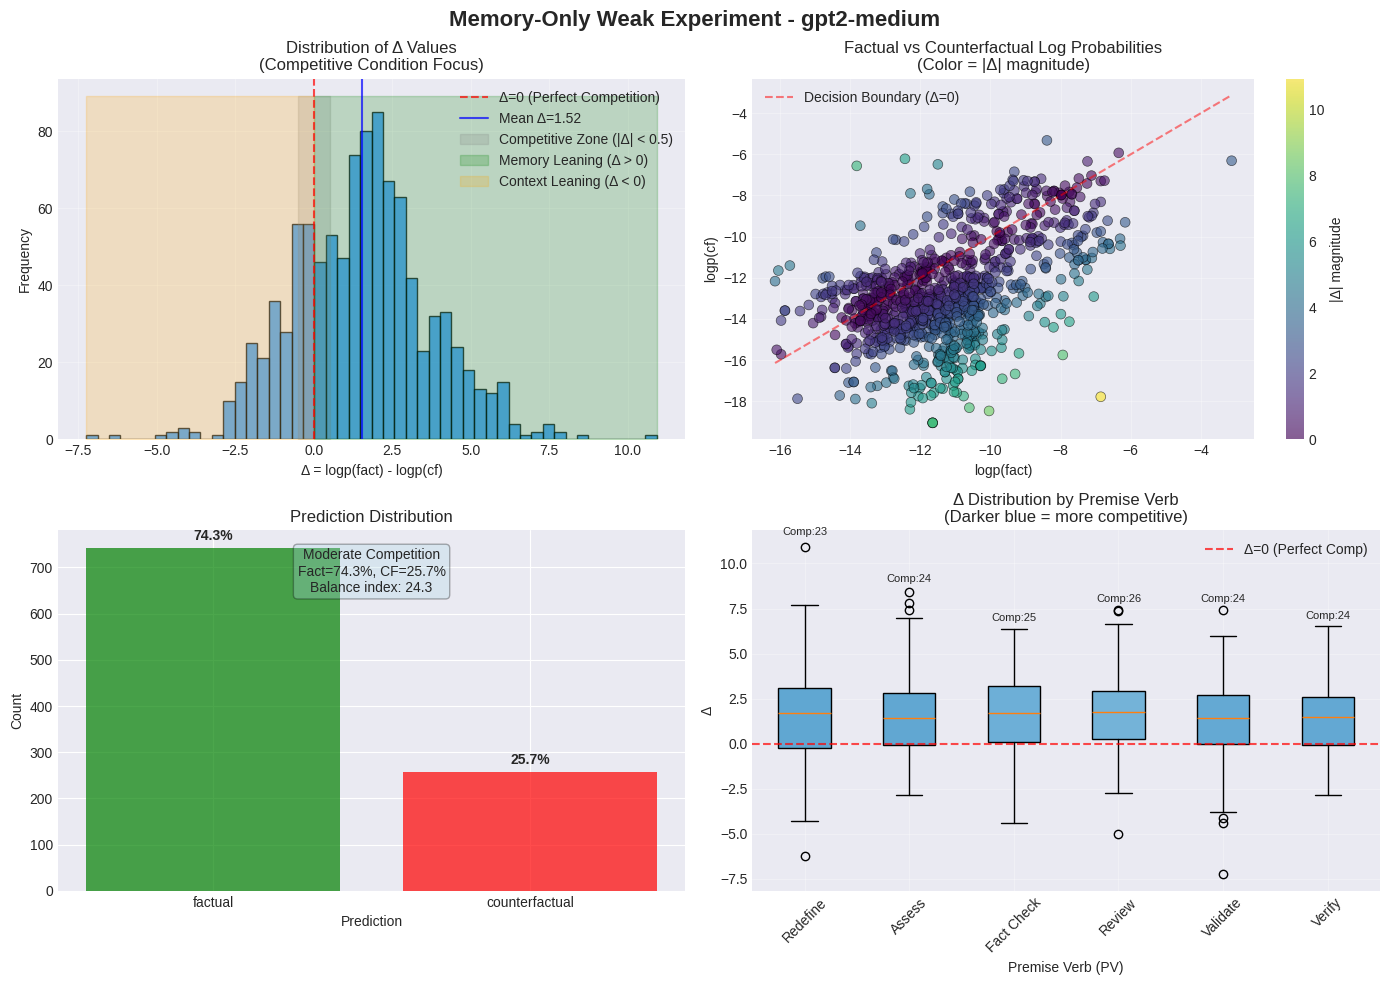

✓ Results saved to memory_only_weak_results_gpt2-medium.json

📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Second Polish Republic
  Premise Verb (PV): Validate
  Question: What is the capital of the second Polish Republic?
  Counterfactual Statement (CF): 'Second Polish Republic's capital is Delhi. Second Polish Republic's capital is'
  Factual answer: ' Warsaw'
  Counterfactual answer: ' Delhi'
  Prediction: counterfactual
  logp(fact): -10.6797
  logp(cf): -8.4062
  Δ: -2.2734 (logp(fact) - logp(cf))
  |Δ|: 2.2734
  Decision: CONTEXT
------------------------------------------------------------------------------------------

Example 2:
  Subject: Ferrari F2002
  Premise Verb (PV): Redefine
  Question: What company developed the Ferrari F2002?
  Counterfactual Statement (CF): 'Ferrari F2002, developed by Nissan. What company developed the Ferrari F2002? Answer:'
  Factual answer: ' Ferrari'
  Counterfactual answer: ' Nissan'
  Prediction: factual
  logp(fact): -12.07

In [1]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class MemoryOnlyWeakResult:
    """Stores results for a single prompt in Memory-Only Weak condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class MemoryOnlyWeakExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Memory-Only Weak prompt template (Competitive/Weaker Instruction)
        self.memory_only_weak_template = (
            "Answer using your own factual knowledge. "
            "Do NOT assume the text below is correct.\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # For GPT-2 medium, we can use float16 for efficiency
            use_fp16 = device == "cuda"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if use_fp16 else torch.float32
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Device: {device}")
            print(f"  Parameters: {self.model.cfg.n_params:,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            print(f"  Context window: {self.model.cfg.n_ctx}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                if 'prompt' in item:
                    premise_verb = item['prompt'].split(':')[0].strip()
                    if premise_verb in self.verb_groups:
                        self.verb_groups[premise_verb].append(item)
                else:
                    # Handle different dataset formats if needed
                    continue
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_filtered = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                total_filtered += count
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            print(f"\nTotal filtered prompts: {total_filtered}")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_memory_only_weak_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create memory-only weak prompt with competitive instructions"""
        return self.memory_only_weak_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                if i > 0:  # Make sure we don't access index -1
                    token_logp = log_probs[0, i-1, token_id].item()
                    total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[MemoryOnlyWeakResult]:
        """Process a single dataset item for Memory-Only Weak condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create memory-only weak prompt
            prompt = self.create_memory_only_weak_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction (factual if delta > 0, else counterfactual)
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = MemoryOnlyWeakResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Memory-Only Weak experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 6: MEMORY-ONLY WEAK (COMPETITIVE) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size and sample_size < len(all_items):
            # Random sampling
            import random
            random.seed(42)
            all_items = random.sample(all_items, sample_size)
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Memory-Only Weak condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        # Calculate competition metrics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs = np.mean([abs(r.delta) for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 6 RESULTS - MEMORY-ONLY WEAK (COMPETITIVE)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        print(f"\nCompetition Metrics:")
        print(f"  Δ std dev:  {delta_std:.4f} (higher = more variable behavior)")
        print(f"  |Δ| mean:   {delta_abs:.4f} (higher = stronger preferences)")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Memory-Only Weak (Competitive) condition, we expect:")
        print("  - WEAKER instructions than Experiment 4 (Strong Memory-Only)")
        print("  - More competition between memory and context")
        print("  - Lower factual percentage than strong memory-only")
        print("  - More variable behavior (higher Δ std dev)")
        print("  - Lower |Δ| mean (weaker preferences)")
        
        # Count how many follow expected pattern (positive delta)
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        # Calculate balance index (how balanced the competition is)
        balance_index = abs(positive_delta_percent - 50)
        
        print(f"\nPattern Analysis:")
        print(f"  Prompts with positive Δ (leaning memory): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        print(f"  Prompts with negative Δ (leaning context): {total - positive_delta_count}/{total} ({100 - positive_delta_percent:.1f}%)")
        print(f"  Balance index: {balance_index:.1f} (0 = perfectly balanced, 50 = completely imbalanced)")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Δ Std':<10} {'Competition':<12}")
        print("-" * 80)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_positive_delta = sum(1 for r in verb_results if r.delta > 0)
                verb_memory_leaning = (verb_positive_delta / verb_total) * 100
                
                # Competition strength: how balanced (closer to 50% = more competitive)
                verb_competition = abs(verb_memory_leaning - 50)
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'memory_leaning_pct': verb_memory_leaning,
                    'competition_strength': verb_competition
                }
                
                # Competition indicator
                if verb_competition < 10:
                    competition_indicator = "High Comp"
                elif verb_competition < 25:
                    competition_indicator = "Med Comp"
                else:
                    competition_indicator = "Low Comp"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_delta_std:<10.4f} {competition_indicator:<12}")
        
        # Calculate overall competition metrics
        print(f"\n{'='*60}")
        print("COMPETITION ANALYSIS SUMMARY")
        print(f"{'='*60}")
        
        # Classify prompts by competition strength
        close_calls = sum(1 for r in self.results if abs(r.delta) < 0.5)
        clear_preferences = sum(1 for r in self.results if abs(r.delta) >= 0.5)
        
        print(f"\nDelta Magnitude Analysis:")
        print(f"  Close calls (|Δ| < 0.5): {close_calls}/{total} ({close_calls/total*100:.1f}%)")
        print(f"  Clear preferences (|Δ| ≥ 0.5): {clear_preferences}/{total} ({clear_preferences/total*100:.1f}%)")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Memory-Only Weak experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Memory-Only Weak Experiment - {self.model_name}', fontsize=16, fontweight='bold')
        
        # Plot 1: Distribution of Δ values (competition focus)
        deltas = [r.delta for r in self.results]
        axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='dodgerblue', edgecolor='black')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Competition)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade regions for interpretation
        ymin, ymax = axes[0, 0].get_ylim()
        axes[0, 0].fill_betweenx([ymin, ymax], -0.5, 0.5, alpha=0.2, color='gray', 
                               label='Competitive Zone (|Δ| < 0.5)')
        axes[0, 0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green', 
                               label='Memory Leaning (Δ > 0)')
        axes[0, 0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='orange', 
                               label='Context Leaning (Δ < 0)')
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Δ Values\n(Competitive Condition Focus)')
        axes[0, 0].legend(loc='upper right')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot with competition zones
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by Δ magnitude (competition strength)
        delta_magnitudes = [abs(r.delta) for r in self.results]
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=delta_magnitudes, cmap='viridis', alpha=0.6, 
                                     edgecolors='black', linewidth=0.5, s=50)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Factual vs Counterfactual Log Probabilities\n(Color = |Δ| magnitude)')
        axes[0, 1].legend(loc='best')
        axes[0, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, 1], label='|Δ| magnitude')
        
        # Plot 3: Prediction distribution with competition annotation
        predictions = [r.prediction for r in self.results]
        prediction_counts = pd.Series(predictions).value_counts()
        colors = ['green' if p == 'factual' else 'red' for p in prediction_counts.index]
        axes[1, 0].bar(prediction_counts.index, prediction_counts.values, color=colors, alpha=0.7)
        axes[1, 0].set_xlabel('Prediction')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Prediction Distribution')
        
        # Add percentage labels
        total = len(self.results)
        factual_pct = (sum(1 for r in self.results if r.prediction == 'factual') / total) * 100
        cf_pct = 100 - factual_pct
        
        for i, (pred, count) in enumerate(prediction_counts.items()):
            percentage = (count / total) * 100
            axes[1, 0].text(i, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Add competition annotation
        balance = abs(factual_pct - 50)
        competition_level = "High Competition" if balance < 15 else "Moderate Competition" if balance < 30 else "Low Competition"
        
        comp_text = f"{competition_level}\nFact={factual_pct:.1f}%, CF={cf_pct:.1f}%\nBalance index: {balance:.1f}"
        axes[1, 0].text(0.5, 0.95, comp_text, transform=axes[1, 0].transAxes,
                       ha='center', va='top', fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
        
        # Plot 4: Δ distribution by premise verb with competition indicators
        premise_deltas = {}
        premise_competition = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate competition strength
                verb_positive = sum(1 for d in verb_deltas if d > 0)
                verb_competition = abs((verb_positive / len(verb_deltas) * 100) - 50)
                premise_competition[verb] = verb_competition
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on competition strength
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                competition = premise_competition.get(verb, 0)
                # More competitive = darker blue, less competitive = lighter blue
                color_intensity = max(0.3, 1 - competition/50)  # Normalize to 0-1
                patch.set_facecolor(plt.cm.Blues(color_intensity))
                
                # Add competition percentage as text
                if premise_deltas[verb]:
                    axes[1, 1].text(positions[i], np.max(premise_deltas[verb]) * 1.05,
                                   f'Comp:{competition:.0f}', ha='center', va='bottom', fontsize=8)
            
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Comp)')
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Δ Distribution by Premise Verb\n(Darker blue = more competitive)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend(loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'memory_only_weak_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "memory_only_weak_results_gpt2_medium.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        
        # Competition metrics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs_mean = np.mean([abs(r.delta) for r in self.results])
        close_calls = sum(1 for r in self.results if abs(r.delta) < 0.5)
        close_calls_percent = (close_calls / total) * 100
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Memory-Only Weak (Competitive)',
                'prompt_template': self.memory_only_weak_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'positive_delta_percent': positive_delta_percent,
                    'competition_metrics': {
                        'delta_std': delta_std,
                        'delta_abs_mean': delta_abs_mean,
                        'close_calls_count': close_calls,
                        'close_calls_percent': close_calls_percent,
                        'balance_index': abs(positive_delta_percent - 50)
                    }
                }
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")


# Main execution function
def run_memory_only_weak_experiment():
    """Run the Memory-Only Weak experiment with GPT-2 Medium"""
    
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path as needed
    MODEL_NAME = "gpt2-medium"
    
    # If dataset doesn't exist at that path, try to find it
    import os
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        # Try common alternative locations
        alternative_paths = [
            "./gpt2_with_questions_merged.json",
            "./data/gpt2_with_questions_merged.json",
            "../gpt2_with_questions_merged.json",
            "gpt2_with_questions_merged.json"
        ]
        
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                DATASET_PATH = alt_path
                print(f"Found dataset at: {DATASET_PATH}")
                break
        
        if not os.path.exists(DATASET_PATH):
            print("❌ Dataset not found. Please update DATASET_PATH.")
            return
    
    print(f"Dataset path: {DATASET_PATH}")
    print(f"Model: {MODEL_NAME}")
    
    # Initialize and run experiment
    experiment = MemoryOnlyWeakExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run with sampling (e.g., 100 prompts) or full dataset
    # Set sample_size=None for full dataset, or an integer for sampling
    SAMPLE_SIZE = 1000  # Adjust as needed for quick testing
    # SAMPLE_SIZE = None  # For full dataset
    
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save detailed results
        output_file = f"memory_only_weak_results_{MODEL_NAME}.json"
        experiment.save_results(output_file)
        
        # Print example results
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f} (logp(fact) - logp(cf))")
            print(f"  |Δ|: {abs(result.delta):.4f}")
            print(f"  Decision: {'MEMORY' if result.delta > 0 else 'CONTEXT'}")
            print("-" * 90)
    
    return experiment


# Alternative: Simple usage for quick testing
def quick_test():
    """Quick test with minimal prompts"""
    print("Running quick test...")
    
    # Create a minimal test dataset
    test_data = [
        {
            'question': 'Who created the Airbus A380?',
            'target_true': 'Airbus',
            'target_new': 'Adobe',
            'subject': 'Airbus A380',
            'prompt': 'Redefine: Airbus A380 was created by Adobe'
        },
        {
            'question': 'Who created Windows?',
            'target_true': 'Microsoft',
            'target_new': 'Apple',
            'subject': 'Windows',
            'prompt': 'Assess: Windows is created by Apple'
        }
    ]
    
    # Save test data
    with open('test_data.json', 'w') as f:
        json.dump(test_data, f, indent=2)
    
    # Run experiment
    experiment = MemoryOnlyWeakExperiment('test_data.json', 'gpt2-medium')
    experiment.run_experiment()
    
    return experiment


if __name__ == "__main__":
    # Run the full experiment
    experiment = run_memory_only_weak_experiment()
    
    # Alternatively, run quick test:
    # experiment = quick_test()

Dataset path: ../Data/gpt2_with_questions_merged.json
Model: gpt2-medium

EXPERIMENT 7: BOTH ALLOWED (NATURAL COMPETITION) - GPT2-MEDIUM
Loading gpt2-medium on cuda...


Loaded pretrained model gpt2-medium into HookedTransformer
✓ gpt2-medium loaded successfully
  Device: cuda
  Parameters: 301,989,888
  Layers: 24
  Heads: 16
  Context window: 1024
✓ Dataset loaded: 28953 total prompts

Dataset Distribution:
----------------------------------------
  Redefine    : 4329 prompts
  Assess      : 4924 prompts
  Fact Check  : 4916 prompts
  Review      : 4942 prompts
  Validate    : 4915 prompts
  Verify      : 4927 prompts

Total filtered prompts: 28953

Processing 1000 prompts...


Processing prompts: 100%|██████████| 1000/1000 [01:02<00:00, 16.01it/s]


✓ Processed 1000 prompts successfully

EXPERIMENT 7 RESULTS - BOTH ALLOWED (NATURAL COMPETITION)

Overall Metrics:
  Total prompts analyzed: 1000
  Factual predictions: 829 (82.9%)
  Counterfactual predictions: 171 (17.1%)

Average Log Probabilities:
  logp(fact): -9.6235
  logp(cf):   -11.5410
  Δ:          1.9174 (logp(fact) - logp(cf))

Natural Competition Metrics:
  Δ std dev:  2.2038 (higher = more variable behavior)
  |Δ| mean:   2.3914 (higher = stronger preferences)

THEORETICAL FRAMEWORK ANALYSIS

In Both Allowed condition (Natural Competition), we expect:
  - No explicit instructions bias the model
  - Model naturally balances parametric memory vs in-context learning
  - This represents the 'default' or 'natural' competition state
  - Useful as baseline for comparing instruction effectiveness

Natural Dominance Analysis:
  Memory (parametric) dominance: 82.9%
  Context (ICL) dominance: 17.1%
  Net dominance: +65.8% (positive = memory dominant)

Balance Analysis:
  Balance ind

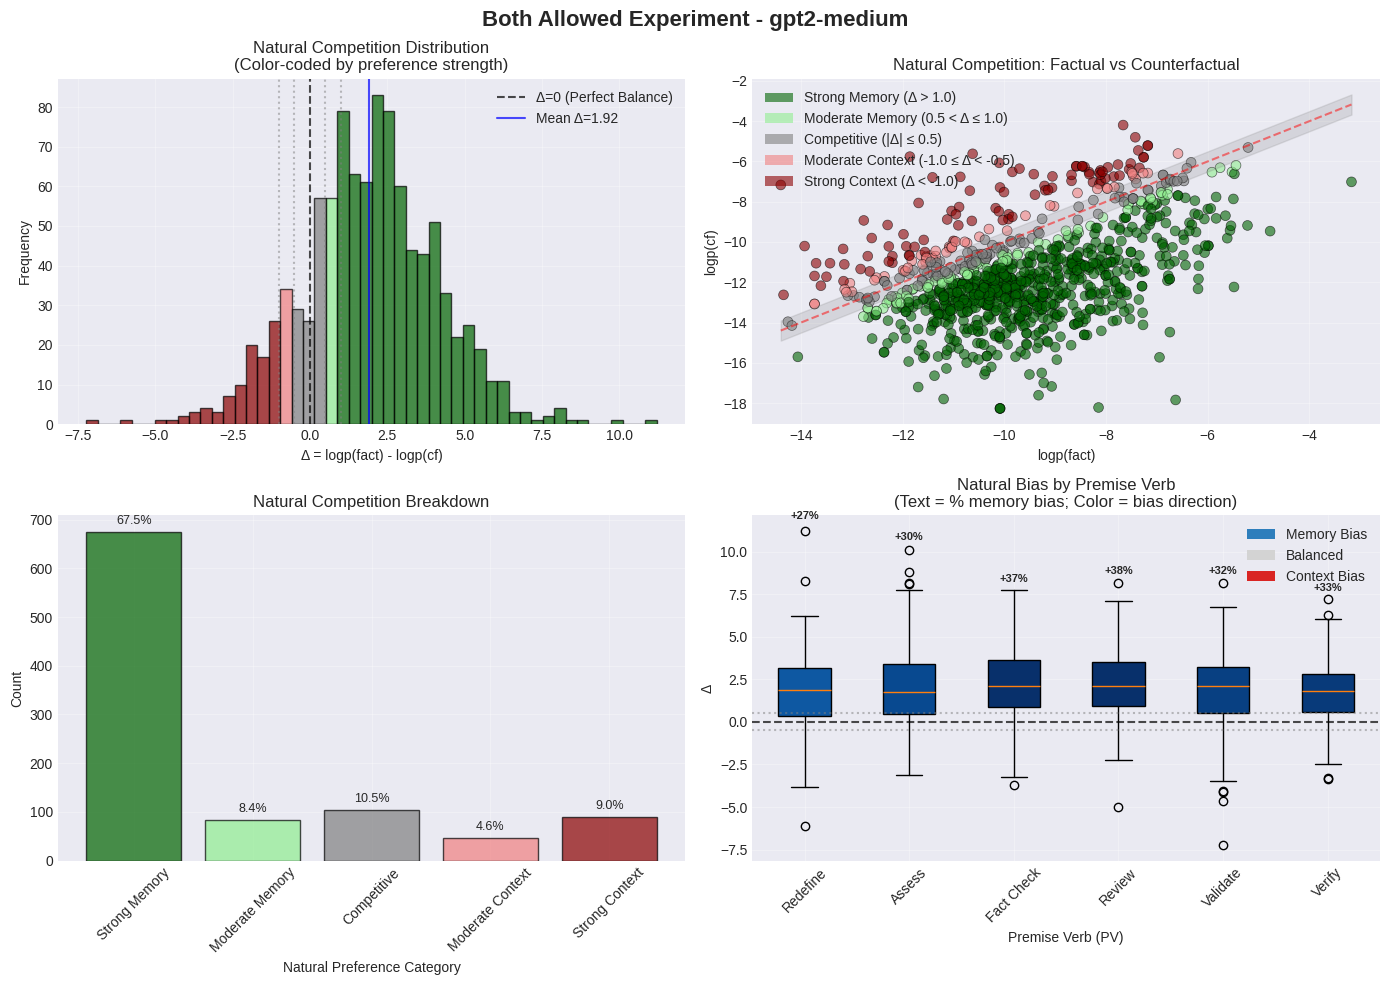


📋 Example Prompts and Results (first 3):

Example 1:
  Subject: Second Polish Republic
  Premise Verb (PV): Validate
  Question: What is the capital of the second Polish Republic?
  Counterfactual Statement (CF): 'Second Polish Republic's capital is Delhi. Second Polish Republic's capital is'
  Factual answer: ' Warsaw'
  Counterfactual answer: ' Delhi'
  Prediction: factual
  logp(fact): -7.2266
  logp(cf): -9.3672
  Δ: 2.1406 (logp(fact) - logp(cf))
  Natural Competition Category: Strong Memory
  Natural Bias: MEMORY
------------------------------------------------------------------------------------------

Example 2:
  Subject: Ferrari F2002
  Premise Verb (PV): Redefine
  Question: What company developed the Ferrari F2002?
  Counterfactual Statement (CF): 'Ferrari F2002, developed by Nissan. What company developed the Ferrari F2002? Answer:'
  Factual answer: ' Ferrari'
  Counterfactual answer: ' Nissan'
  Prediction: factual
  logp(fact): -10.7969
  logp(cf): -12.8281
  Δ: 2.0312

In [3]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class BothAllowedResult:
    """Stores results for a single prompt in Both Allowed condition"""
    subject: str
    question: str
    premise_verb: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class BothAllowedExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-medium"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise verbs to analyze
        self.premise_verbs = ['Redefine', 'Assess', 'Fact Check', 'Review', 'Validate', 'Verify']
        
        # Both Allowed prompt template (Natural Competition)
        self.both_allowed_template = (
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            print(f"Loading {self.model_name} on {device}...")
            
            # For GPT-2 medium, we can use float16 for efficiency
            use_fp16 = device == "cuda"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if use_fp16 else torch.float32
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            print(f"  Device: {device}")
            print(f"  Parameters: {self.model.cfg.n_params:,}")
            print(f"  Layers: {self.model.cfg.n_layers}")
            print(f"  Heads: {self.model.cfg.n_heads}")
            print(f"  Context window: {self.model.cfg.n_ctx}")
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # Group by premise verb for analysis
            self.verb_groups = {verb: [] for verb in self.premise_verbs}
            
            for item in self.dataset:
                # Extract premise verb from prompt
                if 'prompt' in item:
                    premise_verb = item['prompt'].split(':')[0].strip()
                    if premise_verb in self.verb_groups:
                        self.verb_groups[premise_verb].append(item)
                else:
                    # Handle different dataset formats if needed
                    continue
            
            print("\nDataset Distribution:")
            print("-" * 40)
            total_filtered = 0
            for verb in self.premise_verbs:
                count = len(self.verb_groups[verb])
                total_filtered += count
                if count > 0:
                    print(f"  {verb:12}: {count:4d} prompts")
            
            print(f"\nTotal filtered prompts: {total_filtered}")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_premise_verb(self, prompt: str) -> str:
        """Extract premise verb (PV) from original prompt"""
        # Extract the verb before the first colon
        if ':' in prompt:
            return prompt.split(':')[0].strip()
        return "Unknown"
    
    def extract_counterfactual_statement(self, prompt: str, subject: str, target_new: str, premise_verb: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in prompt:
            parts = prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                # Remove the premise verb if it appears again in the statement
                if statement_part.startswith(premise_verb):
                    statement_part = statement_part[len(premise_verb):].strip()
                    if statement_part.startswith(':'):
                        statement_part = statement_part[1:].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        # Use appropriate verb based on premise verb
        if premise_verb == 'Redefine':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Assess':
            return f"{subject} is created by {target_new}"
        elif premise_verb == 'Fact Check':
            return f"{subject} was created by {target_new}"
        elif premise_verb == 'Review':
            return f"{subject} is a product of {target_new}"
        elif premise_verb == 'Validate':
            return f"{subject} was made by {target_new}"
        elif premise_verb == 'Verify':
            return f"{subject} is made by {target_new}"
        else:
            return f"{subject} was created by {target_new}"
    
    def create_both_allowed_prompt(self, counterfactual_statement: str, question: str) -> str:
        """Create both allowed prompt for natural competition"""
        return self.both_allowed_template.format(
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                if i > 0:  # Make sure we don't access index -1
                    token_logp = log_probs[0, i-1, token_id].item()
                    total_logp += token_logp
        
        return total_logp
    
    def process_item(self, item: Dict) -> Optional[BothAllowedResult]:
        """Process a single dataset item for Both Allowed condition"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract premise verb (PV)
            premise_verb = self.extract_premise_verb(original_prompt)
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer, premise_verb
            )
            
            # Create both allowed prompt
            prompt = self.create_both_allowed_prompt(cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction (factual if delta > 0, else counterfactual)
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = BothAllowedResult(
                subject=subject,
                question=question,
                premise_verb=premise_verb,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Both Allowed experiment"""
        print(f"\n{'='*70}")
        print(f"EXPERIMENT 7: BOTH ALLOWED (NATURAL COMPETITION) - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = []
        for verb in self.premise_verbs:
            all_items.extend(self.verb_groups[verb])
        
        if sample_size and sample_size < len(all_items):
            # Random sampling
            import random
            random.seed(42)
            all_items = random.sample(all_items, sample_size)
        
        print(f"\nProcessing {len(all_items)} prompts...")
        
        # Process each item
        self.results = []
        for item in tqdm(all_items, desc="Processing prompts"):
            result = self.process_item(item)
            if result:
                self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Both Allowed condition"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        # Calculate natural competition metrics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs = np.mean([abs(r.delta) for r in self.results])
        
        print(f"\n{'='*60}")
        print("EXPERIMENT 7 RESULTS - BOTH ALLOWED (NATURAL COMPETITION)")
        print(f"{'='*60}")
        print(f"\nOverall Metrics:")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        print(f"\nNatural Competition Metrics:")
        print(f"  Δ std dev:  {delta_std:.4f} (higher = more variable behavior)")
        print(f"  |Δ| mean:   {delta_abs:.4f} (higher = stronger preferences)")
        
        # Theoretical framework analysis
        print(f"\n{'='*60}")
        print("THEORETICAL FRAMEWORK ANALYSIS")
        print(f"{'='*60}")
        print("\nIn Both Allowed condition (Natural Competition), we expect:")
        print("  - No explicit instructions bias the model")
        print("  - Model naturally balances parametric memory vs in-context learning")
        print("  - This represents the 'default' or 'natural' competition state")
        print("  - Useful as baseline for comparing instruction effectiveness")
        
        # Calculate dominance metrics
        memory_dominance = factual_percent  # % factual = memory dominance
        context_dominance = counterfactual_percent  # % counterfactual = context dominance
        net_dominance = memory_dominance - context_dominance
        
        print(f"\nNatural Dominance Analysis:")
        print(f"  Memory (parametric) dominance: {memory_dominance:.1f}%")
        print(f"  Context (ICL) dominance: {context_dominance:.1f}%")
        print(f"  Net dominance: {net_dominance:+.1f}% (positive = memory dominant)")
        
        # Balance analysis
        balance_index = abs(factual_percent - 50)
        
        print(f"\nBalance Analysis:")
        print(f"  Balance index: {balance_index:.1f} (0 = perfect balance, 50 = completely imbalanced)")
        if balance_index < 10:
            print(f"  Interpretation: HIGHLY BALANCED natural competition")
        elif balance_index < 25:
            print(f"  Interpretation: MODERATELY BALANCED natural competition")
        else:
            print(f"  Interpretation: IMBALANCED natural competition")
        
        # Analyze by premise verb
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE VERB (PV)")
        print(f"{'='*60}")
        print(f"\n{'Premise Verb':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Δ Std':<10} {'Natural Bias':<12}")
        print("-" * 80)
        
        verb_stats = {}
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            
            if verb_results:
                verb_total = len(verb_results)
                verb_factual = sum(1 for r in verb_results if r.prediction == "factual")
                verb_factual_pct = (verb_factual / verb_total) * 100
                verb_delta = np.mean([r.delta for r in verb_results])
                verb_delta_std = np.std([r.delta for r in verb_results])
                verb_net_dominance = verb_factual_pct - (100 - verb_factual_pct)
                
                verb_stats[verb] = {
                    'count': verb_total,
                    'factual_pct': verb_factual_pct,
                    'counterfactual_pct': 100 - verb_factual_pct,
                    'avg_delta': verb_delta,
                    'delta_std': verb_delta_std,
                    'net_dominance': verb_net_dominance
                }
                
                # Natural bias indicator
                if verb_net_dominance > 10:
                    bias_indicator = "Memory Bias"
                elif verb_net_dominance < -10:
                    bias_indicator = "Context Bias"
                else:
                    bias_indicator = "Balanced"
                
                print(f"{verb:<15} {verb_total:<8} {verb_factual_pct:<10.1f} "
                      f"{100-verb_factual_pct:<10.1f} {verb_delta:<10.4f} {verb_delta_std:<10.4f} {bias_indicator:<12}")
        
        # Calculate overall natural competition classification
        print(f"\n{'='*60}")
        print("NATURAL COMPETITION CLASSIFICATION")
        print(f"{'='*60}")
        
        # Classify prompts by natural preference strength
        strong_memory = sum(1 for r in self.results if r.delta > 1.0)
        moderate_memory = sum(1 for r in self.results if 0.5 < r.delta <= 1.0)
        competitive = sum(1 for r in self.results if -0.5 <= r.delta <= 0.5)
        moderate_context = sum(1 for r in self.results if -1.0 <= r.delta < -0.5)
        strong_context = sum(1 for r in self.results if r.delta < -1.0)
        
        print(f"\nNatural Preference Spectrum:")
        print(f"  Strong Memory (Δ > 1.0): {strong_memory}/{total} ({strong_memory/total*100:.1f}%)")
        print(f"  Moderate Memory (0.5 < Δ ≤ 1.0): {moderate_memory}/{total} ({moderate_memory/total*100:.1f}%)")
        print(f"  Competitive (|Δ| ≤ 0.5): {competitive}/{total} ({competitive/total*100:.1f}%)")
        print(f"  Moderate Context (-1.0 ≤ Δ < -0.5): {moderate_context}/{total} ({moderate_context/total*100:.1f}%)")
        print(f"  Strong Context (Δ < -1.0): {strong_context}/{total} ({strong_context/total*100:.1f}%)")
        
        # Calculate natural bias summary
        memory_total = strong_memory + moderate_memory
        context_total = moderate_context + strong_context
        
        print(f"\nSummary Classification:")
        print(f"  Memory-leaning total: {memory_total}/{total} ({memory_total/total*100:.1f}%)")
        print(f"  Competitive: {competitive}/{total} ({competitive/total*100:.1f}%)")
        print(f"  Context-leaning total: {context_total}/{total} ({context_total/total*100:.1f}%)")
        
        return verb_stats
    
    def plot_results(self):
        """Plot Both Allowed experiment results"""
        if not self.results:
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Both Allowed Experiment - {self.model_name}', fontsize=16, fontweight='bold')
        
        # Plot 1: Distribution of Δ values (natural competition)
        deltas = [r.delta for r in self.results]
        
        # Create histogram with natural competition zones
        n, bins, patches = axes[0, 0].hist(deltas, bins=50, alpha=0.7, color='goldenrod', edgecolor='black')
        
        # Color patches based on zones
        for i in range(len(patches)):
            bin_center = (bins[i] + bins[i+1]) / 2
            if bin_center > 1.0:
                patches[i].set_facecolor('darkgreen')  # Strong memory
            elif bin_center > 0.5:
                patches[i].set_facecolor('lightgreen')  # Moderate memory
            elif bin_center > -0.5:
                patches[i].set_facecolor('gray')  # Competitive
            elif bin_center > -1.0:
                patches[i].set_facecolor('lightcoral')  # Moderate context
            else:
                patches[i].set_facecolor('darkred')  # Strong context
        
        axes[0, 0].axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Δ=0 (Perfect Balance)')
        axes[0, 0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                          label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Add zone labels
        axes[0, 0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=-0.5, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=1.0, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=-1.0, color='gray', linestyle=':', alpha=0.5)
        
        axes[0, 0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Natural Competition Distribution\n(Color-coded by preference strength)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot with natural competition coloring
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by Δ category
        colors = []
        for r in self.results:
            if r.delta > 1.0:
                colors.append('darkgreen')  # Strong memory
            elif r.delta > 0.5:
                colors.append('lightgreen')  # Moderate memory
            elif r.delta > -0.5:
                colors.append('gray')  # Competitive
            elif r.delta > -1.0:
                colors.append('lightcoral')  # Moderate context
            else:
                colors.append('darkred')  # Strong context
        
        scatter = axes[0, 1].scatter(factual_logps, counterfactual_logps, 
                                     c=colors, alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
        axes[0, 1].plot([min(factual_logps), max(factual_logps)], 
                       [min(factual_logps), max(factual_logps)], 
                       'r--', alpha=0.5, label='Δ=0 (Balance Line)')
        
        # Add competitive zone (close to diagonal)
        diag_range = np.linspace(min(factual_logps), max(factual_logps), 100)
        axes[0, 1].fill_between(diag_range, diag_range - 0.5, diag_range + 0.5, 
                               alpha=0.2, color='gray', label='Competitive Zone (|Δ| < 0.5)')
        
        axes[0, 1].set_xlabel('logp(fact)')
        axes[0, 1].set_ylabel('logp(cf)')
        axes[0, 1].set_title('Natural Competition: Factual vs Counterfactual')
        axes[0, 1].legend(loc='best')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add custom legend for point colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkgreen', alpha=0.6, label='Strong Memory (Δ > 1.0)'),
            Patch(facecolor='lightgreen', alpha=0.6, label='Moderate Memory (0.5 < Δ ≤ 1.0)'),
            Patch(facecolor='gray', alpha=0.6, label='Competitive (|Δ| ≤ 0.5)'),
            Patch(facecolor='lightcoral', alpha=0.6, label='Moderate Context (-1.0 ≤ Δ < -0.5)'),
            Patch(facecolor='darkred', alpha=0.6, label='Strong Context (Δ < -1.0)')
        ]
        axes[0, 1].legend(handles=legend_elements, loc='upper left')
        
        # Plot 3: Natural dominance breakdown
        categories = ['Strong Memory', 'Moderate Memory', 'Competitive', 'Moderate Context', 'Strong Context']
        counts = [
            sum(1 for r in self.results if r.delta > 1.0),
            sum(1 for r in self.results if 0.5 < r.delta <= 1.0),
            sum(1 for r in self.results if -0.5 <= r.delta <= 0.5),
            sum(1 for r in self.results if -1.0 <= r.delta < -0.5),
            sum(1 for r in self.results if r.delta < -1.0)
        ]
        colors = ['darkgreen', 'lightgreen', 'gray', 'lightcoral', 'darkred']
        
        bars = axes[1, 0].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Natural Preference Category')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Natural Competition Breakdown')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_xticklabels(categories, rotation=45)
        
        # Add percentage labels
        total = len(self.results)
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / total) * 100
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + total*0.01, 
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Δ distribution by premise verb with natural bias
        premise_deltas = {}
        premise_bias = {}
        
        for verb in self.premise_verbs:
            verb_results = [r for r in self.results if r.premise_verb == verb]
            if verb_results:
                verb_deltas = [r.delta for r in verb_results]
                premise_deltas[verb] = verb_deltas
                
                # Calculate natural bias
                verb_factual = sum(1 for r in verb_results if r.delta > 0)
                verb_bias = (verb_factual / len(verb_deltas) * 100) - 50  # Positive = memory bias
                premise_bias[verb] = verb_bias
        
        if premise_deltas:
            # Create subplot for boxplot
            positions = range(1, len(premise_deltas) + 1)
            bp = axes[1, 1].boxplot(premise_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on natural bias
            for i, (verb, patch) in enumerate(zip(premise_deltas.keys(), bp['boxes'])):
                bias = premise_bias.get(verb, 0)
                # Color scale: blue for memory bias, red for context bias, white for balanced
                if bias > 5:
                    # Memory bias
                    color_intensity = min(0.8, bias/50)
                    patch.set_facecolor(plt.cm.Blues(0.3 + color_intensity))
                elif bias < -5:
                    # Context bias
                    color_intensity = min(0.8, abs(bias)/50)
                    patch.set_facecolor(plt.cm.Reds(0.3 + color_intensity))
                else:
                    # Balanced
                    patch.set_facecolor('lightgray')
                
                # Add bias value as text
                axes[1, 1].text(positions[i], np.max(list(premise_deltas.values())[i]) * 1.05,
                               f'{bias:+.0f}%', ha='center', va='bottom', fontsize=8,
                               fontweight='bold' if abs(bias) > 10 else 'normal')
            
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Δ=0')
            axes[1, 1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
            axes[1, 1].axhline(y=-0.5, color='gray', linestyle=':', alpha=0.5)
            
            axes[1, 1].set_xticks(positions)
            axes[1, 1].set_xticklabels(premise_deltas.keys(), rotation=45)
            axes[1, 1].set_xlabel('Premise Verb (PV)')
            axes[1, 1].set_ylabel('Δ')
            axes[1, 1].set_title('Natural Bias by Premise Verb\n(Text = % memory bias; Color = bias direction)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Add bias direction legend
            bias_legend = [
                Patch(facecolor=plt.cm.Blues(0.7), label='Memory Bias'),
                Patch(facecolor='lightgray', label='Balanced'),
                Patch(facecolor=plt.cm.Reds(0.7), label='Context Bias')
            ]
            axes[1, 1].legend(handles=bias_legend, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'both_allowed_experiment_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_baseline(self, baseline_path: str = "baseline_results.json"):
        """Compare Both Allowed with Baseline (clean question only)"""
        try:
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            
            baseline_summary = baseline_data['summary']
            
            # Calculate our summary
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            print(f"\n{'='*70}")
            print("COMPARISON: BOTH ALLOWED vs BASELINE (CLEAN QUESTION)")
            print(f"{'='*70}")
            print(f"\n{'Metric':<25} {'Baseline (Q only)':<20} {'Both Allowed (CF + Q)':<20} {'Difference':<15}")
            print("-" * 80)
            
            print(f"{'% Factual':<25} "
                  f"{baseline_summary['factual_percent']:<20.1f} "
                  f"{factual_percent:<20.1f} "
                  f"{factual_percent - baseline_summary['factual_percent']:>+15.1f}")
            
            print(f"{'Avg Δ':<25} "
                  f"{baseline_summary['avg_delta']:<20.4f} "
                  f"{avg_delta:<20.4f} "
                  f"{avg_delta - baseline_summary['avg_delta']:>+15.4f}")
            
            print(f"\nInterpretation:")
            print(f"- Baseline: Clean question only (no counterfactual context)")
            print(f"- Both Allowed: Question + counterfactual context (natural competition)")
            print(f"- Difference shows effect of adding counterfactual context")
            print(f"- Expected: Adding CF should DECREASE factual % and DECREASE Δ")
            
            factual_diff = factual_percent - baseline_summary['factual_percent']
            delta_diff = avg_delta - baseline_summary['avg_delta']
            
            print(f"\nEffect of Adding Counterfactual Context:")
            print(f"  Factual % change: {factual_diff:+.1f}% (expected negative)")
            print(f"  Δ change: {delta_diff:+.4f} (expected negative)")
            
            if factual_diff < 0 and delta_diff < 0:
                print(f"  Conclusion: ✓ Counterfactual context biases toward ICL as expected")
            elif factual_diff < 0 or delta_diff < 0:
                print(f"  Conclusion: ⚠ Counterfactual context has partial effect")
            else:
                print(f"  Conclusion: ✗ Counterfactual context has unexpected effect")
            
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
    
    def compare_with_instruction_conditions(self, 
                                          context_only_path: str = "context_only_results.json",
                                          memory_only_path: str = "memory_only_results.json",
                                          memory_weak_path: str = "memory_only_weak_results.json"):
        """Compare natural competition with instruction-based conditions"""
        comparisons = []
        
        try:
            # Load context-only results
            with open(context_only_path, 'r') as f:
                context_data = json.load(f)
            context_summary = context_data['summary']
            comparisons.append(('Context-Only', context_summary))
        except FileNotFoundError:
            print(f"✗ Context-Only results file not found at {context_only_path}")
        
        try:
            # Load memory-only results
            with open(memory_only_path, 'r') as f:
                memory_data = json.load(f)
            memory_summary = memory_data['summary']
            comparisons.append(('Memory-Only', memory_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only results file not found at {memory_only_path}")
        
        try:
            # Load memory-weak results
            with open(memory_weak_path, 'r') as f:
                memory_weak_data = json.load(f)
            memory_weak_summary = memory_weak_data['summary']
            comparisons.append(('Memory-Only Weak', memory_weak_summary))
        except FileNotFoundError:
            print(f"✗ Memory-Only Weak results file not found at {memory_weak_path}")
        
        if not comparisons:
            print("No comparison data available")
            return
        
        # Calculate our summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        avg_delta = np.mean([r.delta for r in self.results])
        
        print(f"\n{'='*80}")
        print("COMPARISON: NATURAL COMPETITION vs INSTRUCTION-BASED CONDITIONS")
        print(f"{'='*80}")
        print(f"\n{'Metric':<25} ", end="")
        for exp_name, _ in comparisons:
            print(f"{exp_name:<20}", end="")
        print(f"{'Both Allowed':<20}")
        print("-" * (25 + 20 * (len(comparisons) + 1)))
        
        # Factual percentage
        print(f"{'% Factual':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('factual_percent', 0):<20.1f}", end="")
        print(f"{factual_percent:<20.1f}")
        
        # Average Δ
        print(f"{'Avg Δ':<25} ", end="")
        for exp_name, summary in comparisons:
            print(f"{summary.get('avg_delta', 0):<20.4f}", end="")
        print(f"{avg_delta:<20.4f}")
        
        # Instruction following percentage (where applicable)
        print(f"\n{'Instruction Following':<25} ", end="")
        for exp_name, summary in comparisons:
            if exp_name == 'Context-Only':
                ict_percent = summary.get('negative_delta_percent', 0)
            elif exp_name.startswith('Memory-Only'):
                ict_percent = summary.get('positive_delta_percent', summary.get('follows_memory_percent', 0))
            else:
                ict_percent = 0
            print(f"{ict_percent:<20.1f}", end="")
        print(f"{'N/A':<20}")
        
        print(f"\nInterpretation:")
        print(f"Natural competition (Both Allowed) should be:")
        print(f"  - Between Context-Only and Memory-Only in factual %")
        print(f"  - Between Context-Only and Memory-Only in Δ")
        print(f"  - Closer to Memory-Only Weak than strong conditions")
        
        # Calculate position in the spectrum
        if 'Context-Only' in [name for name, _ in comparisons] and 'Memory-Only' in [name for name, _ in comparisons]:
            context_idx = [name for name, _ in comparisons].index('Context-Only')
            memory_idx = [name for name, _ in comparisons].index('Memory-Only')
            
            context_factual = comparisons[context_idx][1].get('factual_percent', 0)
            memory_factual = comparisons[memory_idx][1].get('factual_percent', 0)
            
            # Calculate where Both Allowed falls between Context and Memory
            if memory_factual != context_factual:
                position = (factual_percent - context_factual) / (memory_factual - context_factual) * 100
                print(f"\nPosition on Context ↔ Memory Spectrum:")
                print(f"  Context-Only: {context_factual:.1f}% factual")
                print(f"  Both Allowed: {factual_percent:.1f}% factual")
                print(f"  Memory-Only: {memory_factual:.1f}% factual")
                print(f"  Spectrum position: {position:.1f}% (0% = Context, 100% = Memory)")
                
                if position < 33:
                    print(f"  Interpretation: Leaning toward CONTEXT dominance")
                elif position < 67:
                    print(f"  Interpretation: RELATIVELY BALANCED")
                else:
                    print(f"  Interpretation: Leaning toward MEMORY dominance")
    
    def create_natural_competition_spectrum(self, 
                                          baseline_path: str = "baseline_results.json",
                                          context_only_path: str = "context_only_results.json",
                                          memory_only_path: str = "memory_only_results.json",
                                          memory_weak_path: str = "memory_only_weak_results.json"):
        """Create visualization of the natural competition spectrum"""
        try:
            # Load all comparison data
            summaries = {}
            
            with open(baseline_path, 'r') as f:
                summaries['Baseline (Q only)'] = json.load(f)['summary']
            
            with open(context_only_path, 'r') as f:
                summaries['Context-Only'] = json.load(f)['summary']
            
            with open(memory_only_path, 'r') as f:
                summaries['Memory-Only'] = json.load(f)['summary']
            
            with open(memory_weak_path, 'r') as f:
                summaries['Memory-Only Weak'] = json.load(f)['summary']
            
            # Our data
            total = len(self.results)
            factual_count = sum(1 for r in self.results if r.prediction == "factual")
            factual_percent = (factual_count / total) * 100
            avg_delta = np.mean([r.delta for r in self.results])
            
            summaries['Both Allowed'] = {
                'factual_percent': factual_percent,
                'avg_delta': avg_delta
            }
            
            # Create comprehensive spectrum visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Define the spectrum order
            spectrum_order = ['Baseline (Q only)', 'Memory-Only', 'Memory-Only Weak', 
                            'Both Allowed', 'Context-Only']
            
            # Filter to available conditions
            available_conditions = [cond for cond in spectrum_order if cond in summaries]
            
            # Plot 1: Factual percentage spectrum
            factuals = [summaries[cond]['factual_percent'] for cond in available_conditions]
            colors = ['gray', 'teal', 'dodgerblue', 'goldenrod', 'orange']
            
            # Create positions based on theoretical spectrum
            positions = np.arange(len(available_conditions))
            
            bars = ax1.bar(positions, factuals, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Condition on Natural ↔ Instruction Spectrum')
            ax1.set_ylabel('Factual Predictions (%)')
            ax1.set_title('Natural Competition Spectrum\n(Factual Percentage)')
            ax1.set_xticks(positions)
            ax1.set_xticklabels(available_conditions, rotation=45, ha='right')
            ax1.grid(True, alpha=0.3)
            
            # Add percentage labels
            for bar, fact in zip(bars, factuals):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2, height + 1, 
                        f'{fact:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            # Add theoretical arrows
            ax1.annotate('More Natural →', xy=(0.5, 0.95), xycoords='axes fraction', 
                        ha='center', fontsize=10, fontweight='bold')
            
            # Add interpretation regions
            ymin, ymax = ax1.get_ylim()
            ax1.fill_between([-0.5, 2.5], ymin, ymax, alpha=0.1, color='green', label='Memory-Dominant Region')
            ax1.fill_between([2.5, 4.5], ymin, ymax, alpha=0.1, color='orange', label='Context-Dominant Region')
            ax1.legend(loc='upper right')
            
            # Plot 2: Δ spectrum
            deltas = [summaries[cond]['avg_delta'] for cond in available_conditions]
            
            bars2 = ax2.bar(positions, deltas, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Condition on Natural ↔ Instruction Spectrum')
            ax2.set_ylabel('Average Δ (logp(fact) - logp(cf))')
            ax2.set_title('Natural Competition Spectrum\n(Δ Values)')
            ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Balance)')
            ax2.set_xticks(positions)
            ax2.set_xticklabels(available_conditions, rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            
            # Add delta value labels
            for bar, delta in zip(bars2, deltas):
                height = bar.get_height()
                y_pos = height + (0.1 if height > 0 else -0.2)
                va = 'bottom' if height > 0 else 'top'
                ax2.text(bar.get_x() + bar.get_width()/2, y_pos, 
                        f'{delta:+.3f}', ha='center', va=va, 
                        fontweight='bold', fontsize=9)
            
            # Add interpretation line at Δ=0
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            
            # Add Δ interpretation regions
            ax2.fill_between([-0.5, 2.5], 0, ax2.get_ylim()[1], alpha=0.1, color='green')
            ax2.fill_between([2.5, 4.5], ax2.get_ylim()[0], 0, alpha=0.1, color='orange')
            
            plt.tight_layout()
            plt.savefig(f'natural_competition_spectrum_{self.model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Create a specialized natural competition analysis plot
            self.create_natural_balance_plot(summaries)
            
        except FileNotFoundError as e:
            print(f"✗ Could not create natural competition spectrum: {e}")
    
    def create_natural_balance_plot(self, summaries):
        """Create a plot analyzing natural balance vs instruction effects"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Focus on key conditions for balance analysis
        key_conditions = ['Baseline (Q only)', 'Both Allowed', 'Context-Only', 'Memory-Only']
        available_keys = [cond for cond in key_conditions if cond in summaries]
        
        # Prepare data
        conditions = []
        factuals = []
        deltas = []
        
        for cond in available_keys:
            conditions.append(cond)
            factuals.append(summaries[cond]['factual_percent'])
            deltas.append(summaries[cond]['avg_delta'])
        
        # Plot 1: Factual percentage with balance line
        x_pos = np.arange(len(conditions))
        colors = ['gray', 'goldenrod', 'orange', 'teal']
        
        bars1 = axes[0].bar(x_pos, factuals, color=colors, alpha=0.7, edgecolor='black')
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Perfect Balance (50%)')
        axes[0].set_xlabel('Condition')
        axes[0].set_ylabel('Factual Predictions (%)')
        axes[0].set_title('Natural Balance Analysis')
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels(conditions, rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Add distance from balance line
        for i, (bar, fact) in enumerate(zip(bars1, factuals)):
            height = bar.get_height()
            balance_distance = abs(fact - 50)
            axes[0].text(bar.get_x() + bar.get_width()/2, height + 1, 
                        f'Δ{balance_distance:.1f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Instruction effect size
        if 'Baseline (Q only)' in summaries and 'Both Allowed' in summaries:
            baseline_factual = summaries['Baseline (Q only)']['factual_percent']
            natural_factual = summaries['Both Allowed']['factual_percent']
            
            # Calculate instruction effects
            context_effect = summaries.get('Context-Only', {}).get('factual_percent', 0) - natural_factual
            memory_effect = summaries.get('Memory-Only', {}).get('factual_percent', 0) - natural_factual
            
            effects = {
                'Context Instruction': context_effect,
                'Memory Instruction': memory_effect
            }
            
            effect_conditions = list(effects.keys())
            effect_values = list(effects.values())
            effect_colors = ['orange' if v < 0 else 'teal' for v in effect_values]
            
            bars2 = axes[1].bar(effect_conditions, effect_values, color=effect_colors, alpha=0.7, edgecolor='black')
            axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[1].set_xlabel('Instruction Type')
            axes[1].set_ylabel('Effect Size (% Factual Change)')
            axes[1].set_title('Instruction Effectiveness from Natural State')
            axes[1].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, effect in zip(bars2, effect_values):
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2, height + (0.5 if height > 0 else -1.5), 
                            f'{effect:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                            fontweight='bold')
            
            # Add interpretation
            axes[1].text(0.02, 0.95, 'Negative: Reduces factual %\nPositive: Increases factual %', 
                        transform=axes[1].transAxes, fontsize=8, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'natural_balance_analysis_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "both_allowed_results_gpt2_medium.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_verb': result.premise_verb,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate overall summary and competition classification
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        
        # Competition categories
        competition_categories = {
            'strong_memory': sum(1 for r in self.results if r.delta > 1.0),
            'moderate_memory': sum(1 for r in self.results if 0.5 < r.delta <= 1.0),
            'competitive': sum(1 for r in self.results if -0.5 <= r.delta <= 0.5),
            'moderate_context': sum(1 for r in self.results if -1.0 <= r.delta < -0.5),
            'strong_context': sum(1 for r in self.results if r.delta < -1.0)
        }
        
        # Calculate percentages
        for key in competition_categories:
            competition_categories[f'{key}_percent'] = (competition_categories[key] / total) * 100
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'condition': 'Both Allowed (Natural Competition)',
                'prompt_template': self.both_allowed_template,
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'delta_std': np.std([r.delta for r in self.results]),
                    'net_dominance': factual_percent - (100 - factual_percent),
                    'balance_index': abs(factual_percent - 50)
                },
                'natural_competition_classification': competition_categories
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")


# Main execution function
def run_both_allowed_experiment():
    """Run the Both Allowed experiment with GPT-2 Medium"""
    
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"  # Update this path as needed
    MODEL_NAME = "gpt2-medium"
    
    # If dataset doesn't exist at that path, try to find it
    import os
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        # Try common alternative locations
        alternative_paths = [
            "./gpt2_with_questions_merged.json",
            "./data/gpt2_with_questions_merged.json",
            "../gpt2_with_questions_merged.json",
            "gpt2_with_questions_merged.json"
        ]
        
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                DATASET_PATH = alt_path
                print(f"Found dataset at: {DATASET_PATH}")
                break
        
        if not os.path.exists(DATASET_PATH):
            print("❌ Dataset not found. Please update DATASET_PATH.")
            return
    
    print(f"Dataset path: {DATASET_PATH}")
    print(f"Model: {MODEL_NAME}")
    
    # Initialize and run experiment
    experiment = BothAllowedExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run with sampling (e.g., 100 prompts) or full dataset
    # Set sample_size=None for full dataset, or an integer for sampling
    SAMPLE_SIZE = 1000  # Adjust as needed for quick testing
    # SAMPLE_SIZE = None  # For full dataset
    
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save detailed results
        output_file = f"both_allowed_results_{MODEL_NAME}.json"
        # experiment.save_results(output_file)
        
        # Print example results
        print("\n📋 Example Prompts and Results (first 3):")
        print("=" * 90)
        for i, result in enumerate(experiment.results[:3]):
            print(f"\nExample {i+1}:")
            print(f"  Subject: {result.subject}")
            print(f"  Premise Verb (PV): {result.premise_verb}")
            print(f"  Question: {result.question}")
            print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
            print(f"  Factual answer: '{result.factual_answer}'")
            print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
            print(f"  Prediction: {result.prediction}")
            print(f"  logp(fact): {result.factual_logp:.4f}")
            print(f"  logp(cf): {result.counterfactual_logp:.4f}")
            print(f"  Δ: {result.delta:.4f} (logp(fact) - logp(cf))")
            
            # Competition category
            if result.delta > 1.0:
                comp_category = "Strong Memory"
            elif result.delta > 0.5:
                comp_category = "Moderate Memory"
            elif result.delta > -0.5:
                comp_category = "Competitive"
            elif result.delta > -1.0:
                comp_category = "Moderate Context"
            else:
                comp_category = "Strong Context"
            
            print(f"  Natural Competition Category: {comp_category}")
            print(f"  Natural Bias: {'MEMORY' if result.delta > 0 else 'CONTEXT'}")
            print("-" * 90)
    
    return experiment


# Alternative: Simple usage for quick testing
def quick_test():
    """Quick test with minimal prompts"""
    print("Running quick test...")
    
    # Create a minimal test dataset
    test_data = [
        {
            'question': 'Who created the Airbus A380?',
            'target_true': 'Airbus',
            'target_new': 'Adobe',
            'subject': 'Airbus A380',
            'prompt': 'Redefine: Airbus A380 was created by Adobe'
        },
        {
            'question': 'Who created Windows?',
            'target_true': 'Microsoft',
            'target_new': 'Apple',
            'subject': 'Windows',
            'prompt': 'Assess: Windows is created by Apple'
        }
    ]
    
    # Save test data
    with open('test_data.json', 'w') as f:
        json.dump(test_data, f, indent=2)
    
    # Run experiment
    experiment = BothAllowedExperiment('test_data.json', 'gpt2-medium')
    experiment.run_experiment()
    
    return experiment


if __name__ == "__main__":
    # Run the full experiment
    experiment = run_both_allowed_experiment()
    
    # Alternatively, run quick test:
    # experiment = quick_test()